In [37]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [38]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [39]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [40]:
class CigButtsConfig(Config):
    # Give the configuration a recognizable name
    NAME = "soldiers"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 (cig_butt)

#     # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [41]:
class CocoLikeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [42]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('datasets/soldiers/train/coco_annotations.json', 'datasets/soldiers/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('datasets/soldiers/val/coco_annotations.json', 'datasets/soldiers/val/images')
dataset_val.prepare()

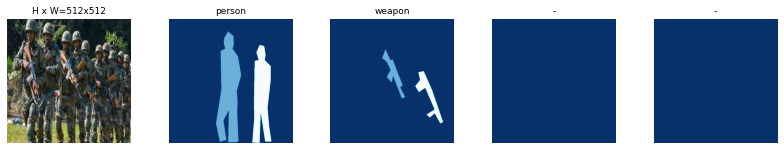

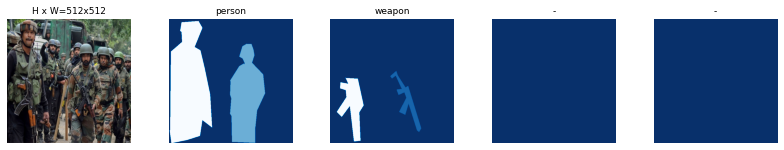

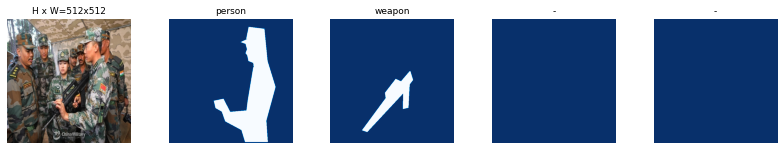

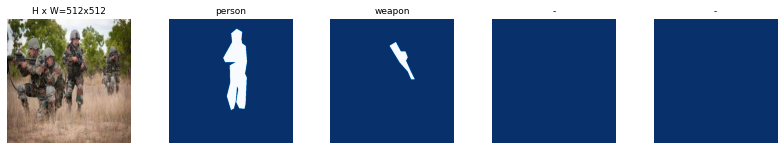

In [43]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [44]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [45]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [46]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: aktwelve_Mask_RCNN\logs\soldiers20210319T2048\mask_rcnn_soldiers_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv   

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume

  1/500 [..............................] - ETA: 1:13:41 - batch: 0.0000e+00 - size: 1.0000 - loss: 3.8383 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 2.7350 - mrcnn_class_loss: 1.0141 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 30:44 - batch: 0.5000 - size: 1.0000 - loss: 3.9617 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 2.4729 - mrcnn_class_loss: 0.6584 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.3338              

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 29:24 - batch: 1.0000 - size: 1.0000 - loss: 4.5518 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 2.9084 - mrcnn_class_loss: 0.4962 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.4476

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 28:49 - batch: 1.5000 - size: 1.0000 - loss: 4.5474 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 2.8471 - mrcnn_class_loss: 0.3953 - mrcnn_bbox_loss: 0.7269 - mrcnn_mask_loss: 0.4991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 28:50 - batch: 2.0000 - size: 1.0000 - loss: 4.4106 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 2.5465 - mrcnn_class_loss: 0.4129 - mrcnn_bbox_loss: 0.8531 - mrcnn_mask_loss: 0.5303

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 28:54 - batch: 2.5000 - size: 1.0000 - loss: 4.5314 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 2.4852 - mrcnn_class_loss: 0.4165 - mrcnn_bbox_loss: 0.9840 - mrcnn_mask_loss: 0.5827

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 29:04 - batch: 3.0000 - size: 1.0000 - loss: 4.4974 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 2.3988 - mrcnn_class_loss: 0.4004 - mrcnn_bbox_loss: 1.0220 - mrcnn_mask_loss: 0.6168

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 29:05 - batch: 3.5000 - size: 1.0000 - loss: 4.3347 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 2.1952 - mrcnn_class_loss: 0.4159 - mrcnn_bbox_loss: 1.0568 - mrcnn_mask_loss: 0.6101

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 28:53 - batch: 4.0000 - size: 1.0000 - loss: 4.3413 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 2.1301 - mrcnn_class_loss: 0.3739 - mrcnn_bbox_loss: 1.1560 - mrcnn_mask_loss: 0.6233

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 28:49 - batch: 4.5000 - size: 1.0000 - loss: 4.3756 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 2.1584 - mrcnn_class_loss: 0.3434 - mrcnn_bbox_loss: 1.1777 - mrcnn_mask_loss: 0.6378

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 28:38 - batch: 5.0000 - size: 1.0000 - loss: 4.3683 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 2.1289 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 1.1903 - mrcnn_mask_loss: 0.6460

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 28:32 - batch: 5.5000 - size: 1.0000 - loss: 4.3702 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 2.1025 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 1.1974 - mrcnn_mask_loss: 0.6496

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 28:22 - batch: 6.0000 - size: 1.0000 - loss: 4.4066 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 2.0876 - mrcnn_class_loss: 0.3911 - mrcnn_bbox_loss: 1.2146 - mrcnn_mask_loss: 0.6580

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 28:20 - batch: 6.5000 - size: 1.0000 - loss: 4.4053 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 2.0822 - mrcnn_class_loss: 0.3852 - mrcnn_bbox_loss: 1.2229 - mrcnn_mask_loss: 0.6596

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 28:13 - batch: 7.0000 - size: 1.0000 - loss: 4.4181 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 2.0568 - mrcnn_class_loss: 0.3709 - mrcnn_bbox_loss: 1.2689 - mrcnn_mask_loss: 0.6666

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 28:04 - batch: 7.5000 - size: 1.0000 - loss: 4.3685 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 2.0681 - mrcnn_class_loss: 0.3564 - mrcnn_bbox_loss: 1.2224 - mrcnn_mask_loss: 0.6660

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 28:00 - batch: 8.0000 - size: 1.0000 - loss: 4.3225 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 2.0486 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 1.2053 - mrcnn_mask_loss: 0.6675

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 28:02 - batch: 8.5000 - size: 1.0000 - loss: 4.2960 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 2.0291 - mrcnn_class_loss: 0.3615 - mrcnn_bbox_loss: 1.1901 - mrcnn_mask_loss: 0.6596

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 27:59 - batch: 9.0000 - size: 1.0000 - loss: 4.2249 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.9603 - mrcnn_class_loss: 0.3719 - mrcnn_bbox_loss: 1.1856 - mrcnn_mask_loss: 0.6532

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 27:59 - batch: 9.5000 - size: 1.0000 - loss: 4.1998 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.9549 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 1.1686 - mrcnn_mask_loss: 0.6535

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 28:00 - batch: 10.0000 - size: 1.0000 - loss: 4.1706 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.9350 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 1.1549 - mrcnn_mask_loss: 0.6478

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 27:59 - batch: 10.5000 - size: 1.0000 - loss: 4.1628 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.9209 - mrcnn_class_loss: 0.3887 - mrcnn_bbox_loss: 1.1564 - mrcnn_mask_loss: 0.6469

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 27:59 - batch: 11.0000 - size: 1.0000 - loss: 4.1998 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.9554 - mrcnn_class_loss: 0.3942 - mrcnn_bbox_loss: 1.1547 - mrcnn_mask_loss: 0.6451

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 27:58 - batch: 11.5000 - size: 1.0000 - loss: 4.1805 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.9411 - mrcnn_class_loss: 0.4027 - mrcnn_bbox_loss: 1.1434 - mrcnn_mask_loss: 0.6442

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 27:57 - batch: 12.0000 - size: 1.0000 - loss: 4.1839 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.9448 - mrcnn_class_loss: 0.3956 - mrcnn_bbox_loss: 1.1487 - mrcnn_mask_loss: 0.6450

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 27:51 - batch: 12.5000 - size: 1.0000 - loss: 4.1683 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.9421 - mrcnn_class_loss: 0.3849 - mrcnn_bbox_loss: 1.1436 - mrcnn_mask_loss: 0.6456

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 27:52 - batch: 13.0000 - size: 1.0000 - loss: 4.1523 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.9401 - mrcnn_class_loss: 0.3879 - mrcnn_bbox_loss: 1.1284 - mrcnn_mask_loss: 0.6439

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 27:50 - batch: 13.5000 - size: 1.0000 - loss: 4.1248 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.9313 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 1.1133 - mrcnn_mask_loss: 0.6412

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 27:48 - batch: 14.0000 - size: 1.0000 - loss: 4.0922 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.9074 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 1.1060 - mrcnn_mask_loss: 0.6403

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 27:45 - batch: 14.5000 - size: 1.0000 - loss: 4.0724 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.8924 - mrcnn_class_loss: 0.3872 - mrcnn_bbox_loss: 1.0910 - mrcnn_mask_loss: 0.6527

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 27:41 - batch: 15.0000 - size: 1.0000 - loss: 4.1064 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.9299 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 1.0938 - mrcnn_mask_loss: 0.6512

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 27:40 - batch: 15.5000 - size: 1.0000 - loss: 4.0553 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.8943 - mrcnn_class_loss: 0.3873 - mrcnn_bbox_loss: 1.0776 - mrcnn_mask_loss: 0.6474

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 27:38 - batch: 16.0000 - size: 1.0000 - loss: 4.0141 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.8665 - mrcnn_class_loss: 0.3769 - mrcnn_bbox_loss: 1.0795 - mrcnn_mask_loss: 0.6435

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 27:35 - batch: 16.5000 - size: 1.0000 - loss: 4.0105 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.8534 - mrcnn_class_loss: 0.3790 - mrcnn_bbox_loss: 1.0884 - mrcnn_mask_loss: 0.6404

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 27:32 - batch: 17.0000 - size: 1.0000 - loss: 4.0004 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.8631 - mrcnn_class_loss: 0.3739 - mrcnn_bbox_loss: 1.0788 - mrcnn_mask_loss: 0.6358

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 27:30 - batch: 17.5000 - size: 1.0000 - loss: 3.9743 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.8437 - mrcnn_class_loss: 0.3729 - mrcnn_bbox_loss: 1.0763 - mrcnn_mask_loss: 0.6333

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 27:27 - batch: 18.0000 - size: 1.0000 - loss: 3.9676 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.8487 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 1.0644 - mrcnn_mask_loss: 0.6333

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 27:28 - batch: 18.5000 - size: 1.0000 - loss: 3.9493 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.8352 - mrcnn_class_loss: 0.3719 - mrcnn_bbox_loss: 1.0635 - mrcnn_mask_loss: 0.6313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 27:27 - batch: 19.0000 - size: 1.0000 - loss: 3.9154 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.8160 - mrcnn_class_loss: 0.3713 - mrcnn_bbox_loss: 1.0534 - mrcnn_mask_loss: 0.6280

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 27:22 - batch: 19.5000 - size: 1.0000 - loss: 3.9058 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.8175 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 1.0541 - mrcnn_mask_loss: 0.6221

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 27:22 - batch: 20.0000 - size: 1.0000 - loss: 3.8854 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.8050 - mrcnn_class_loss: 0.3655 - mrcnn_bbox_loss: 1.0485 - mrcnn_mask_loss: 0.6204

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 27:17 - batch: 20.5000 - size: 1.0000 - loss: 3.9024 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.8312 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 1.0441 - mrcnn_mask_loss: 0.6183

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 27:12 - batch: 21.0000 - size: 1.0000 - loss: 3.8972 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.8276 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 1.0405 - mrcnn_mask_loss: 0.6184

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 27:09 - batch: 21.5000 - size: 1.0000 - loss: 3.9063 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.8424 - mrcnn_class_loss: 0.3653 - mrcnn_bbox_loss: 1.0383 - mrcnn_mask_loss: 0.6158

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 27:06 - batch: 22.0000 - size: 1.0000 - loss: 3.9046 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.8420 - mrcnn_class_loss: 0.3667 - mrcnn_bbox_loss: 1.0383 - mrcnn_mask_loss: 0.6134

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 27:01 - batch: 22.5000 - size: 1.0000 - loss: 3.9282 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.8642 - mrcnn_class_loss: 0.3738 - mrcnn_bbox_loss: 1.0337 - mrcnn_mask_loss: 0.6125

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 27:01 - batch: 23.0000 - size: 1.0000 - loss: 3.9070 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.8489 - mrcnn_class_loss: 0.3800 - mrcnn_bbox_loss: 1.0247 - mrcnn_mask_loss: 0.6101

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 27:00 - batch: 23.5000 - size: 1.0000 - loss: 3.8818 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.8359 - mrcnn_class_loss: 0.3827 - mrcnn_bbox_loss: 1.0137 - mrcnn_mask_loss: 0.6069

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 26:56 - batch: 24.0000 - size: 1.0000 - loss: 3.8517 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.8212 - mrcnn_class_loss: 0.3845 - mrcnn_bbox_loss: 1.0014 - mrcnn_mask_loss: 0.6027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 26:54 - batch: 24.5000 - size: 1.0000 - loss: 3.8423 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.8221 - mrcnn_class_loss: 0.3840 - mrcnn_bbox_loss: 0.9945 - mrcnn_mask_loss: 0.5999

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 26:56 - batch: 25.0000 - size: 1.0000 - loss: 3.8438 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.8207 - mrcnn_class_loss: 0.3898 - mrcnn_bbox_loss: 0.9922 - mrcnn_mask_loss: 0.5997

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 27:01 - batch: 25.5000 - size: 1.0000 - loss: 3.9142 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.8839 - mrcnn_class_loss: 0.3908 - mrcnn_bbox_loss: 0.9945 - mrcnn_mask_loss: 0.6025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 26:55 - batch: 26.0000 - size: 1.0000 - loss: 3.9722 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.9438 - mrcnn_class_loss: 0.3906 - mrcnn_bbox_loss: 0.9917 - mrcnn_mask_loss: 0.6025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 26:57 - batch: 26.5000 - size: 1.0000 - loss: 3.9690 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.9478 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 0.9843 - mrcnn_mask_loss: 0.6042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 26:56 - batch: 27.0000 - size: 1.0000 - loss: 3.9357 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.9207 - mrcnn_class_loss: 0.3852 - mrcnn_bbox_loss: 0.9807 - mrcnn_mask_loss: 0.6052

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 27:00 - batch: 27.5000 - size: 1.0000 - loss: 3.9333 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.9203 - mrcnn_class_loss: 0.3873 - mrcnn_bbox_loss: 0.9766 - mrcnn_mask_loss: 0.6056

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 26:57 - batch: 28.0000 - size: 1.0000 - loss: 3.9811 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.9738 - mrcnn_class_loss: 0.3898 - mrcnn_bbox_loss: 0.9693 - mrcnn_mask_loss: 0.6038

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 26:49 - batch: 28.5000 - size: 1.0000 - loss: 3.9640 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.9655 - mrcnn_class_loss: 0.3875 - mrcnn_bbox_loss: 0.9622 - mrcnn_mask_loss: 0.6046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 26:42 - batch: 29.0000 - size: 1.0000 - loss: 3.9508 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.9487 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.9574 - mrcnn_mask_loss: 0.6030

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 26:36 - batch: 29.5000 - size: 1.0000 - loss: 3.9300 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.9355 - mrcnn_class_loss: 0.3962 - mrcnn_bbox_loss: 0.9515 - mrcnn_mask_loss: 0.6037

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 26:27 - batch: 30.0000 - size: 1.0000 - loss: 3.9198 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.9296 - mrcnn_class_loss: 0.3966 - mrcnn_bbox_loss: 0.9469 - mrcnn_mask_loss: 0.6038

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 26:24 - batch: 30.5000 - size: 1.0000 - loss: 3.9035 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.9197 - mrcnn_class_loss: 0.3956 - mrcnn_bbox_loss: 0.9403 - mrcnn_mask_loss: 0.6043

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 26:15 - batch: 31.0000 - size: 1.0000 - loss: 3.8918 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.9137 - mrcnn_class_loss: 0.3966 - mrcnn_bbox_loss: 0.9341 - mrcnn_mask_loss: 0.6042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 26:08 - batch: 31.5000 - size: 1.0000 - loss: 3.8715 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.9004 - mrcnn_class_loss: 0.3955 - mrcnn_bbox_loss: 0.9273 - mrcnn_mask_loss: 0.6042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 26:02 - batch: 32.0000 - size: 1.0000 - loss: 3.8499 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.8857 - mrcnn_class_loss: 0.3949 - mrcnn_bbox_loss: 0.9203 - mrcnn_mask_loss: 0.6042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 25:53 - batch: 32.5000 - size: 1.0000 - loss: 3.8207 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.8695 - mrcnn_class_loss: 0.3896 - mrcnn_bbox_loss: 0.9146 - mrcnn_mask_loss: 0.6027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 25:46 - batch: 33.0000 - size: 1.0000 - loss: 3.8014 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.8557 - mrcnn_class_loss: 0.3893 - mrcnn_bbox_loss: 0.9093 - mrcnn_mask_loss: 0.6029

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 25:40 - batch: 33.5000 - size: 1.0000 - loss: 3.7967 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.8605 - mrcnn_class_loss: 0.3861 - mrcnn_bbox_loss: 0.9053 - mrcnn_mask_loss: 0.6009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 25:40 - batch: 34.0000 - size: 1.0000 - loss: 3.7843 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.8535 - mrcnn_class_loss: 0.3846 - mrcnn_bbox_loss: 0.9016 - mrcnn_mask_loss: 0.6011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 25:41 - batch: 34.5000 - size: 1.0000 - loss: 3.7784 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.8542 - mrcnn_class_loss: 0.3827 - mrcnn_bbox_loss: 0.8979 - mrcnn_mask_loss: 0.6006

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 25:38 - batch: 35.0000 - size: 1.0000 - loss: 3.7534 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.8396 - mrcnn_class_loss: 0.3778 - mrcnn_bbox_loss: 0.8959 - mrcnn_mask_loss: 0.5976

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 25:35 - batch: 35.5000 - size: 1.0000 - loss: 3.7497 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.8332 - mrcnn_class_loss: 0.3793 - mrcnn_bbox_loss: 0.8961 - mrcnn_mask_loss: 0.5987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 25:31 - batch: 36.0000 - size: 1.0000 - loss: 3.7418 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.8270 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.8944 - mrcnn_mask_loss: 0.5999

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 25:28 - batch: 36.5000 - size: 1.0000 - loss: 3.7301 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.8231 - mrcnn_class_loss: 0.3776 - mrcnn_bbox_loss: 0.8882 - mrcnn_mask_loss: 0.5992

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 25:23 - batch: 37.0000 - size: 1.0000 - loss: 3.7226 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.8188 - mrcnn_class_loss: 0.3802 - mrcnn_bbox_loss: 0.8846 - mrcnn_mask_loss: 0.5973

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 25:19 - batch: 37.5000 - size: 1.0000 - loss: 3.7163 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.8159 - mrcnn_class_loss: 0.3795 - mrcnn_bbox_loss: 0.8820 - mrcnn_mask_loss: 0.5976

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 25:14 - batch: 38.0000 - size: 1.0000 - loss: 3.7025 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.8034 - mrcnn_class_loss: 0.3809 - mrcnn_bbox_loss: 0.8794 - mrcnn_mask_loss: 0.5977

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 25:11 - batch: 38.5000 - size: 1.0000 - loss: 3.7037 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.8085 - mrcnn_class_loss: 0.3799 - mrcnn_bbox_loss: 0.8773 - mrcnn_mask_loss: 0.5972

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 25:06 - batch: 39.0000 - size: 1.0000 - loss: 3.7037 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.8126 - mrcnn_class_loss: 0.3807 - mrcnn_bbox_loss: 0.8734 - mrcnn_mask_loss: 0.5964

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 25:02 - batch: 39.5000 - size: 1.0000 - loss: 3.6874 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.8048 - mrcnn_class_loss: 0.3796 - mrcnn_bbox_loss: 0.8684 - mrcnn_mask_loss: 0.5941

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 24:58 - batch: 40.0000 - size: 1.0000 - loss: 3.6669 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.7873 - mrcnn_class_loss: 0.3826 - mrcnn_bbox_loss: 0.8640 - mrcnn_mask_loss: 0.5929

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 24:54 - batch: 40.5000 - size: 1.0000 - loss: 3.6470 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.7767 - mrcnn_class_loss: 0.3829 - mrcnn_bbox_loss: 0.8584 - mrcnn_mask_loss: 0.5894

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 24:51 - batch: 41.0000 - size: 1.0000 - loss: 3.6413 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.7724 - mrcnn_class_loss: 0.3820 - mrcnn_bbox_loss: 0.8580 - mrcnn_mask_loss: 0.5895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 24:46 - batch: 41.5000 - size: 1.0000 - loss: 3.6183 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.7579 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.8531 - mrcnn_mask_loss: 0.5865

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 24:42 - batch: 42.0000 - size: 1.0000 - loss: 3.6139 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.7565 - mrcnn_class_loss: 0.3850 - mrcnn_bbox_loss: 0.8490 - mrcnn_mask_loss: 0.5846

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 24:39 - batch: 42.5000 - size: 1.0000 - loss: 3.6157 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.7585 - mrcnn_class_loss: 0.3875 - mrcnn_bbox_loss: 0.8474 - mrcnn_mask_loss: 0.5838

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 24:35 - batch: 43.0000 - size: 1.0000 - loss: 3.6178 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.7584 - mrcnn_class_loss: 0.3913 - mrcnn_bbox_loss: 0.8457 - mrcnn_mask_loss: 0.5843

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 24:32 - batch: 43.5000 - size: 1.0000 - loss: 3.6131 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.7592 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 0.8409 - mrcnn_mask_loss: 0.5831

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 24:27 - batch: 44.0000 - size: 1.0000 - loss: 3.6105 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 1.7570 - mrcnn_class_loss: 0.3939 - mrcnn_bbox_loss: 0.8385 - mrcnn_mask_loss: 0.5833

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 24:24 - batch: 44.5000 - size: 1.0000 - loss: 3.5883 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.7414 - mrcnn_class_loss: 0.3931 - mrcnn_bbox_loss: 0.8336 - mrcnn_mask_loss: 0.5827

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 24:20 - batch: 45.0000 - size: 1.0000 - loss: 3.5764 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.7356 - mrcnn_class_loss: 0.3915 - mrcnn_bbox_loss: 0.8307 - mrcnn_mask_loss: 0.5814

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 24:16 - batch: 45.5000 - size: 1.0000 - loss: 3.5710 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.7378 - mrcnn_class_loss: 0.3905 - mrcnn_bbox_loss: 0.8265 - mrcnn_mask_loss: 0.5792

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 24:14 - batch: 46.0000 - size: 1.0000 - loss: 3.5636 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.7313 - mrcnn_class_loss: 0.3919 - mrcnn_bbox_loss: 0.8257 - mrcnn_mask_loss: 0.5778

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 24:08 - batch: 46.5000 - size: 1.0000 - loss: 3.5620 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.7311 - mrcnn_class_loss: 0.3934 - mrcnn_bbox_loss: 0.8232 - mrcnn_mask_loss: 0.5772

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 24:01 - batch: 47.0000 - size: 1.0000 - loss: 3.5505 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.7212 - mrcnn_class_loss: 0.3933 - mrcnn_bbox_loss: 0.8220 - mrcnn_mask_loss: 0.5772

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 23:55 - batch: 47.5000 - size: 1.0000 - loss: 3.5392 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.7149 - mrcnn_class_loss: 0.3933 - mrcnn_bbox_loss: 0.8189 - mrcnn_mask_loss: 0.5755

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 23:49 - batch: 48.0000 - size: 1.0000 - loss: 3.5390 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.7186 - mrcnn_class_loss: 0.3935 - mrcnn_bbox_loss: 0.8160 - mrcnn_mask_loss: 0.5745

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 23:43 - batch: 48.5000 - size: 1.0000 - loss: 3.5697 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.7506 - mrcnn_class_loss: 0.3932 - mrcnn_bbox_loss: 0.8145 - mrcnn_mask_loss: 0.5744

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 23:38 - batch: 49.0000 - size: 1.0000 - loss: 3.5518 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.7403 - mrcnn_class_loss: 0.3921 - mrcnn_bbox_loss: 0.8101 - mrcnn_mask_loss: 0.5725

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 23:32 - batch: 49.5000 - size: 1.0000 - loss: 3.5415 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.7380 - mrcnn_class_loss: 0.3909 - mrcnn_bbox_loss: 0.8048 - mrcnn_mask_loss: 0.5712

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 23:26 - batch: 50.0000 - size: 1.0000 - loss: 3.5319 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.7316 - mrcnn_class_loss: 0.3906 - mrcnn_bbox_loss: 0.8019 - mrcnn_mask_loss: 0.5713

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 23:22 - batch: 50.5000 - size: 1.0000 - loss: 3.5104 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 1.7159 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 0.7999 - mrcnn_mask_loss: 0.5696

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 23:18 - batch: 51.0000 - size: 1.0000 - loss: 3.4940 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.7053 - mrcnn_class_loss: 0.3890 - mrcnn_bbox_loss: 0.7957 - mrcnn_mask_loss: 0.5681

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 23:15 - batch: 51.5000 - size: 1.0000 - loss: 3.4755 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 1.6927 - mrcnn_class_loss: 0.3892 - mrcnn_bbox_loss: 0.7920 - mrcnn_mask_loss: 0.5657

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 23:12 - batch: 52.0000 - size: 1.0000 - loss: 3.4754 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.6929 - mrcnn_class_loss: 0.3909 - mrcnn_bbox_loss: 0.7901 - mrcnn_mask_loss: 0.5659

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 23:08 - batch: 52.5000 - size: 1.0000 - loss: 3.4621 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.6852 - mrcnn_class_loss: 0.3896 - mrcnn_bbox_loss: 0.7860 - mrcnn_mask_loss: 0.5649

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 23:05 - batch: 53.0000 - size: 1.0000 - loss: 3.4494 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.6774 - mrcnn_class_loss: 0.3881 - mrcnn_bbox_loss: 0.7840 - mrcnn_mask_loss: 0.5638

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 23:02 - batch: 53.5000 - size: 1.0000 - loss: 3.4377 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 1.6713 - mrcnn_class_loss: 0.3876 - mrcnn_bbox_loss: 0.7809 - mrcnn_mask_loss: 0.5619

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 22:59 - batch: 54.0000 - size: 1.0000 - loss: 3.4183 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.6602 - mrcnn_class_loss: 0.3876 - mrcnn_bbox_loss: 0.7759 - mrcnn_mask_loss: 0.5590

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 22:55 - batch: 54.5000 - size: 1.0000 - loss: 3.4151 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.6592 - mrcnn_class_loss: 0.3883 - mrcnn_bbox_loss: 0.7736 - mrcnn_mask_loss: 0.5583

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 22:52 - batch: 55.0000 - size: 1.0000 - loss: 3.4004 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.6502 - mrcnn_class_loss: 0.3871 - mrcnn_bbox_loss: 0.7710 - mrcnn_mask_loss: 0.5567

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 22:48 - batch: 55.5000 - size: 1.0000 - loss: 3.3872 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.6452 - mrcnn_class_loss: 0.3853 - mrcnn_bbox_loss: 0.7665 - mrcnn_mask_loss: 0.5547

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 22:45 - batch: 56.0000 - size: 1.0000 - loss: 3.3738 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.6394 - mrcnn_class_loss: 0.3841 - mrcnn_bbox_loss: 0.7621 - mrcnn_mask_loss: 0.5528

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 22:42 - batch: 56.5000 - size: 1.0000 - loss: 3.3538 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.6272 - mrcnn_class_loss: 0.3823 - mrcnn_bbox_loss: 0.7588 - mrcnn_mask_loss: 0.5503

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 22:39 - batch: 57.0000 - size: 1.0000 - loss: 3.3502 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.6266 - mrcnn_class_loss: 0.3829 - mrcnn_bbox_loss: 0.7559 - mrcnn_mask_loss: 0.5498

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 22:36 - batch: 57.5000 - size: 1.0000 - loss: 3.3489 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.6300 - mrcnn_class_loss: 0.3817 - mrcnn_bbox_loss: 0.7530 - mrcnn_mask_loss: 0.5493

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 22:32 - batch: 58.0000 - size: 1.0000 - loss: 3.3474 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.6325 - mrcnn_class_loss: 0.3799 - mrcnn_bbox_loss: 0.7496 - mrcnn_mask_loss: 0.5507

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 22:29 - batch: 58.5000 - size: 1.0000 - loss: 3.3416 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.6276 - mrcnn_class_loss: 0.3803 - mrcnn_bbox_loss: 0.7479 - mrcnn_mask_loss: 0.5511

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 22:25 - batch: 59.0000 - size: 1.0000 - loss: 3.3386 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.6278 - mrcnn_class_loss: 0.3790 - mrcnn_bbox_loss: 0.7453 - mrcnn_mask_loss: 0.5518

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 22:22 - batch: 59.5000 - size: 1.0000 - loss: 3.3327 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.6262 - mrcnn_class_loss: 0.3778 - mrcnn_bbox_loss: 0.7437 - mrcnn_mask_loss: 0.5506

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 22:19 - batch: 60.0000 - size: 1.0000 - loss: 3.3279 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 1.6242 - mrcnn_class_loss: 0.3771 - mrcnn_bbox_loss: 0.7418 - mrcnn_mask_loss: 0.5507

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 22:15 - batch: 60.5000 - size: 1.0000 - loss: 3.3141 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.6121 - mrcnn_class_loss: 0.3780 - mrcnn_bbox_loss: 0.7406 - mrcnn_mask_loss: 0.5494

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 22:12 - batch: 61.0000 - size: 1.0000 - loss: 3.3126 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.6134 - mrcnn_class_loss: 0.3773 - mrcnn_bbox_loss: 0.7377 - mrcnn_mask_loss: 0.5502

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 22:09 - batch: 61.5000 - size: 1.0000 - loss: 3.3155 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.6161 - mrcnn_class_loss: 0.3782 - mrcnn_bbox_loss: 0.7361 - mrcnn_mask_loss: 0.5514

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 22:05 - batch: 62.0000 - size: 1.0000 - loss: 3.3084 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.6082 - mrcnn_class_loss: 0.3782 - mrcnn_bbox_loss: 0.7362 - mrcnn_mask_loss: 0.5522

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 22:02 - batch: 62.5000 - size: 1.0000 - loss: 3.3019 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.6035 - mrcnn_class_loss: 0.3774 - mrcnn_bbox_loss: 0.7353 - mrcnn_mask_loss: 0.5523

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 21:59 - batch: 63.0000 - size: 1.0000 - loss: 3.3023 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 1.6015 - mrcnn_class_loss: 0.3785 - mrcnn_bbox_loss: 0.7367 - mrcnn_mask_loss: 0.5523

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 21:55 - batch: 63.5000 - size: 1.0000 - loss: 3.2988 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.6010 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.7348 - mrcnn_mask_loss: 0.5522

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 21:51 - batch: 64.0000 - size: 1.0000 - loss: 3.2919 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.5962 - mrcnn_class_loss: 0.3778 - mrcnn_bbox_loss: 0.7325 - mrcnn_mask_loss: 0.5524

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 21:48 - batch: 64.5000 - size: 1.0000 - loss: 3.2863 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.5929 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.7301 - mrcnn_mask_loss: 0.5528

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 21:44 - batch: 65.0000 - size: 1.0000 - loss: 3.2796 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.5891 - mrcnn_class_loss: 0.3770 - mrcnn_bbox_loss: 0.7278 - mrcnn_mask_loss: 0.5529

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 21:41 - batch: 65.5000 - size: 1.0000 - loss: 3.2698 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.5817 - mrcnn_class_loss: 0.3770 - mrcnn_bbox_loss: 0.7259 - mrcnn_mask_loss: 0.5526

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 21:38 - batch: 66.0000 - size: 1.0000 - loss: 3.2672 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.5794 - mrcnn_class_loss: 0.3783 - mrcnn_bbox_loss: 0.7243 - mrcnn_mask_loss: 0.5525

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 21:34 - batch: 66.5000 - size: 1.0000 - loss: 3.2603 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.5761 - mrcnn_class_loss: 0.3783 - mrcnn_bbox_loss: 0.7213 - mrcnn_mask_loss: 0.5521

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 21:31 - batch: 67.0000 - size: 1.0000 - loss: 3.2448 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.5665 - mrcnn_class_loss: 0.3770 - mrcnn_bbox_loss: 0.7179 - mrcnn_mask_loss: 0.5509

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 21:28 - batch: 67.5000 - size: 1.0000 - loss: 3.2605 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.5857 - mrcnn_class_loss: 0.3760 - mrcnn_bbox_loss: 0.7160 - mrcnn_mask_loss: 0.5502

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 21:24 - batch: 68.0000 - size: 1.0000 - loss: 3.2572 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.5836 - mrcnn_class_loss: 0.3758 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.5494

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 21:21 - batch: 68.5000 - size: 1.0000 - loss: 3.2565 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.5843 - mrcnn_class_loss: 0.3754 - mrcnn_bbox_loss: 0.7148 - mrcnn_mask_loss: 0.5495

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 21:17 - batch: 69.0000 - size: 1.0000 - loss: 3.2537 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 1.5829 - mrcnn_class_loss: 0.3749 - mrcnn_bbox_loss: 0.7144 - mrcnn_mask_loss: 0.5491

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 21:14 - batch: 69.5000 - size: 1.0000 - loss: 3.2528 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 1.5859 - mrcnn_class_loss: 0.3737 - mrcnn_bbox_loss: 0.7124 - mrcnn_mask_loss: 0.5485

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 21:10 - batch: 70.0000 - size: 1.0000 - loss: 3.2448 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 1.5796 - mrcnn_class_loss: 0.3738 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.5478

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 21:06 - batch: 70.5000 - size: 1.0000 - loss: 3.2367 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 1.5766 - mrcnn_class_loss: 0.3726 - mrcnn_bbox_loss: 0.7085 - mrcnn_mask_loss: 0.5468

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 21:03 - batch: 71.0000 - size: 1.0000 - loss: 3.2294 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.5715 - mrcnn_class_loss: 0.3724 - mrcnn_bbox_loss: 0.7064 - mrcnn_mask_loss: 0.5472

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 21:00 - batch: 71.5000 - size: 1.0000 - loss: 3.2224 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.5662 - mrcnn_class_loss: 0.3727 - mrcnn_bbox_loss: 0.7042 - mrcnn_mask_loss: 0.5475

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 20:57 - batch: 72.0000 - size: 1.0000 - loss: 3.2384 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.5835 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.7025 - mrcnn_mask_loss: 0.5470

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 20:55 - batch: 72.5000 - size: 1.0000 - loss: 3.2277 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.5753 - mrcnn_class_loss: 0.3729 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.5468

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 20:51 - batch: 73.0000 - size: 1.0000 - loss: 3.2190 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.5717 - mrcnn_class_loss: 0.3722 - mrcnn_bbox_loss: 0.6985 - mrcnn_mask_loss: 0.5449

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 20:45 - batch: 73.5000 - size: 1.0000 - loss: 3.2070 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.5634 - mrcnn_class_loss: 0.3715 - mrcnn_bbox_loss: 0.6961 - mrcnn_mask_loss: 0.5444

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 20:39 - batch: 74.0000 - size: 1.0000 - loss: 3.2018 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.5595 - mrcnn_class_loss: 0.3713 - mrcnn_bbox_loss: 0.6954 - mrcnn_mask_loss: 0.5443

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 20:35 - batch: 74.5000 - size: 1.0000 - loss: 3.2002 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.5575 - mrcnn_class_loss: 0.3729 - mrcnn_bbox_loss: 0.6950 - mrcnn_mask_loss: 0.5435

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 20:31 - batch: 75.0000 - size: 1.0000 - loss: 3.1930 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.5519 - mrcnn_class_loss: 0.3730 - mrcnn_bbox_loss: 0.6936 - mrcnn_mask_loss: 0.5430

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 20:28 - batch: 75.5000 - size: 1.0000 - loss: 3.1862 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.5474 - mrcnn_class_loss: 0.3730 - mrcnn_bbox_loss: 0.6922 - mrcnn_mask_loss: 0.5423

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 20:23 - batch: 76.0000 - size: 1.0000 - loss: 3.1842 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.5453 - mrcnn_class_loss: 0.3748 - mrcnn_bbox_loss: 0.6904 - mrcnn_mask_loss: 0.5425

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 20:20 - batch: 76.5000 - size: 1.0000 - loss: 3.1766 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.5416 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.6884 - mrcnn_mask_loss: 0.5418

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 20:16 - batch: 77.0000 - size: 1.0000 - loss: 3.1702 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.5348 - mrcnn_class_loss: 0.3772 - mrcnn_bbox_loss: 0.6862 - mrcnn_mask_loss: 0.5410

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 20:12 - batch: 77.5000 - size: 1.0000 - loss: 3.1622 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.5310 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.6843 - mrcnn_mask_loss: 0.5399

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 20:08 - batch: 78.0000 - size: 1.0000 - loss: 3.1534 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.5269 - mrcnn_class_loss: 0.3754 - mrcnn_bbox_loss: 0.6819 - mrcnn_mask_loss: 0.5383

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 20:04 - batch: 78.5000 - size: 1.0000 - loss: 3.1452 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.5223 - mrcnn_class_loss: 0.3752 - mrcnn_bbox_loss: 0.6792 - mrcnn_mask_loss: 0.5375

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 20:01 - batch: 79.0000 - size: 1.0000 - loss: 3.1424 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.5218 - mrcnn_class_loss: 0.3746 - mrcnn_bbox_loss: 0.6772 - mrcnn_mask_loss: 0.5380

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 19:57 - batch: 79.5000 - size: 1.0000 - loss: 3.1350 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.5169 - mrcnn_class_loss: 0.3745 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5367

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 19:53 - batch: 80.0000 - size: 1.0000 - loss: 3.1308 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.5163 - mrcnn_class_loss: 0.3742 - mrcnn_bbox_loss: 0.6734 - mrcnn_mask_loss: 0.5363

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 19:49 - batch: 80.5000 - size: 1.0000 - loss: 3.1294 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.5161 - mrcnn_class_loss: 0.3752 - mrcnn_bbox_loss: 0.6724 - mrcnn_mask_loss: 0.5352

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 19:45 - batch: 81.0000 - size: 1.0000 - loss: 3.1247 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.5131 - mrcnn_class_loss: 0.3756 - mrcnn_bbox_loss: 0.6712 - mrcnn_mask_loss: 0.5345

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 19:41 - batch: 81.5000 - size: 1.0000 - loss: 3.1191 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5093 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.6699 - mrcnn_mask_loss: 0.5339

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 19:38 - batch: 82.0000 - size: 1.0000 - loss: 3.1312 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.5244 - mrcnn_class_loss: 0.3758 - mrcnn_bbox_loss: 0.6676 - mrcnn_mask_loss: 0.5332

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 19:34 - batch: 82.5000 - size: 1.0000 - loss: 3.1248 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.5192 - mrcnn_class_loss: 0.3753 - mrcnn_bbox_loss: 0.6670 - mrcnn_mask_loss: 0.5330

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 19:30 - batch: 83.0000 - size: 1.0000 - loss: 3.1170 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5149 - mrcnn_class_loss: 0.3747 - mrcnn_bbox_loss: 0.6643 - mrcnn_mask_loss: 0.5330

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 19:26 - batch: 83.5000 - size: 1.0000 - loss: 3.1262 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.5278 - mrcnn_class_loss: 0.3747 - mrcnn_bbox_loss: 0.6619 - mrcnn_mask_loss: 0.5315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 19:22 - batch: 84.0000 - size: 1.0000 - loss: 3.1149 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5199 - mrcnn_class_loss: 0.3743 - mrcnn_bbox_loss: 0.6595 - mrcnn_mask_loss: 0.5310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 19:18 - batch: 84.5000 - size: 1.0000 - loss: 3.1222 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5314 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.6574 - mrcnn_mask_loss: 0.5296

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 19:14 - batch: 85.0000 - size: 1.0000 - loss: 3.1189 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.5307 - mrcnn_class_loss: 0.3725 - mrcnn_bbox_loss: 0.6561 - mrcnn_mask_loss: 0.5294

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 19:10 - batch: 85.5000 - size: 1.0000 - loss: 3.1193 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5333 - mrcnn_class_loss: 0.3715 - mrcnn_bbox_loss: 0.6553 - mrcnn_mask_loss: 0.5291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 19:07 - batch: 86.0000 - size: 1.0000 - loss: 3.1179 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.5327 - mrcnn_class_loss: 0.3722 - mrcnn_bbox_loss: 0.6541 - mrcnn_mask_loss: 0.5286

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 19:03 - batch: 86.5000 - size: 1.0000 - loss: 3.1125 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.5296 - mrcnn_class_loss: 0.3712 - mrcnn_bbox_loss: 0.6540 - mrcnn_mask_loss: 0.5276

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 18:59 - batch: 87.0000 - size: 1.0000 - loss: 3.1099 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 1.5255 - mrcnn_class_loss: 0.3721 - mrcnn_bbox_loss: 0.6550 - mrcnn_mask_loss: 0.5274

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 18:55 - batch: 87.5000 - size: 1.0000 - loss: 3.1090 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.6538 - mrcnn_mask_loss: 0.5272

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 18:52 - batch: 88.0000 - size: 1.0000 - loss: 3.0988 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 1.5188 - mrcnn_class_loss: 0.3721 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.5262

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 18:48 - batch: 88.5000 - size: 1.0000 - loss: 3.0891 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 1.5145 - mrcnn_class_loss: 0.3705 - mrcnn_bbox_loss: 0.6494 - mrcnn_mask_loss: 0.5249

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 18:44 - batch: 89.0000 - size: 1.0000 - loss: 3.0844 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.5126 - mrcnn_class_loss: 0.3698 - mrcnn_bbox_loss: 0.6479 - mrcnn_mask_loss: 0.5244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 18:40 - batch: 89.5000 - size: 1.0000 - loss: 3.0774 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.5082 - mrcnn_class_loss: 0.3701 - mrcnn_bbox_loss: 0.6462 - mrcnn_mask_loss: 0.5233

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 18:36 - batch: 90.0000 - size: 1.0000 - loss: 3.0831 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.5173 - mrcnn_class_loss: 0.3692 - mrcnn_bbox_loss: 0.6453 - mrcnn_mask_loss: 0.5217

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 18:33 - batch: 90.5000 - size: 1.0000 - loss: 3.0755 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.5121 - mrcnn_class_loss: 0.3680 - mrcnn_bbox_loss: 0.6444 - mrcnn_mask_loss: 0.5214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 18:29 - batch: 91.0000 - size: 1.0000 - loss: 3.0744 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.5146 - mrcnn_class_loss: 0.3676 - mrcnn_bbox_loss: 0.6429 - mrcnn_mask_loss: 0.5197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 18:25 - batch: 91.5000 - size: 1.0000 - loss: 3.0663 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.5098 - mrcnn_class_loss: 0.3673 - mrcnn_bbox_loss: 0.6412 - mrcnn_mask_loss: 0.5186

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 18:22 - batch: 92.0000 - size: 1.0000 - loss: 3.0572 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.5040 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.6390 - mrcnn_mask_loss: 0.5176

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 18:19 - batch: 92.5000 - size: 1.0000 - loss: 3.0561 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.5057 - mrcnn_class_loss: 0.3660 - mrcnn_bbox_loss: 0.6374 - mrcnn_mask_loss: 0.5176

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 18:15 - batch: 93.0000 - size: 1.0000 - loss: 3.0539 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.5025 - mrcnn_class_loss: 0.3682 - mrcnn_bbox_loss: 0.6370 - mrcnn_mask_loss: 0.5169

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 18:11 - batch: 93.5000 - size: 1.0000 - loss: 3.0514 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.5022 - mrcnn_class_loss: 0.3675 - mrcnn_bbox_loss: 0.6359 - mrcnn_mask_loss: 0.5165

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 18:07 - batch: 94.0000 - size: 1.0000 - loss: 3.0472 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 1.5007 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.6342 - mrcnn_mask_loss: 0.5159

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 18:04 - batch: 94.5000 - size: 1.0000 - loss: 3.0417 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 1.4984 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.6327 - mrcnn_mask_loss: 0.5151

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 18:00 - batch: 95.0000 - size: 1.0000 - loss: 3.0406 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.4991 - mrcnn_class_loss: 0.3658 - mrcnn_bbox_loss: 0.6317 - mrcnn_mask_loss: 0.5148

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 17:57 - batch: 95.5000 - size: 1.0000 - loss: 3.0353 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.4939 - mrcnn_class_loss: 0.3668 - mrcnn_bbox_loss: 0.6312 - mrcnn_mask_loss: 0.5144

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 17:53 - batch: 96.0000 - size: 1.0000 - loss: 3.0311 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.4918 - mrcnn_class_loss: 0.3668 - mrcnn_bbox_loss: 0.6299 - mrcnn_mask_loss: 0.5137

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 17:49 - batch: 96.5000 - size: 1.0000 - loss: 3.0240 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 1.4860 - mrcnn_class_loss: 0.3661 - mrcnn_bbox_loss: 0.6290 - mrcnn_mask_loss: 0.5141

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 17:45 - batch: 97.0000 - size: 1.0000 - loss: 3.0170 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.4807 - mrcnn_class_loss: 0.3665 - mrcnn_bbox_loss: 0.6274 - mrcnn_mask_loss: 0.5136

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 17:41 - batch: 97.5000 - size: 1.0000 - loss: 3.0132 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 1.4789 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.6266 - mrcnn_mask_loss: 0.5131

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 17:37 - batch: 98.0000 - size: 1.0000 - loss: 3.0042 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.4727 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.6251 - mrcnn_mask_loss: 0.5127

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 17:32 - batch: 98.5000 - size: 1.0000 - loss: 3.0005 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.4695 - mrcnn_class_loss: 0.3656 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.5122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 17:28 - batch: 99.0000 - size: 1.0000 - loss: 2.9950 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 1.4676 - mrcnn_class_loss: 0.3646 - mrcnn_bbox_loss: 0.6228 - mrcnn_mask_loss: 0.5115

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 17:22 - batch: 99.5000 - size: 1.0000 - loss: 2.9883 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.4644 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 0.6213 - mrcnn_mask_loss: 0.5106

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 17:18 - batch: 100.0000 - size: 1.0000 - loss: 2.9837 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.4616 - mrcnn_class_loss: 0.3632 - mrcnn_bbox_loss: 0.6204 - mrcnn_mask_loss: 0.5102

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 17:13 - batch: 100.5000 - size: 1.0000 - loss: 2.9788 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 1.4593 - mrcnn_class_loss: 0.3633 - mrcnn_bbox_loss: 0.6184 - mrcnn_mask_loss: 0.5095

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 17:08 - batch: 101.0000 - size: 1.0000 - loss: 2.9714 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.4542 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.6171 - mrcnn_mask_loss: 0.5088

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 17:03 - batch: 101.5000 - size: 1.0000 - loss: 2.9635 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.4505 - mrcnn_class_loss: 0.3617 - mrcnn_bbox_loss: 0.6152 - mrcnn_mask_loss: 0.5080

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 16:58 - batch: 102.0000 - size: 1.0000 - loss: 2.9573 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.4468 - mrcnn_class_loss: 0.3613 - mrcnn_bbox_loss: 0.6135 - mrcnn_mask_loss: 0.5076

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 16:55 - batch: 102.5000 - size: 1.0000 - loss: 2.9555 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.4475 - mrcnn_class_loss: 0.3606 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.5072

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 16:55 - batch: 103.0000 - size: 1.0000 - loss: 2.9622 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.4569 - mrcnn_class_loss: 0.3596 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.5061

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 16:54 - batch: 103.5000 - size: 1.0000 - loss: 2.9670 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.4656 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 0.6101 - mrcnn_mask_loss: 0.5049

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 16:53 - batch: 104.0000 - size: 1.0000 - loss: 2.9621 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.4638 - mrcnn_class_loss: 0.3580 - mrcnn_bbox_loss: 0.6087 - mrcnn_mask_loss: 0.5037

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 16:53 - batch: 104.5000 - size: 1.0000 - loss: 2.9582 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.4636 - mrcnn_class_loss: 0.3571 - mrcnn_bbox_loss: 0.6071 - mrcnn_mask_loss: 0.5026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 16:51 - batch: 105.0000 - size: 1.0000 - loss: 2.9552 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.4603 - mrcnn_class_loss: 0.3587 - mrcnn_bbox_loss: 0.6064 - mrcnn_mask_loss: 0.5021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 16:49 - batch: 105.5000 - size: 1.0000 - loss: 2.9492 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.4557 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.6062 - mrcnn_mask_loss: 0.5014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 16:46 - batch: 106.0000 - size: 1.0000 - loss: 2.9437 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.4534 - mrcnn_class_loss: 0.3569 - mrcnn_bbox_loss: 0.6045 - mrcnn_mask_loss: 0.5011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 16:44 - batch: 106.5000 - size: 1.0000 - loss: 2.9367 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.4504 - mrcnn_class_loss: 0.3557 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.5000

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 16:41 - batch: 107.0000 - size: 1.0000 - loss: 2.9370 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.4515 - mrcnn_class_loss: 0.3557 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.4994

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 16:38 - batch: 107.5000 - size: 1.0000 - loss: 2.9283 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4453 - mrcnn_class_loss: 0.3550 - mrcnn_bbox_loss: 0.6019 - mrcnn_mask_loss: 0.4985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 16:36 - batch: 108.0000 - size: 1.0000 - loss: 2.9233 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4412 - mrcnn_class_loss: 0.3547 - mrcnn_bbox_loss: 0.6015 - mrcnn_mask_loss: 0.4983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 16:33 - batch: 108.5000 - size: 1.0000 - loss: 2.9191 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.4974

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 16:30 - batch: 109.0000 - size: 1.0000 - loss: 2.9158 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4366 - mrcnn_class_loss: 0.3539 - mrcnn_bbox_loss: 0.6005 - mrcnn_mask_loss: 0.4972

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 16:27 - batch: 109.5000 - size: 1.0000 - loss: 2.9126 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.3538 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.4970

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 16:26 - batch: 110.0000 - size: 1.0000 - loss: 2.9089 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 0.3550 - mrcnn_bbox_loss: 0.5991 - mrcnn_mask_loss: 0.4964

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 16:23 - batch: 110.5000 - size: 1.0000 - loss: 2.9040 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.4285 - mrcnn_class_loss: 0.3547 - mrcnn_bbox_loss: 0.5976 - mrcnn_mask_loss: 0.4955

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 16:20 - batch: 111.0000 - size: 1.0000 - loss: 2.8988 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4253 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.5966 - mrcnn_mask_loss: 0.4950

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 16:17 - batch: 111.5000 - size: 1.0000 - loss: 2.8950 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4242 - mrcnn_class_loss: 0.3531 - mrcnn_bbox_loss: 0.5954 - mrcnn_mask_loss: 0.4947

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 16:14 - batch: 112.0000 - size: 1.0000 - loss: 2.8981 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4236 - mrcnn_class_loss: 0.3557 - mrcnn_bbox_loss: 0.5952 - mrcnn_mask_loss: 0.4960

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 16:11 - batch: 112.5000 - size: 1.0000 - loss: 2.8946 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4215 - mrcnn_class_loss: 0.3556 - mrcnn_bbox_loss: 0.5937 - mrcnn_mask_loss: 0.4962

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 16:09 - batch: 113.0000 - size: 1.0000 - loss: 2.8991 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4282 - mrcnn_class_loss: 0.3561 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.4949

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 16:06 - batch: 113.5000 - size: 1.0000 - loss: 2.8941 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.4257 - mrcnn_class_loss: 0.3548 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.4944

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 16:04 - batch: 114.0000 - size: 1.0000 - loss: 2.8872 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4225 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.5903 - mrcnn_mask_loss: 0.4933

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 16:01 - batch: 114.5000 - size: 1.0000 - loss: 2.8849 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.4198 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.5899 - mrcnn_mask_loss: 0.4932

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 15:58 - batch: 115.0000 - size: 1.0000 - loss: 2.8773 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.4148 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.4927

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 15:55 - batch: 115.5000 - size: 1.0000 - loss: 2.8711 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 1.4114 - mrcnn_class_loss: 0.3526 - mrcnn_bbox_loss: 0.5875 - mrcnn_mask_loss: 0.4921

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 15:52 - batch: 116.0000 - size: 1.0000 - loss: 2.8675 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.4080 - mrcnn_class_loss: 0.3531 - mrcnn_bbox_loss: 0.5871 - mrcnn_mask_loss: 0.4918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 15:49 - batch: 116.5000 - size: 1.0000 - loss: 2.8619 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.4044 - mrcnn_class_loss: 0.3534 - mrcnn_bbox_loss: 0.5858 - mrcnn_mask_loss: 0.4910

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 15:46 - batch: 117.0000 - size: 1.0000 - loss: 2.8589 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.4023 - mrcnn_class_loss: 0.3538 - mrcnn_bbox_loss: 0.5850 - mrcnn_mask_loss: 0.4905

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 15:43 - batch: 117.5000 - size: 1.0000 - loss: 2.8559 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.4012 - mrcnn_class_loss: 0.3532 - mrcnn_bbox_loss: 0.5843 - mrcnn_mask_loss: 0.4899

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 15:41 - batch: 118.0000 - size: 1.0000 - loss: 2.8535 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3999 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.5840 - mrcnn_mask_loss: 0.4889

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 15:39 - batch: 118.5000 - size: 1.0000 - loss: 2.8519 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3987 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.5833 - mrcnn_mask_loss: 0.4884

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 15:37 - batch: 119.0000 - size: 1.0000 - loss: 2.8550 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.4039 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.5822 - mrcnn_mask_loss: 0.4874

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 15:35 - batch: 119.5000 - size: 1.0000 - loss: 2.8548 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.3563 - mrcnn_bbox_loss: 0.5824 - mrcnn_mask_loss: 0.4868

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 15:33 - batch: 120.0000 - size: 1.0000 - loss: 2.8507 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.4005 - mrcnn_class_loss: 0.3554 - mrcnn_bbox_loss: 0.5814 - mrcnn_mask_loss: 0.4861

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 15:32 - batch: 120.5000 - size: 1.0000 - loss: 2.8501 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.4003 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.5800 - mrcnn_mask_loss: 0.4863

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 15:30 - batch: 121.0000 - size: 1.0000 - loss: 2.8474 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3998 - mrcnn_class_loss: 0.3556 - mrcnn_bbox_loss: 0.5792 - mrcnn_mask_loss: 0.4855

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 15:28 - batch: 121.5000 - size: 1.0000 - loss: 2.8428 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3964 - mrcnn_class_loss: 0.3553 - mrcnn_bbox_loss: 0.5787 - mrcnn_mask_loss: 0.4853

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 15:26 - batch: 122.0000 - size: 1.0000 - loss: 2.8381 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3933 - mrcnn_class_loss: 0.3550 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.4846

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 15:24 - batch: 122.5000 - size: 1.0000 - loss: 2.8338 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.3912 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.5772 - mrcnn_mask_loss: 0.4841

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 15:23 - batch: 123.0000 - size: 1.0000 - loss: 2.8269 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.3541 - mrcnn_bbox_loss: 0.5760 - mrcnn_mask_loss: 0.4837

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 15:20 - batch: 123.5000 - size: 1.0000 - loss: 2.8186 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.3808 - mrcnn_class_loss: 0.3534 - mrcnn_bbox_loss: 0.5744 - mrcnn_mask_loss: 0.4830

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 15:18 - batch: 124.0000 - size: 1.0000 - loss: 2.8125 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.3778 - mrcnn_class_loss: 0.3525 - mrcnn_bbox_loss: 0.5732 - mrcnn_mask_loss: 0.4821

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 15:16 - batch: 124.5000 - size: 1.0000 - loss: 2.8068 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.3745 - mrcnn_class_loss: 0.3520 - mrcnn_bbox_loss: 0.5721 - mrcnn_mask_loss: 0.4813

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 15:14 - batch: 125.0000 - size: 1.0000 - loss: 2.8016 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.3720 - mrcnn_class_loss: 0.3513 - mrcnn_bbox_loss: 0.5709 - mrcnn_mask_loss: 0.4804

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 15:12 - batch: 125.5000 - size: 1.0000 - loss: 2.8028 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.3765 - mrcnn_class_loss: 0.3505 - mrcnn_bbox_loss: 0.5696 - mrcnn_mask_loss: 0.4792

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 15:09 - batch: 126.0000 - size: 1.0000 - loss: 2.7968 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.3724 - mrcnn_class_loss: 0.3500 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.4787

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 15:07 - batch: 126.5000 - size: 1.0000 - loss: 2.7900 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.3695 - mrcnn_class_loss: 0.3490 - mrcnn_bbox_loss: 0.5671 - mrcnn_mask_loss: 0.4777

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 15:04 - batch: 127.0000 - size: 1.0000 - loss: 2.7895 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.3679 - mrcnn_class_loss: 0.3502 - mrcnn_bbox_loss: 0.5672 - mrcnn_mask_loss: 0.4775

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 15:02 - batch: 127.5000 - size: 1.0000 - loss: 2.7852 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.3646 - mrcnn_class_loss: 0.3499 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.4771

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 14:59 - batch: 128.0000 - size: 1.0000 - loss: 2.7809 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.3619 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.5661 - mrcnn_mask_loss: 0.4767

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 14:57 - batch: 128.5000 - size: 1.0000 - loss: 2.7785 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.3612 - mrcnn_class_loss: 0.3487 - mrcnn_bbox_loss: 0.5653 - mrcnn_mask_loss: 0.4766

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 14:54 - batch: 129.0000 - size: 1.0000 - loss: 2.7734 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 1.3583 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.4757

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 14:51 - batch: 129.5000 - size: 1.0000 - loss: 2.7669 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.3552 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.5628 - mrcnn_mask_loss: 0.4747

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 14:49 - batch: 130.0000 - size: 1.0000 - loss: 2.7635 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.3531 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.5622 - mrcnn_mask_loss: 0.4742

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 14:46 - batch: 130.5000 - size: 1.0000 - loss: 2.7569 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.3492 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.5613 - mrcnn_mask_loss: 0.4735

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 14:44 - batch: 131.0000 - size: 1.0000 - loss: 2.7534 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 1.3463 - mrcnn_class_loss: 0.3460 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.4736

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 14:41 - batch: 131.5000 - size: 1.0000 - loss: 2.7461 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.3430 - mrcnn_class_loss: 0.3448 - mrcnn_bbox_loss: 0.5593 - mrcnn_mask_loss: 0.4725

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 14:39 - batch: 132.0000 - size: 1.0000 - loss: 2.7421 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.3406 - mrcnn_class_loss: 0.3449 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.4719

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 14:36 - batch: 132.5000 - size: 1.0000 - loss: 2.7359 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.5575 - mrcnn_mask_loss: 0.4712

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 14:33 - batch: 133.0000 - size: 1.0000 - loss: 2.7316 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.3351 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.5566 - mrcnn_mask_loss: 0.4705

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 14:31 - batch: 133.5000 - size: 1.0000 - loss: 2.7263 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.3305 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.5570 - mrcnn_mask_loss: 0.4699

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 14:28 - batch: 134.0000 - size: 1.0000 - loss: 2.7236 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.3272 - mrcnn_class_loss: 0.3439 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.4698

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 14:25 - batch: 134.5000 - size: 1.0000 - loss: 2.7202 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.5557 - mrcnn_mask_loss: 0.4691

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 14:23 - batch: 135.0000 - size: 1.0000 - loss: 2.7141 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.3212 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.5544 - mrcnn_mask_loss: 0.4684

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 14:20 - batch: 135.5000 - size: 1.0000 - loss: 2.7100 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 1.3183 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 0.5533 - mrcnn_mask_loss: 0.4679

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 14:17 - batch: 136.0000 - size: 1.0000 - loss: 2.7036 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 1.3153 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.5520 - mrcnn_mask_loss: 0.4669

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 14:14 - batch: 136.5000 - size: 1.0000 - loss: 2.6997 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.3123 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.5510 - mrcnn_mask_loss: 0.4664

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 14:11 - batch: 137.0000 - size: 1.0000 - loss: 2.6923 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.3077 - mrcnn_class_loss: 0.3434 - mrcnn_bbox_loss: 0.5497 - mrcnn_mask_loss: 0.4656

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 14:06 - batch: 137.5000 - size: 1.0000 - loss: 2.6880 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.3044 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.5490 - mrcnn_mask_loss: 0.4658

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 14:02 - batch: 138.0000 - size: 1.0000 - loss: 2.6808 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.3010 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.5474 - mrcnn_mask_loss: 0.4648

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 13:58 - batch: 138.5000 - size: 1.0000 - loss: 2.6789 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.2986 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.4642

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 13:53 - batch: 139.0000 - size: 1.0000 - loss: 2.6789 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.2995 - mrcnn_class_loss: 0.3432 - mrcnn_bbox_loss: 0.5465 - mrcnn_mask_loss: 0.4639

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 13:49 - batch: 139.5000 - size: 1.0000 - loss: 2.6725 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.2958 - mrcnn_class_loss: 0.3429 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.4631

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 13:45 - batch: 140.0000 - size: 1.0000 - loss: 2.6712 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.2955 - mrcnn_class_loss: 0.3434 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.4626

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 13:41 - batch: 140.5000 - size: 1.0000 - loss: 2.6648 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.2911 - mrcnn_class_loss: 0.3432 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.4619

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 13:36 - batch: 141.0000 - size: 1.0000 - loss: 2.6615 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.2891 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.5428 - mrcnn_mask_loss: 0.4614

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 13:32 - batch: 141.5000 - size: 1.0000 - loss: 2.6566 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.2857 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.5421 - mrcnn_mask_loss: 0.4607

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 13:28 - batch: 142.0000 - size: 1.0000 - loss: 2.6532 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.2830 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.5416 - mrcnn_mask_loss: 0.4605

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 13:24 - batch: 142.5000 - size: 1.0000 - loss: 2.6507 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.2825 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.4600

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 13:19 - batch: 143.0000 - size: 1.0000 - loss: 2.6468 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 1.2799 - mrcnn_class_loss: 0.3415 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.4596

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 13:15 - batch: 143.5000 - size: 1.0000 - loss: 2.6444 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.2780 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4596

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 13:11 - batch: 144.0000 - size: 1.0000 - loss: 2.6443 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.2774 - mrcnn_class_loss: 0.3419 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4595

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 13:07 - batch: 144.5000 - size: 1.0000 - loss: 2.6388 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.2735 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.4588

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 13:02 - batch: 145.0000 - size: 1.0000 - loss: 2.6345 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.2715 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.4584

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 12:58 - batch: 145.5000 - size: 1.0000 - loss: 2.6342 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.2738 - mrcnn_class_loss: 0.3395 - mrcnn_bbox_loss: 0.5382 - mrcnn_mask_loss: 0.4574

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 12:54 - batch: 146.0000 - size: 1.0000 - loss: 2.6319 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.2728 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.5375 - mrcnn_mask_loss: 0.4575

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 12:50 - batch: 146.5000 - size: 1.0000 - loss: 2.6289 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.5369 - mrcnn_mask_loss: 0.4577

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 12:46 - batch: 147.0000 - size: 1.0000 - loss: 2.6232 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.4573

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 12:41 - batch: 147.5000 - size: 1.0000 - loss: 2.6191 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 1.2641 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.5350 - mrcnn_mask_loss: 0.4569

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 12:37 - batch: 148.0000 - size: 1.0000 - loss: 2.6143 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.5345 - mrcnn_mask_loss: 0.4569

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 12:33 - batch: 148.5000 - size: 1.0000 - loss: 2.6114 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 1.2593 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.5336 - mrcnn_mask_loss: 0.4567

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 12:29 - batch: 149.0000 - size: 1.0000 - loss: 2.6057 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 1.2556 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.4565

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 12:25 - batch: 149.5000 - size: 1.0000 - loss: 2.6009 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.2533 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.4560

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 12:21 - batch: 150.0000 - size: 1.0000 - loss: 2.5976 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.2516 - mrcnn_class_loss: 0.3347 - mrcnn_bbox_loss: 0.5306 - mrcnn_mask_loss: 0.4558

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 12:17 - batch: 150.5000 - size: 1.0000 - loss: 2.5937 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.2498 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.5295 - mrcnn_mask_loss: 0.4555

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 12:13 - batch: 151.0000 - size: 1.0000 - loss: 2.5942 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.2523 - mrcnn_class_loss: 0.3333 - mrcnn_bbox_loss: 0.5288 - mrcnn_mask_loss: 0.4548

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 12:09 - batch: 151.5000 - size: 1.0000 - loss: 2.5886 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2490 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.4542

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 12:04 - batch: 152.0000 - size: 1.0000 - loss: 2.5840 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2461 - mrcnn_class_loss: 0.3320 - mrcnn_bbox_loss: 0.5270 - mrcnn_mask_loss: 0.4540

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 12:00 - batch: 152.5000 - size: 1.0000 - loss: 2.5786 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2429 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.5257 - mrcnn_mask_loss: 0.4534

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 11:56 - batch: 153.0000 - size: 1.0000 - loss: 2.5733 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2394 - mrcnn_class_loss: 0.3309 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.4529

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 11:52 - batch: 153.5000 - size: 1.0000 - loss: 2.5726 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2416 - mrcnn_class_loss: 0.3303 - mrcnn_bbox_loss: 0.5239 - mrcnn_mask_loss: 0.4519

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 11:48 - batch: 154.0000 - size: 1.0000 - loss: 2.5696 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.2403 - mrcnn_class_loss: 0.3299 - mrcnn_bbox_loss: 0.5232 - mrcnn_mask_loss: 0.4514

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 11:44 - batch: 154.5000 - size: 1.0000 - loss: 2.5665 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.2387 - mrcnn_class_loss: 0.3297 - mrcnn_bbox_loss: 0.5222 - mrcnn_mask_loss: 0.4510

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 11:40 - batch: 155.0000 - size: 1.0000 - loss: 2.5639 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.2376 - mrcnn_class_loss: 0.3298 - mrcnn_bbox_loss: 0.5214 - mrcnn_mask_loss: 0.4503

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 11:36 - batch: 155.5000 - size: 1.0000 - loss: 2.5587 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2347 - mrcnn_class_loss: 0.3292 - mrcnn_bbox_loss: 0.5205 - mrcnn_mask_loss: 0.4496

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 11:32 - batch: 156.0000 - size: 1.0000 - loss: 2.5548 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2328 - mrcnn_class_loss: 0.3283 - mrcnn_bbox_loss: 0.5198 - mrcnn_mask_loss: 0.4492

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 11:28 - batch: 156.5000 - size: 1.0000 - loss: 2.5504 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2304 - mrcnn_class_loss: 0.3276 - mrcnn_bbox_loss: 0.5191 - mrcnn_mask_loss: 0.4486

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 11:24 - batch: 157.0000 - size: 1.0000 - loss: 2.5471 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2288 - mrcnn_class_loss: 0.3271 - mrcnn_bbox_loss: 0.5184 - mrcnn_mask_loss: 0.4482

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 11:20 - batch: 157.5000 - size: 1.0000 - loss: 2.5438 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2271 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.5174 - mrcnn_mask_loss: 0.4478

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 11:16 - batch: 158.0000 - size: 1.0000 - loss: 2.5389 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.2248 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.5161 - mrcnn_mask_loss: 0.4473

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 11:12 - batch: 158.5000 - size: 1.0000 - loss: 2.5354 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.2228 - mrcnn_class_loss: 0.3254 - mrcnn_bbox_loss: 0.5155 - mrcnn_mask_loss: 0.4471

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 11:08 - batch: 159.0000 - size: 1.0000 - loss: 2.5315 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.2206 - mrcnn_class_loss: 0.3246 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4469

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 11:04 - batch: 159.5000 - size: 1.0000 - loss: 2.5286 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.2187 - mrcnn_class_loss: 0.3239 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4467

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 11:01 - batch: 160.0000 - size: 1.0000 - loss: 2.5257 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.2175 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.5138 - mrcnn_mask_loss: 0.4462

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 10:57 - batch: 160.5000 - size: 1.0000 - loss: 2.5228 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.2162 - mrcnn_class_loss: 0.3227 - mrcnn_bbox_loss: 0.5135 - mrcnn_mask_loss: 0.4458

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 10:53 - batch: 161.0000 - size: 1.0000 - loss: 2.5201 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.2147 - mrcnn_class_loss: 0.3230 - mrcnn_bbox_loss: 0.5127 - mrcnn_mask_loss: 0.4452

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 10:49 - batch: 161.5000 - size: 1.0000 - loss: 2.5189 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.2156 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.5122 - mrcnn_mask_loss: 0.4444

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 10:45 - batch: 162.0000 - size: 1.0000 - loss: 2.5131 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 1.2122 - mrcnn_class_loss: 0.3217 - mrcnn_bbox_loss: 0.5111 - mrcnn_mask_loss: 0.4436

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 10:41 - batch: 162.5000 - size: 1.0000 - loss: 2.5081 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 1.2093 - mrcnn_class_loss: 0.3210 - mrcnn_bbox_loss: 0.5106 - mrcnn_mask_loss: 0.4429

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 10:37 - batch: 163.0000 - size: 1.0000 - loss: 2.5018 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.2059 - mrcnn_class_loss: 0.3201 - mrcnn_bbox_loss: 0.5093 - mrcnn_mask_loss: 0.4422

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 10:33 - batch: 163.5000 - size: 1.0000 - loss: 2.4977 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.2035 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.5085 - mrcnn_mask_loss: 0.4419

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 10:29 - batch: 164.0000 - size: 1.0000 - loss: 2.4943 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.2016 - mrcnn_class_loss: 0.3193 - mrcnn_bbox_loss: 0.5076 - mrcnn_mask_loss: 0.4415

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 10:26 - batch: 164.5000 - size: 1.0000 - loss: 2.4903 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.1991 - mrcnn_class_loss: 0.3187 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4412

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 10:22 - batch: 165.0000 - size: 1.0000 - loss: 2.4880 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.1975 - mrcnn_class_loss: 0.3190 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.4406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 10:18 - batch: 165.5000 - size: 1.0000 - loss: 2.4861 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1966 - mrcnn_class_loss: 0.3192 - mrcnn_bbox_loss: 0.5060 - mrcnn_mask_loss: 0.4400

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 10:14 - batch: 166.0000 - size: 1.0000 - loss: 2.4838 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1956 - mrcnn_class_loss: 0.3186 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.4396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 10:10 - batch: 166.5000 - size: 1.0000 - loss: 2.4795 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1935 - mrcnn_class_loss: 0.3181 - mrcnn_bbox_loss: 0.5048 - mrcnn_mask_loss: 0.4388

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 10:07 - batch: 167.0000 - size: 1.0000 - loss: 2.4768 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1917 - mrcnn_class_loss: 0.3179 - mrcnn_bbox_loss: 0.5044 - mrcnn_mask_loss: 0.4387

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 10:03 - batch: 167.5000 - size: 1.0000 - loss: 2.4717 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1884 - mrcnn_class_loss: 0.3174 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4380

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 9:59 - batch: 168.0000 - size: 1.0000 - loss: 2.4678 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1861 - mrcnn_class_loss: 0.3168 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.4378 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 9:55 - batch: 168.5000 - size: 1.0000 - loss: 2.4644 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1841 - mrcnn_class_loss: 0.3166 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.4374

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 9:51 - batch: 169.0000 - size: 1.0000 - loss: 2.4628 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1833 - mrcnn_class_loss: 0.3163 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4372

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 9:47 - batch: 169.5000 - size: 1.0000 - loss: 2.4588 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1813 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.4366

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 9:44 - batch: 170.0000 - size: 1.0000 - loss: 2.4558 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1795 - mrcnn_class_loss: 0.3157 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.4360

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 9:40 - batch: 170.5000 - size: 1.0000 - loss: 2.4516 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1775 - mrcnn_class_loss: 0.3151 - mrcnn_bbox_loss: 0.4995 - mrcnn_mask_loss: 0.4354

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 9:36 - batch: 171.0000 - size: 1.0000 - loss: 2.4494 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.3148 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.4350

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 9:32 - batch: 171.5000 - size: 1.0000 - loss: 2.4452 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 1.1739 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.4344

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 9:29 - batch: 172.0000 - size: 1.0000 - loss: 2.4406 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1718 - mrcnn_class_loss: 0.3143 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.4337

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 9:25 - batch: 172.5000 - size: 1.0000 - loss: 2.4375 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1702 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.4962 - mrcnn_mask_loss: 0.4330

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 9:21 - batch: 173.0000 - size: 1.0000 - loss: 2.4332 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1678 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.4323

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 9:18 - batch: 173.5000 - size: 1.0000 - loss: 2.4302 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 1.1656 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4321

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 9:14 - batch: 174.0000 - size: 1.0000 - loss: 2.4275 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 1.1632 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.4937 - mrcnn_mask_loss: 0.4320

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 9:10 - batch: 174.5000 - size: 1.0000 - loss: 2.4226 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 1.1606 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.4928 - mrcnn_mask_loss: 0.4313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 9:07 - batch: 175.0000 - size: 1.0000 - loss: 2.4175 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 1.1581 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.4917 - mrcnn_mask_loss: 0.4305

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 9:03 - batch: 175.5000 - size: 1.0000 - loss: 2.4129 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.1551 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.4300

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 8:59 - batch: 176.0000 - size: 1.0000 - loss: 2.4091 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.1523 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.4295

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 8:56 - batch: 176.5000 - size: 1.0000 - loss: 2.4045 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.1496 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.4291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 8:52 - batch: 177.0000 - size: 1.0000 - loss: 2.4011 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1480 - mrcnn_class_loss: 0.3123 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.4286

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 8:48 - batch: 177.5000 - size: 1.0000 - loss: 2.3993 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1473 - mrcnn_class_loss: 0.3118 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.4285

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 8:44 - batch: 178.0000 - size: 1.0000 - loss: 2.3992 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1490 - mrcnn_class_loss: 0.3117 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4276

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 8:41 - batch: 178.5000 - size: 1.0000 - loss: 2.3948 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1461 - mrcnn_class_loss: 0.3113 - mrcnn_bbox_loss: 0.4867 - mrcnn_mask_loss: 0.4272

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 8:37 - batch: 179.0000 - size: 1.0000 - loss: 2.3929 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1446 - mrcnn_class_loss: 0.3115 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.4270

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 8:33 - batch: 179.5000 - size: 1.0000 - loss: 2.3897 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1430 - mrcnn_class_loss: 0.3111 - mrcnn_bbox_loss: 0.4856 - mrcnn_mask_loss: 0.4266

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 8:29 - batch: 180.0000 - size: 1.0000 - loss: 2.3861 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1413 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.4847 - mrcnn_mask_loss: 0.4260

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 8:26 - batch: 180.5000 - size: 1.0000 - loss: 2.3847 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1395 - mrcnn_class_loss: 0.3114 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4258

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 8:22 - batch: 181.0000 - size: 1.0000 - loss: 2.3822 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1376 - mrcnn_class_loss: 0.3113 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4255

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 8:18 - batch: 181.5000 - size: 1.0000 - loss: 2.3791 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1357 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.4841 - mrcnn_mask_loss: 0.4253

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 8:14 - batch: 182.0000 - size: 1.0000 - loss: 2.3754 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1338 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.4248

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 8:10 - batch: 182.5000 - size: 1.0000 - loss: 2.3729 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1325 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.4242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 8:07 - batch: 183.0000 - size: 1.0000 - loss: 2.3711 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1312 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4238

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 8:03 - batch: 183.5000 - size: 1.0000 - loss: 2.3690 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1296 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.4234

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 7:59 - batch: 184.0000 - size: 1.0000 - loss: 2.3649 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 1.1276 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.4228

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 7:55 - batch: 184.5000 - size: 1.0000 - loss: 2.3618 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 1.1255 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4225

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 7:52 - batch: 185.0000 - size: 1.0000 - loss: 2.3602 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 1.1241 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4224

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 7:48 - batch: 185.5000 - size: 1.0000 - loss: 2.3559 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 1.1215 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4222

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 7:44 - batch: 186.0000 - size: 1.0000 - loss: 2.3539 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 1.1196 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4220

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 7:40 - batch: 186.5000 - size: 1.0000 - loss: 2.3517 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 1.1190 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.4217

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 7:37 - batch: 187.0000 - size: 1.0000 - loss: 2.3494 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 1.1177 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4215

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 7:33 - batch: 187.5000 - size: 1.0000 - loss: 2.3452 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.3089 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4210

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 7:29 - batch: 188.0000 - size: 1.0000 - loss: 2.3422 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 1.1136 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4205

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 7:25 - batch: 188.5000 - size: 1.0000 - loss: 2.3382 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 1.1113 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.4199

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 7:22 - batch: 189.0000 - size: 1.0000 - loss: 2.3355 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.3081 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 7:18 - batch: 189.5000 - size: 1.0000 - loss: 2.3311 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 1.1072 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4193

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 7:14 - batch: 190.0000 - size: 1.0000 - loss: 2.3279 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 1.1051 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.4189

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 7:10 - batch: 190.5000 - size: 1.0000 - loss: 2.3261 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 1.1041 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4185

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 7:07 - batch: 191.0000 - size: 1.0000 - loss: 2.3243 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 1.1030 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.4725 - mrcnn_mask_loss: 0.4183

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 7:03 - batch: 191.5000 - size: 1.0000 - loss: 2.3235 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 1.1029 - mrcnn_class_loss: 0.3074 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.4180

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 6:59 - batch: 192.0000 - size: 1.0000 - loss: 2.3205 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 1.1013 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.4176

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 6:55 - batch: 192.5000 - size: 1.0000 - loss: 2.3196 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 1.1001 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.4722 - mrcnn_mask_loss: 0.4176

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 6:52 - batch: 193.0000 - size: 1.0000 - loss: 2.3165 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 1.0986 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.4171

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 6:48 - batch: 193.5000 - size: 1.0000 - loss: 2.3142 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 1.0964 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.4168

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 6:44 - batch: 194.0000 - size: 1.0000 - loss: 2.3112 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 1.0941 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.4166

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 6:40 - batch: 194.5000 - size: 1.0000 - loss: 2.3087 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 1.0921 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.4704 - mrcnn_mask_loss: 0.4164

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 6:37 - batch: 195.0000 - size: 1.0000 - loss: 2.3045 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 1.0899 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.4695 - mrcnn_mask_loss: 0.4159

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 6:33 - batch: 195.5000 - size: 1.0000 - loss: 2.3010 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 1.0880 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4154

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 6:29 - batch: 196.0000 - size: 1.0000 - loss: 2.2987 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 1.0866 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.4152

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 6:26 - batch: 196.5000 - size: 1.0000 - loss: 2.2949 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 1.0846 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.4146

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 6:22 - batch: 197.0000 - size: 1.0000 - loss: 2.2913 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 1.0824 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.4669 - mrcnn_mask_loss: 0.4142

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 6:18 - batch: 197.5000 - size: 1.0000 - loss: 2.2879 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 1.0804 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.4665 - mrcnn_mask_loss: 0.4138

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 6:14 - batch: 198.0000 - size: 1.0000 - loss: 2.2852 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 1.0788 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.4658 - mrcnn_mask_loss: 0.4134

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 6:11 - batch: 198.5000 - size: 1.0000 - loss: 2.2831 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0777 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4132

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 6:07 - batch: 199.0000 - size: 1.0000 - loss: 2.2791 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0754 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.4644 - mrcnn_mask_loss: 0.4127

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 6:03 - batch: 199.5000 - size: 1.0000 - loss: 2.2796 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0775 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.4121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 6:00 - batch: 200.0000 - size: 1.0000 - loss: 2.2799 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0794 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.4629 - mrcnn_mask_loss: 0.4116

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 5:56 - batch: 200.5000 - size: 1.0000 - loss: 2.2776 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0777 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.4114

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 5:52 - batch: 201.0000 - size: 1.0000 - loss: 2.2747 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0757 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.4618 - mrcnn_mask_loss: 0.4112

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 5:48 - batch: 201.5000 - size: 1.0000 - loss: 2.2712 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.0736 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.4107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 5:45 - batch: 202.0000 - size: 1.0000 - loss: 2.2683 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.0722 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.4102

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 5:41 - batch: 202.5000 - size: 1.0000 - loss: 2.2643 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.0697 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4098

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 5:37 - batch: 203.0000 - size: 1.0000 - loss: 2.2626 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0693 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.4592 - mrcnn_mask_loss: 0.4098

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 5:34 - batch: 203.5000 - size: 1.0000 - loss: 2.2586 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0671 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.4093

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 5:30 - batch: 204.0000 - size: 1.0000 - loss: 2.2549 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0647 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.4580 - mrcnn_mask_loss: 0.4089

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 5:26 - batch: 204.5000 - size: 1.0000 - loss: 2.2551 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0660 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.4575 - mrcnn_mask_loss: 0.4089

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 5:22 - batch: 205.0000 - size: 1.0000 - loss: 2.2510 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0635 - mrcnn_class_loss: 0.3002 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.4084

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 5:19 - batch: 205.5000 - size: 1.0000 - loss: 2.2474 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 1.0618 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.4561 - mrcnn_mask_loss: 0.4080

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 5:15 - batch: 206.0000 - size: 1.0000 - loss: 2.2457 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0610 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.4556 - mrcnn_mask_loss: 0.4078

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 5:11 - batch: 206.5000 - size: 1.0000 - loss: 2.2428 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0593 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.4550 - mrcnn_mask_loss: 0.4076

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 5:08 - batch: 207.0000 - size: 1.0000 - loss: 2.2395 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0576 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.4544 - mrcnn_mask_loss: 0.4071

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 5:04 - batch: 207.5000 - size: 1.0000 - loss: 2.2370 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0565 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.4068

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 5:00 - batch: 208.0000 - size: 1.0000 - loss: 2.2343 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0551 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.4533 - mrcnn_mask_loss: 0.4064

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 4:57 - batch: 208.5000 - size: 1.0000 - loss: 2.2347 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0550 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.4529 - mrcnn_mask_loss: 0.4064

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 4:53 - batch: 209.0000 - size: 1.0000 - loss: 2.2328 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.0539 - mrcnn_class_loss: 0.2979 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.4063

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 4:49 - batch: 209.5000 - size: 1.0000 - loss: 2.2307 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 1.0526 - mrcnn_class_loss: 0.2979 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.4059

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 4:46 - batch: 210.0000 - size: 1.0000 - loss: 2.2270 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 1.0507 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.4054

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 4:42 - batch: 210.5000 - size: 1.0000 - loss: 2.2248 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 1.0495 - mrcnn_class_loss: 0.2968 - mrcnn_bbox_loss: 0.4513 - mrcnn_mask_loss: 0.4051

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 4:38 - batch: 211.0000 - size: 1.0000 - loss: 2.2228 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0485 - mrcnn_class_loss: 0.2965 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.4049

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 4:35 - batch: 211.5000 - size: 1.0000 - loss: 2.2207 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0470 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.4046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 4:31 - batch: 212.0000 - size: 1.0000 - loss: 2.2183 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0458 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.4503 - mrcnn_mask_loss: 0.4043

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 4:27 - batch: 212.5000 - size: 1.0000 - loss: 2.2157 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0445 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.4039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 4:24 - batch: 213.0000 - size: 1.0000 - loss: 2.2138 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0437 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.4492 - mrcnn_mask_loss: 0.4036

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 4:20 - batch: 213.5000 - size: 1.0000 - loss: 2.2110 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0426 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.4031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 4:16 - batch: 214.0000 - size: 1.0000 - loss: 2.2093 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0403 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.4497 - mrcnn_mask_loss: 0.4030

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 4:13 - batch: 214.5000 - size: 1.0000 - loss: 2.2080 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 1.0398 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.4028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 4:09 - batch: 215.0000 - size: 1.0000 - loss: 2.2048 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0381 - mrcnn_class_loss: 0.2938 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.4023

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 4:05 - batch: 215.5000 - size: 1.0000 - loss: 2.2021 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0361 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_loss: 0.4022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 4:02 - batch: 216.0000 - size: 1.0000 - loss: 2.1991 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0347 - mrcnn_class_loss: 0.2930 - mrcnn_bbox_loss: 0.4480 - mrcnn_mask_loss: 0.4017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 3:58 - batch: 216.5000 - size: 1.0000 - loss: 2.1965 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0332 - mrcnn_class_loss: 0.2926 - mrcnn_bbox_loss: 0.4475 - mrcnn_mask_loss: 0.4014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 3:54 - batch: 217.0000 - size: 1.0000 - loss: 2.1948 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0324 - mrcnn_class_loss: 0.2925 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4012

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 3:51 - batch: 217.5000 - size: 1.0000 - loss: 2.1907 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0302 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.4006

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 3:47 - batch: 218.0000 - size: 1.0000 - loss: 2.1873 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 1.0282 - mrcnn_class_loss: 0.2918 - mrcnn_bbox_loss: 0.4453 - mrcnn_mask_loss: 0.4002

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 3:43 - batch: 218.5000 - size: 1.0000 - loss: 2.1834 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 1.0261 - mrcnn_class_loss: 0.2913 - mrcnn_bbox_loss: 0.4446 - mrcnn_mask_loss: 0.3998

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 3:40 - batch: 219.0000 - size: 1.0000 - loss: 2.1794 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 1.0239 - mrcnn_class_loss: 0.2909 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.3992

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 3:36 - batch: 219.5000 - size: 1.0000 - loss: 2.1765 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0226 - mrcnn_class_loss: 0.2904 - mrcnn_bbox_loss: 0.4429 - mrcnn_mask_loss: 0.3990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 3:33 - batch: 220.0000 - size: 1.0000 - loss: 2.1723 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0204 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.4421 - mrcnn_mask_loss: 0.3984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 3:29 - batch: 220.5000 - size: 1.0000 - loss: 2.1705 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0193 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.4416 - mrcnn_mask_loss: 0.3982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 3:25 - batch: 221.0000 - size: 1.0000 - loss: 2.1670 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0172 - mrcnn_class_loss: 0.2894 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.3976

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 3:22 - batch: 221.5000 - size: 1.0000 - loss: 2.1659 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0163 - mrcnn_class_loss: 0.2895 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.3975

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 3:18 - batch: 222.0000 - size: 1.0000 - loss: 2.1628 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0143 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.3971

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 3:14 - batch: 222.5000 - size: 1.0000 - loss: 2.1604 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.0128 - mrcnn_class_loss: 0.2889 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.3971

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 3:11 - batch: 223.0000 - size: 1.0000 - loss: 2.1581 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 1.0117 - mrcnn_class_loss: 0.2884 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.3969

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 3:07 - batch: 223.5000 - size: 1.0000 - loss: 2.1563 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 1.0106 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.3965

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 3:03 - batch: 224.0000 - size: 1.0000 - loss: 2.1532 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 1.0088 - mrcnn_class_loss: 0.2878 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.3963

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 3:00 - batch: 224.5000 - size: 1.0000 - loss: 2.1509 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 1.0073 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.4383 - mrcnn_mask_loss: 0.3959

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 2:56 - batch: 225.0000 - size: 1.0000 - loss: 2.1480 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.0058 - mrcnn_class_loss: 0.2875 - mrcnn_bbox_loss: 0.4376 - mrcnn_mask_loss: 0.3958

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 2:52 - batch: 225.5000 - size: 1.0000 - loss: 2.1453 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.0046 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.3953

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 2:49 - batch: 226.0000 - size: 1.0000 - loss: 2.1431 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.0034 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.3949

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 2:45 - batch: 226.5000 - size: 1.0000 - loss: 2.1402 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.0017 - mrcnn_class_loss: 0.2868 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.3946

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 2:42 - batch: 227.0000 - size: 1.0000 - loss: 2.1374 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 1.0003 - mrcnn_class_loss: 0.2865 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.3941

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 2:38 - batch: 227.5000 - size: 1.0000 - loss: 2.1352 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9990 - mrcnn_class_loss: 0.2866 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.3937

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 2:34 - batch: 228.0000 - size: 1.0000 - loss: 2.1337 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9983 - mrcnn_class_loss: 0.2864 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.3936

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 2:31 - batch: 228.5000 - size: 1.0000 - loss: 2.1301 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9963 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.3932

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 2:27 - batch: 229.0000 - size: 1.0000 - loss: 2.1279 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9957 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.3928

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 2:23 - batch: 229.5000 - size: 1.0000 - loss: 2.1272 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9953 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.3927

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 2:20 - batch: 230.0000 - size: 1.0000 - loss: 2.1299 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9991 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.3921

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 2:16 - batch: 230.5000 - size: 1.0000 - loss: 2.1278 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9979 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.3918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 2:13 - batch: 231.0000 - size: 1.0000 - loss: 2.1245 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9963 - mrcnn_class_loss: 0.2849 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.3913

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 2:09 - batch: 231.5000 - size: 1.0000 - loss: 2.1249 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9981 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.4303 - mrcnn_mask_loss: 0.3908

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 2:05 - batch: 232.0000 - size: 1.0000 - loss: 2.1235 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.9972 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.3908

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 2:02 - batch: 232.5000 - size: 1.0000 - loss: 2.1202 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.9956 - mrcnn_class_loss: 0.2837 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.3903

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 1:58 - batch: 233.0000 - size: 1.0000 - loss: 2.1180 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.9942 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.3901

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 1:55 - batch: 233.5000 - size: 1.0000 - loss: 2.1164 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.9934 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.3899

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 1:51 - batch: 234.0000 - size: 1.0000 - loss: 2.1135 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.9918 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.3895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 1:47 - batch: 234.5000 - size: 1.0000 - loss: 2.1120 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.9907 - mrcnn_class_loss: 0.2833 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.3892

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 1:44 - batch: 235.0000 - size: 1.0000 - loss: 2.1099 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.9897 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.3888

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 1:40 - batch: 235.5000 - size: 1.0000 - loss: 2.1075 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.9882 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.3885

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 1:36 - batch: 236.0000 - size: 1.0000 - loss: 2.1045 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9863 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.3882

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 1:33 - batch: 236.5000 - size: 1.0000 - loss: 2.1010 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9845 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.3877

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 1:29 - batch: 237.0000 - size: 1.0000 - loss: 2.0984 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9830 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.3873

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 1:26 - batch: 237.5000 - size: 1.0000 - loss: 2.0960 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9820 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.3868

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 1:22 - batch: 238.0000 - size: 1.0000 - loss: 2.0942 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9813 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4242 - mrcnn_mask_loss: 0.3867

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 1:18 - batch: 238.5000 - size: 1.0000 - loss: 2.0932 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9809 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.3864

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 1:15 - batch: 239.0000 - size: 1.0000 - loss: 2.0907 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.9797 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.3860

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 1:11 - batch: 239.5000 - size: 1.0000 - loss: 2.0901 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.9797 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.3858

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 1:08 - batch: 240.0000 - size: 1.0000 - loss: 2.0879 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.9780 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.3855

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 1:04 - batch: 240.5000 - size: 1.0000 - loss: 2.0854 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.9763 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.3852

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 1:00 - batch: 241.0000 - size: 1.0000 - loss: 2.0832 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9752 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.4214 - mrcnn_mask_loss: 0.3848

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 57s - batch: 241.5000 - size: 1.0000 - loss: 2.0804 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9739 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.3843 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 53s - batch: 242.0000 - size: 1.0000 - loss: 2.0771 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9719 - mrcnn_class_loss: 0.2801 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.3838

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 50s - batch: 242.5000 - size: 1.0000 - loss: 2.0752 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9713 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.3836

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 46s - batch: 243.0000 - size: 1.0000 - loss: 2.0727 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4191 - mrcnn_mask_loss: 0.3832

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 43s - batch: 243.5000 - size: 1.0000 - loss: 2.0714 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9697 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.3831

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 39s - batch: 244.0000 - size: 1.0000 - loss: 2.0685 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9682 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.3829

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 35s - batch: 244.5000 - size: 1.0000 - loss: 2.0659 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.9670 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.3825

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 32s - batch: 245.0000 - size: 1.0000 - loss: 2.0631 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.9654 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4172 - mrcnn_mask_loss: 0.3821

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 28s - batch: 245.5000 - size: 1.0000 - loss: 2.0614 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.9646 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.3818

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 25s - batch: 246.0000 - size: 1.0000 - loss: 2.0592 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.9635 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.3815

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 21s - batch: 246.5000 - size: 1.0000 - loss: 2.0574 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9623 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3813

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 17s - batch: 247.0000 - size: 1.0000 - loss: 2.0581 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9636 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.3808

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 14s - batch: 247.5000 - size: 1.0000 - loss: 2.0558 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9622 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.3806

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 10s - batch: 248.0000 - size: 1.0000 - loss: 2.0528 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9603 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.3802

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 7s - batch: 248.5000 - size: 1.0000 - loss: 2.0508 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.9591 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.3799 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 3s - batch: 249.0000 - size: 1.0000 - loss: 2.0485 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.9577 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.4142 - mrcnn_mask_loss: 0.3796

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 2.0458 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.9563 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.3794

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.

500/500 [==============================] - 1818s 4s/step - batch: 249.5000 - size: 1.0000 - loss: 2.0458 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.9563 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.3794 - val_loss: 3.5300 - val_rpn_class_loss: 0.0180 - val_rpn_bbox_loss: 2.2638 - val_mrcnn_class_loss: 0.3630 - val_mrcnn_bbox_loss: 0.5618 - val_mrcnn_mask_loss: 0.3234
Epoch 2/4


c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 27:03 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2593 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1595

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 27:32 - batch: 0.5000 - size: 1.0000 - loss: 0.6559 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.1912    

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 27:46 - batch: 1.0000 - size: 1.0000 - loss: 0.7386 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1816 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.2104

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 28:08 - batch: 1.5000 - size: 1.0000 - loss: 0.7406 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.2000 - mrcnn_mask_loss: 0.2190

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 28:08 - batch: 2.0000 - size: 1.0000 - loss: 0.7964 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.2278

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 27:53 - batch: 2.5000 - size: 1.0000 - loss: 0.7587 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1694 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.2180

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 27:36 - batch: 3.0000 - size: 1.0000 - loss: 0.7615 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1596 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.2354

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 27:31 - batch: 3.5000 - size: 1.0000 - loss: 0.7777 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.2459

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 27:27 - batch: 4.0000 - size: 1.0000 - loss: 0.8104 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1854 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.1966 - mrcnn_mask_loss: 0.2551

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 27:16 - batch: 4.5000 - size: 1.0000 - loss: 0.7765 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2478

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 27:06 - batch: 5.0000 - size: 1.0000 - loss: 0.7376 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.1481 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.2421

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 27:07 - batch: 5.5000 - size: 1.0000 - loss: 0.7456 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2444

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 27:04 - batch: 6.0000 - size: 1.0000 - loss: 0.7786 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.2492

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 26:57 - batch: 6.5000 - size: 1.0000 - loss: 0.7666 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.1473 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.2513

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 26:58 - batch: 7.0000 - size: 1.0000 - loss: 0.7640 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1843 - mrcnn_mask_loss: 0.2458

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 26:56 - batch: 7.5000 - size: 1.0000 - loss: 0.7639 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.1512 - mrcnn_bbox_loss: 0.1821 - mrcnn_mask_loss: 0.2458

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 26:52 - batch: 8.0000 - size: 1.0000 - loss: 0.7626 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.1535 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2408

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 26:56 - batch: 8.5000 - size: 1.0000 - loss: 0.7716 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1907 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.2416

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 26:56 - batch: 9.0000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.2441

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 26:58 - batch: 9.5000 - size: 1.0000 - loss: 0.8422 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2628 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.2386

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 26:54 - batch: 10.0000 - size: 1.0000 - loss: 0.8441 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2674 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.2406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 26:52 - batch: 10.5000 - size: 1.0000 - loss: 0.8313 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.2412

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 26:47 - batch: 11.0000 - size: 1.0000 - loss: 0.8467 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.2434

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 26:41 - batch: 11.5000 - size: 1.0000 - loss: 0.8600 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.2450

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 26:39 - batch: 12.0000 - size: 1.0000 - loss: 0.8612 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.1779 - mrcnn_mask_loss: 0.2436

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 26:34 - batch: 12.5000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2825 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1810 - mrcnn_mask_loss: 0.2437

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 26:27 - batch: 13.0000 - size: 1.0000 - loss: 0.8640 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1808 - mrcnn_mask_loss: 0.2434

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 26:23 - batch: 13.5000 - size: 1.0000 - loss: 0.8683 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2786 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2443

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 26:20 - batch: 14.0000 - size: 1.0000 - loss: 0.8578 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.2431

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 26:14 - batch: 14.5000 - size: 1.0000 - loss: 0.8546 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.2435

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 26:12 - batch: 15.0000 - size: 1.0000 - loss: 0.8507 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2723 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2421

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 26:11 - batch: 15.5000 - size: 1.0000 - loss: 0.8511 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2761 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.1808 - mrcnn_mask_loss: 0.2404

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 26:07 - batch: 16.0000 - size: 1.0000 - loss: 0.8557 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2823 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.1786 - mrcnn_mask_loss: 0.2408

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 26:04 - batch: 16.5000 - size: 1.0000 - loss: 0.8539 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2403

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 25:59 - batch: 17.0000 - size: 1.0000 - loss: 0.8526 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2836 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.2407

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 25:54 - batch: 17.5000 - size: 1.0000 - loss: 0.8531 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.1784 - mrcnn_mask_loss: 0.2413

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 25:51 - batch: 18.0000 - size: 1.0000 - loss: 0.8536 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.2417

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 25:49 - batch: 18.5000 - size: 1.0000 - loss: 0.8588 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2826 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.2424

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 25:46 - batch: 19.0000 - size: 1.0000 - loss: 0.8609 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2836 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1808 - mrcnn_mask_loss: 0.2438

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 25:44 - batch: 19.5000 - size: 1.0000 - loss: 0.8564 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2806 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.2429

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 25:40 - batch: 20.0000 - size: 1.0000 - loss: 0.8469 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2416

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 25:35 - batch: 20.5000 - size: 1.0000 - loss: 0.8428 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.1787 - mrcnn_mask_loss: 0.2407

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 25:32 - batch: 21.0000 - size: 1.0000 - loss: 0.8432 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.2398

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 25:28 - batch: 21.5000 - size: 1.0000 - loss: 0.8436 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.2391

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 25:23 - batch: 22.0000 - size: 1.0000 - loss: 0.8625 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2417

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 25:21 - batch: 22.5000 - size: 1.0000 - loss: 0.8568 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.2416

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 25:17 - batch: 23.0000 - size: 1.0000 - loss: 0.8593 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2809 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.2396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 25:12 - batch: 23.5000 - size: 1.0000 - loss: 0.8531 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2385

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 25:09 - batch: 24.0000 - size: 1.0000 - loss: 0.8561 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2782 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.2396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 25:07 - batch: 24.5000 - size: 1.0000 - loss: 0.8569 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1854 - mrcnn_mask_loss: 0.2413

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 25:02 - batch: 25.0000 - size: 1.0000 - loss: 0.8544 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.2405

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 24:58 - batch: 25.5000 - size: 1.0000 - loss: 0.8538 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.2410

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 24:56 - batch: 26.0000 - size: 1.0000 - loss: 0.8470 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1858 - mrcnn_mask_loss: 0.2395

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 24:51 - batch: 26.5000 - size: 1.0000 - loss: 0.8600 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.2375

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 24:46 - batch: 27.0000 - size: 1.0000 - loss: 0.8586 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2848 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.2397

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 24:43 - batch: 27.5000 - size: 1.0000 - loss: 0.8604 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.2398

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 24:39 - batch: 28.0000 - size: 1.0000 - loss: 0.8572 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2398

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 24:37 - batch: 28.5000 - size: 1.0000 - loss: 0.8565 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.2401

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 24:34 - batch: 29.0000 - size: 1.0000 - loss: 0.8520 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2754 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.2387

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 24:30 - batch: 29.5000 - size: 1.0000 - loss: 0.8531 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.2387

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 24:27 - batch: 30.0000 - size: 1.0000 - loss: 0.8483 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.2395

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 24:25 - batch: 30.5000 - size: 1.0000 - loss: 0.8592 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2848 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 24:20 - batch: 31.0000 - size: 1.0000 - loss: 0.8649 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2889 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2392

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 24:18 - batch: 31.5000 - size: 1.0000 - loss: 0.8676 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2388

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 24:15 - batch: 32.0000 - size: 1.0000 - loss: 0.8726 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2974 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.2385

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 24:11 - batch: 32.5000 - size: 1.0000 - loss: 0.8768 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2991 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.1872 - mrcnn_mask_loss: 0.2396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 24:08 - batch: 33.0000 - size: 1.0000 - loss: 0.8763 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.2392

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 24:04 - batch: 33.5000 - size: 1.0000 - loss: 0.8810 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1910 - mrcnn_mask_loss: 0.2393

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 24:01 - batch: 34.0000 - size: 1.0000 - loss: 0.8752 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1910 - mrcnn_mask_loss: 0.2385

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 23:57 - batch: 34.5000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2908 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.2375

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 23:54 - batch: 35.0000 - size: 1.0000 - loss: 0.8672 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.2372

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 23:49 - batch: 35.5000 - size: 1.0000 - loss: 0.8626 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2862 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2363

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 23:46 - batch: 36.0000 - size: 1.0000 - loss: 0.8626 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.2368

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 23:43 - batch: 36.5000 - size: 1.0000 - loss: 0.8675 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.2368

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 23:39 - batch: 37.0000 - size: 1.0000 - loss: 0.8773 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3009 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.2375

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 23:36 - batch: 37.5000 - size: 1.0000 - loss: 0.8800 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3050 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2369

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 23:33 - batch: 38.0000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3123 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.2355

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 23:29 - batch: 38.5000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3155 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.2344

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 23:25 - batch: 39.0000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.2342

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 23:22 - batch: 39.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.2342

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 23:19 - batch: 40.0000 - size: 1.0000 - loss: 0.8935 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3216 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.2339

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 23:15 - batch: 40.5000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3182 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.2336

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 23:12 - batch: 41.0000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3204 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1846 - mrcnn_mask_loss: 0.2328

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 23:08 - batch: 41.5000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3216 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.2320

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 23:04 - batch: 42.0000 - size: 1.0000 - loss: 0.8959 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.2320

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 23:01 - batch: 42.5000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.2317

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 22:58 - batch: 43.0000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3197 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2312

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 22:54 - batch: 43.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3171 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2308

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 22:50 - batch: 44.0000 - size: 1.0000 - loss: 0.8851 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2297

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 22:47 - batch: 44.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.2295

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 22:44 - batch: 45.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3200 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.2295

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 22:41 - batch: 45.5000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3188 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.2299

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 22:38 - batch: 46.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.2291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 22:35 - batch: 46.5000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2285

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 22:32 - batch: 47.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3219 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2279

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 22:28 - batch: 47.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3239 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 22:24 - batch: 48.0000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3221 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.2272

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 22:21 - batch: 48.5000 - size: 1.0000 - loss: 0.8847 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3216 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1825 - mrcnn_mask_loss: 0.2268

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 22:18 - batch: 49.0000 - size: 1.0000 - loss: 0.8871 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1823 - mrcnn_mask_loss: 0.2265

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 22:14 - batch: 49.5000 - size: 1.0000 - loss: 0.8969 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3345 - mrcnn_class_loss: 0.1406 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 22:11 - batch: 50.0000 - size: 1.0000 - loss: 0.8942 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.2254

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 22:08 - batch: 50.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2263

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 22:05 - batch: 51.0000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1812 - mrcnn_mask_loss: 0.2266

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 22:02 - batch: 51.5000 - size: 1.0000 - loss: 0.8948 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3354 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.2258

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 21:59 - batch: 52.0000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3329 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.2252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 21:56 - batch: 52.5000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3321 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.2250

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 21:52 - batch: 53.0000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3315 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.2253

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 21:48 - batch: 53.5000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3313 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.2252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 21:46 - batch: 54.0000 - size: 1.0000 - loss: 0.8854 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3300 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2248

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 21:42 - batch: 54.5000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1780 - mrcnn_mask_loss: 0.2238

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 21:39 - batch: 55.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3374 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.2232

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 21:36 - batch: 55.5000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3425 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.2225

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 21:33 - batch: 56.0000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3409 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.2221

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 21:30 - batch: 56.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3387 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2226

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 21:27 - batch: 57.0000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3360 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.2223

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 21:23 - batch: 57.5000 - size: 1.0000 - loss: 0.8896 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3401 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.2211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 21:19 - batch: 58.0000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3389 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2215

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 21:16 - batch: 58.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3393 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.2218

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 21:13 - batch: 59.0000 - size: 1.0000 - loss: 0.8846 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 21:09 - batch: 59.5000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3382 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 21:06 - batch: 60.0000 - size: 1.0000 - loss: 0.8831 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 21:03 - batch: 60.5000 - size: 1.0000 - loss: 0.8820 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2216

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 20:59 - batch: 61.0000 - size: 1.0000 - loss: 0.8813 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3344 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.2217

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 20:56 - batch: 61.5000 - size: 1.0000 - loss: 0.8831 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.2213

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 20:53 - batch: 62.0000 - size: 1.0000 - loss: 0.8822 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3358 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1762 - mrcnn_mask_loss: 0.2208

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 20:49 - batch: 62.5000 - size: 1.0000 - loss: 0.8811 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3344 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2205

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 20:46 - batch: 63.0000 - size: 1.0000 - loss: 0.8835 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.2212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 20:42 - batch: 63.5000 - size: 1.0000 - loss: 0.8851 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3341 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1767 - mrcnn_mask_loss: 0.2218

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 20:39 - batch: 64.0000 - size: 1.0000 - loss: 0.8836 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3329 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1762 - mrcnn_mask_loss: 0.2213

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 20:36 - batch: 64.5000 - size: 1.0000 - loss: 0.8798 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.2208

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 20:33 - batch: 65.0000 - size: 1.0000 - loss: 0.8798 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.2209

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 20:30 - batch: 65.5000 - size: 1.0000 - loss: 0.8795 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 20:26 - batch: 66.0000 - size: 1.0000 - loss: 0.8819 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 20:23 - batch: 66.5000 - size: 1.0000 - loss: 0.8828 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.2219

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 20:20 - batch: 67.0000 - size: 1.0000 - loss: 0.8801 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3287 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.2216

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 20:16 - batch: 67.5000 - size: 1.0000 - loss: 0.8786 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3275 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.1767 - mrcnn_mask_loss: 0.2216

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 20:13 - batch: 68.0000 - size: 1.0000 - loss: 0.8786 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3291 - mrcnn_class_loss: 0.1388 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.2213

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 20:10 - batch: 68.5000 - size: 1.0000 - loss: 0.8785 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3275 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 20:06 - batch: 69.0000 - size: 1.0000 - loss: 0.8759 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3253 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.2209

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 20:03 - batch: 69.5000 - size: 1.0000 - loss: 0.8741 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.2214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 20:00 - batch: 70.0000 - size: 1.0000 - loss: 0.8720 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3225 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.2212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 19:56 - batch: 70.5000 - size: 1.0000 - loss: 0.8680 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3206 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2205

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 19:53 - batch: 71.0000 - size: 1.0000 - loss: 0.8660 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3196 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2202

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 19:49 - batch: 71.5000 - size: 1.0000 - loss: 0.8658 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3186 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.2201

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 19:46 - batch: 72.0000 - size: 1.0000 - loss: 0.8673 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.2202

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 19:42 - batch: 72.5000 - size: 1.0000 - loss: 0.8647 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.2200

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 19:39 - batch: 73.0000 - size: 1.0000 - loss: 0.8679 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3211 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2194

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 19:35 - batch: 73.5000 - size: 1.0000 - loss: 0.8673 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3200 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.2195

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 19:32 - batch: 74.0000 - size: 1.0000 - loss: 0.8667 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3195 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.2193

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 19:29 - batch: 74.5000 - size: 1.0000 - loss: 0.8655 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.2190

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 19:25 - batch: 75.0000 - size: 1.0000 - loss: 0.8658 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3181 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2192

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 19:22 - batch: 75.5000 - size: 1.0000 - loss: 0.8631 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.2189

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 19:18 - batch: 76.0000 - size: 1.0000 - loss: 0.8606 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.2183

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 19:15 - batch: 76.5000 - size: 1.0000 - loss: 0.8601 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3136 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2184

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 19:11 - batch: 77.0000 - size: 1.0000 - loss: 0.8631 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3158 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.2187

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 19:08 - batch: 77.5000 - size: 1.0000 - loss: 0.8603 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.2182

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 19:05 - batch: 78.0000 - size: 1.0000 - loss: 0.8590 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.2178

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 19:01 - batch: 78.5000 - size: 1.0000 - loss: 0.8618 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.2179

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 18:58 - batch: 79.0000 - size: 1.0000 - loss: 0.8594 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3155 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2175

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 18:55 - batch: 79.5000 - size: 1.0000 - loss: 0.8590 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3163 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2170

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 18:51 - batch: 80.0000 - size: 1.0000 - loss: 0.8607 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.2169

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 18:48 - batch: 80.5000 - size: 1.0000 - loss: 0.8631 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3184 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.2182

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 18:44 - batch: 81.0000 - size: 1.0000 - loss: 0.8624 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2179

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 18:41 - batch: 81.5000 - size: 1.0000 - loss: 0.8608 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3179 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2175

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 18:38 - batch: 82.0000 - size: 1.0000 - loss: 0.8593 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3168 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.2171

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 18:34 - batch: 82.5000 - size: 1.0000 - loss: 0.8584 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3164 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.2172

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 18:31 - batch: 83.0000 - size: 1.0000 - loss: 0.8578 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2171

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 18:28 - batch: 83.5000 - size: 1.0000 - loss: 0.8557 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3148 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.2169

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 18:25 - batch: 84.0000 - size: 1.0000 - loss: 0.8551 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.2167

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 18:21 - batch: 84.5000 - size: 1.0000 - loss: 0.8535 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2165

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 18:18 - batch: 85.0000 - size: 1.0000 - loss: 0.8522 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3125 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2163

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 18:14 - batch: 85.5000 - size: 1.0000 - loss: 0.8535 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3133 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2164

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 18:11 - batch: 86.0000 - size: 1.0000 - loss: 0.8526 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.2162

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 18:08 - batch: 86.5000 - size: 1.0000 - loss: 0.8513 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3130 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2157

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 18:04 - batch: 87.0000 - size: 1.0000 - loss: 0.8492 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3120 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2154

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 18:01 - batch: 87.5000 - size: 1.0000 - loss: 0.8475 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3110 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2152

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 17:57 - batch: 88.0000 - size: 1.0000 - loss: 0.8448 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.2150

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 17:54 - batch: 88.5000 - size: 1.0000 - loss: 0.8424 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3088 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.2145

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 17:50 - batch: 89.0000 - size: 1.0000 - loss: 0.8440 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.2152

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 17:47 - batch: 89.5000 - size: 1.0000 - loss: 0.8416 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2146

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 17:43 - batch: 90.0000 - size: 1.0000 - loss: 0.8441 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3106 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2140

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 17:40 - batch: 90.5000 - size: 1.0000 - loss: 0.8423 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2137

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 17:37 - batch: 91.0000 - size: 1.0000 - loss: 0.8422 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3090 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2138

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 17:33 - batch: 91.5000 - size: 1.0000 - loss: 0.8401 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3082 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2133

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 17:30 - batch: 92.0000 - size: 1.0000 - loss: 0.8451 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2130

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 17:27 - batch: 92.5000 - size: 1.0000 - loss: 0.8481 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2135

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 17:23 - batch: 93.0000 - size: 1.0000 - loss: 0.8487 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2132

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 17:20 - batch: 93.5000 - size: 1.0000 - loss: 0.8475 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2129

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 17:17 - batch: 94.0000 - size: 1.0000 - loss: 0.8470 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2126

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 17:13 - batch: 94.5000 - size: 1.0000 - loss: 0.8457 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3167 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2123

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 17:10 - batch: 95.0000 - size: 1.0000 - loss: 0.8461 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 17:06 - batch: 95.5000 - size: 1.0000 - loss: 0.8489 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3193 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 17:03 - batch: 96.0000 - size: 1.0000 - loss: 0.8520 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3211 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2123

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 16:59 - batch: 96.5000 - size: 1.0000 - loss: 0.8561 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3247 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2126

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 16:56 - batch: 97.0000 - size: 1.0000 - loss: 0.8590 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3277 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2126

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 16:53 - batch: 97.5000 - size: 1.0000 - loss: 0.8597 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.2124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 16:50 - batch: 98.0000 - size: 1.0000 - loss: 0.8588 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.2125

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 16:47 - batch: 98.5000 - size: 1.0000 - loss: 0.8573 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3280 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2123

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 16:43 - batch: 99.0000 - size: 1.0000 - loss: 0.8571 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 16:40 - batch: 99.5000 - size: 1.0000 - loss: 0.8577 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2123

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 16:37 - batch: 100.0000 - size: 1.0000 - loss: 0.8573 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.2122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 16:34 - batch: 100.5000 - size: 1.0000 - loss: 0.8634 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 16:31 - batch: 101.0000 - size: 1.0000 - loss: 0.8656 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 16:27 - batch: 101.5000 - size: 1.0000 - loss: 0.8639 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3324 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.2119

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 16:24 - batch: 102.0000 - size: 1.0000 - loss: 0.8637 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.2120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 16:20 - batch: 102.5000 - size: 1.0000 - loss: 0.8629 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3319 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 16:17 - batch: 103.0000 - size: 1.0000 - loss: 0.8628 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.2117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 16:14 - batch: 103.5000 - size: 1.0000 - loss: 0.8616 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3313 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.2118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 16:10 - batch: 104.0000 - size: 1.0000 - loss: 0.8605 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.2120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 16:07 - batch: 104.5000 - size: 1.0000 - loss: 0.8589 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2116

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 16:03 - batch: 105.0000 - size: 1.0000 - loss: 0.8606 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3317 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2112

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 16:00 - batch: 105.5000 - size: 1.0000 - loss: 0.8596 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.2110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 15:57 - batch: 106.0000 - size: 1.0000 - loss: 0.8589 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2106

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 15:53 - batch: 106.5000 - size: 1.0000 - loss: 0.8577 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.2107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 15:50 - batch: 107.0000 - size: 1.0000 - loss: 0.8592 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3313 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.2110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 15:47 - batch: 107.5000 - size: 1.0000 - loss: 0.8580 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3304 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 15:43 - batch: 108.0000 - size: 1.0000 - loss: 0.8583 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3306 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 15:40 - batch: 108.5000 - size: 1.0000 - loss: 0.8595 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.2109

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 15:37 - batch: 109.0000 - size: 1.0000 - loss: 0.8599 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3320 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.2109

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 15:34 - batch: 109.5000 - size: 1.0000 - loss: 0.8596 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.2108

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 15:30 - batch: 110.0000 - size: 1.0000 - loss: 0.8578 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3317 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2106

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 15:27 - batch: 110.5000 - size: 1.0000 - loss: 0.8562 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3310 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2105

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 15:24 - batch: 111.0000 - size: 1.0000 - loss: 0.8550 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3306 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2103

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 15:20 - batch: 111.5000 - size: 1.0000 - loss: 0.8542 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.2101

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 15:17 - batch: 112.0000 - size: 1.0000 - loss: 0.8561 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3316 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.2102

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 15:13 - batch: 112.5000 - size: 1.0000 - loss: 0.8562 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.2102

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 15:10 - batch: 113.0000 - size: 1.0000 - loss: 0.8558 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2103

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 15:07 - batch: 113.5000 - size: 1.0000 - loss: 0.8537 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.2100

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 15:04 - batch: 114.0000 - size: 1.0000 - loss: 0.8535 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.2097

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 15:00 - batch: 114.5000 - size: 1.0000 - loss: 0.8539 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3296 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2097

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 14:57 - batch: 115.0000 - size: 1.0000 - loss: 0.8535 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2099

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 14:53 - batch: 115.5000 - size: 1.0000 - loss: 0.8525 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2097

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 14:50 - batch: 116.0000 - size: 1.0000 - loss: 0.8526 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3275 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2100

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 14:47 - batch: 116.5000 - size: 1.0000 - loss: 0.8512 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2098

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 14:44 - batch: 117.0000 - size: 1.0000 - loss: 0.8507 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3269 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2097

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 14:40 - batch: 117.5000 - size: 1.0000 - loss: 0.8491 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2096

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 14:37 - batch: 118.0000 - size: 1.0000 - loss: 0.8474 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3252 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.2095

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 14:34 - batch: 118.5000 - size: 1.0000 - loss: 0.8462 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3247 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.2094

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 14:30 - batch: 119.0000 - size: 1.0000 - loss: 0.8449 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2092

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 14:27 - batch: 119.5000 - size: 1.0000 - loss: 0.8443 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3239 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2090

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 14:23 - batch: 120.0000 - size: 1.0000 - loss: 0.8421 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.2087

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 14:20 - batch: 120.5000 - size: 1.0000 - loss: 0.8399 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3216 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.2084

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 14:17 - batch: 121.0000 - size: 1.0000 - loss: 0.8375 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3204 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2082

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 14:13 - batch: 121.5000 - size: 1.0000 - loss: 0.8362 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3196 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2080

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 14:10 - batch: 122.0000 - size: 1.0000 - loss: 0.8365 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3206 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.2078

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 14:07 - batch: 122.5000 - size: 1.0000 - loss: 0.8353 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3203 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.2076

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 14:03 - batch: 123.0000 - size: 1.0000 - loss: 0.8339 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2075

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 14:00 - batch: 123.5000 - size: 1.0000 - loss: 0.8332 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3188 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2074

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 13:57 - batch: 124.0000 - size: 1.0000 - loss: 0.8313 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.2072

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 13:53 - batch: 124.5000 - size: 1.0000 - loss: 0.8292 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.2069

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 13:49 - batch: 125.0000 - size: 1.0000 - loss: 0.8306 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3168 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.2068

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 13:45 - batch: 125.5000 - size: 1.0000 - loss: 0.8294 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2066

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 13:41 - batch: 126.0000 - size: 1.0000 - loss: 0.8280 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3157 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2062

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 13:37 - batch: 126.5000 - size: 1.0000 - loss: 0.8289 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.2062

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 13:33 - batch: 127.0000 - size: 1.0000 - loss: 0.8284 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.2060

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 13:29 - batch: 127.5000 - size: 1.0000 - loss: 0.8277 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.2057

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 13:25 - batch: 128.0000 - size: 1.0000 - loss: 0.8256 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.2055

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 13:21 - batch: 128.5000 - size: 1.0000 - loss: 0.8249 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2054

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 13:18 - batch: 129.0000 - size: 1.0000 - loss: 0.8237 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3128 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2054

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 13:14 - batch: 129.5000 - size: 1.0000 - loss: 0.8223 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3118 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2052

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 13:10 - batch: 130.0000 - size: 1.0000 - loss: 0.8207 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3109 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2051

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 13:06 - batch: 130.5000 - size: 1.0000 - loss: 0.8204 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3103 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.2049

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 13:02 - batch: 131.0000 - size: 1.0000 - loss: 0.8185 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.2046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 12:58 - batch: 131.5000 - size: 1.0000 - loss: 0.8173 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 12:54 - batch: 132.0000 - size: 1.0000 - loss: 0.8166 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3078 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.2045

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 12:50 - batch: 132.5000 - size: 1.0000 - loss: 0.8163 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3077 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2043

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 12:47 - batch: 133.0000 - size: 1.0000 - loss: 0.8156 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3068 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 12:43 - batch: 133.5000 - size: 1.0000 - loss: 0.8143 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 12:40 - batch: 134.0000 - size: 1.0000 - loss: 0.8134 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3053 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 12:36 - batch: 134.5000 - size: 1.0000 - loss: 0.8128 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2041

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 12:32 - batch: 135.0000 - size: 1.0000 - loss: 0.8118 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3050 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2038

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 12:28 - batch: 135.5000 - size: 1.0000 - loss: 0.8109 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2038

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 12:25 - batch: 136.0000 - size: 1.0000 - loss: 0.8103 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3042 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2037

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 12:21 - batch: 136.5000 - size: 1.0000 - loss: 0.8084 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2034

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 12:17 - batch: 137.0000 - size: 1.0000 - loss: 0.8073 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.2033

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 12:14 - batch: 137.5000 - size: 1.0000 - loss: 0.8059 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.2031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 12:11 - batch: 138.0000 - size: 1.0000 - loss: 0.8043 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.2028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 12:07 - batch: 138.5000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 12:04 - batch: 139.0000 - size: 1.0000 - loss: 0.8034 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3007 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 12:00 - batch: 139.5000 - size: 1.0000 - loss: 0.8023 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2024

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 11:57 - batch: 140.0000 - size: 1.0000 - loss: 0.8031 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2999 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 11:53 - batch: 140.5000 - size: 1.0000 - loss: 0.8036 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.2024

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 11:50 - batch: 141.0000 - size: 1.0000 - loss: 0.8021 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 11:46 - batch: 141.5000 - size: 1.0000 - loss: 0.8018 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2990 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 11:43 - batch: 142.0000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2985 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 11:39 - batch: 142.5000 - size: 1.0000 - loss: 0.8001 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2979 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 11:36 - batch: 143.0000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 11:32 - batch: 143.5000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 11:29 - batch: 144.0000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 11:25 - batch: 144.5000 - size: 1.0000 - loss: 0.7997 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2012

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 11:21 - batch: 145.0000 - size: 1.0000 - loss: 0.7991 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.2010

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 11:18 - batch: 145.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2995 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.2008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 11:15 - batch: 146.0000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2005

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 11:11 - batch: 146.5000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2002

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 11:08 - batch: 147.0000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2999 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2003

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 11:04 - batch: 147.5000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3000 - mrcnn_class_loss: 0.1261 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2001

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 11:01 - batch: 148.0000 - size: 1.0000 - loss: 0.7960 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2991 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.1999

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 10:58 - batch: 148.5000 - size: 1.0000 - loss: 0.7954 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2988 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.1997

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 10:55 - batch: 149.0000 - size: 1.0000 - loss: 0.7943 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.1995

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 10:51 - batch: 149.5000 - size: 1.0000 - loss: 0.7925 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2975 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.1993

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 10:48 - batch: 150.0000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.1991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 10:44 - batch: 150.5000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 10:41 - batch: 151.0000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2964 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.1993

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 10:37 - batch: 151.5000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.1990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 10:33 - batch: 152.0000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.1989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 10:29 - batch: 152.5000 - size: 1.0000 - loss: 0.7892 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.1989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 10:26 - batch: 153.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.1989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 10:22 - batch: 153.5000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.1987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 10:18 - batch: 154.0000 - size: 1.0000 - loss: 0.7866 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 10:14 - batch: 154.5000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 10:11 - batch: 155.0000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2929 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 10:07 - batch: 155.5000 - size: 1.0000 - loss: 0.7860 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2950 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1981

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 10:03 - batch: 156.0000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.1239 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.1979

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 9:59 - batch: 156.5000 - size: 1.0000 - loss: 0.7838 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1977 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 9:56 - batch: 157.0000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2933 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1976

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 9:52 - batch: 157.5000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.1974

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 9:48 - batch: 158.0000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1974

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 9:44 - batch: 158.5000 - size: 1.0000 - loss: 0.7821 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2925 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1972

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 9:40 - batch: 159.0000 - size: 1.0000 - loss: 0.7830 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.1972

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 9:37 - batch: 159.5000 - size: 1.0000 - loss: 0.7826 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.1973

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 9:33 - batch: 160.0000 - size: 1.0000 - loss: 0.7821 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2910 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1971

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 9:29 - batch: 160.5000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2912 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1970

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 9:26 - batch: 161.0000 - size: 1.0000 - loss: 0.7808 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2907 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.1969

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 9:22 - batch: 161.5000 - size: 1.0000 - loss: 0.7806 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1969

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 9:18 - batch: 162.0000 - size: 1.0000 - loss: 0.7798 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1970

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 9:15 - batch: 162.5000 - size: 1.0000 - loss: 0.7788 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2883 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.1970

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 9:11 - batch: 163.0000 - size: 1.0000 - loss: 0.7782 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.1970

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 9:07 - batch: 163.5000 - size: 1.0000 - loss: 0.7768 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1968

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 9:04 - batch: 164.0000 - size: 1.0000 - loss: 0.7762 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2868 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1967

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 9:00 - batch: 164.5000 - size: 1.0000 - loss: 0.7747 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.1965

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 8:56 - batch: 165.0000 - size: 1.0000 - loss: 0.7738 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.1963

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 8:53 - batch: 165.5000 - size: 1.0000 - loss: 0.7740 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2848 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1964

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 8:49 - batch: 166.0000 - size: 1.0000 - loss: 0.7733 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1962

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 8:45 - batch: 166.5000 - size: 1.0000 - loss: 0.7721 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2837 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1960

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 8:42 - batch: 167.0000 - size: 1.0000 - loss: 0.7739 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2860 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.1957

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 8:38 - batch: 167.5000 - size: 1.0000 - loss: 0.7725 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2852 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.1955

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 8:34 - batch: 168.0000 - size: 1.0000 - loss: 0.7731 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2866 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.1951

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 8:31 - batch: 168.5000 - size: 1.0000 - loss: 0.7715 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2858 - mrcnn_class_loss: 0.1239 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.1949

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 8:27 - batch: 169.0000 - size: 1.0000 - loss: 0.7698 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2850 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.1947

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 8:24 - batch: 169.5000 - size: 1.0000 - loss: 0.7682 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2842 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.1945

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 8:20 - batch: 170.0000 - size: 1.0000 - loss: 0.7681 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2842 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.1945

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 8:17 - batch: 170.5000 - size: 1.0000 - loss: 0.7664 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.1943

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 8:13 - batch: 171.0000 - size: 1.0000 - loss: 0.7662 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2837 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.1941

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 8:10 - batch: 171.5000 - size: 1.0000 - loss: 0.7652 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2831 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.1939

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 8:06 - batch: 172.0000 - size: 1.0000 - loss: 0.7664 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.1939

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 8:03 - batch: 172.5000 - size: 1.0000 - loss: 0.7652 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2824 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.1937

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 7:59 - batch: 173.0000 - size: 1.0000 - loss: 0.7638 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.1935

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 7:56 - batch: 173.5000 - size: 1.0000 - loss: 0.7632 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2811 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.1935

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 7:52 - batch: 174.0000 - size: 1.0000 - loss: 0.7625 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.1934

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 7:49 - batch: 174.5000 - size: 1.0000 - loss: 0.7648 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.1932

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 7:45 - batch: 175.0000 - size: 1.0000 - loss: 0.7636 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2828 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.1929

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 7:42 - batch: 175.5000 - size: 1.0000 - loss: 0.7621 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.1927

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 7:39 - batch: 176.0000 - size: 1.0000 - loss: 0.7613 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.1926

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 7:35 - batch: 176.5000 - size: 1.0000 - loss: 0.7619 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2827 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.1924

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 7:32 - batch: 177.0000 - size: 1.0000 - loss: 0.7607 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1922

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 7:28 - batch: 177.5000 - size: 1.0000 - loss: 0.7603 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1922

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 7:25 - batch: 178.0000 - size: 1.0000 - loss: 0.7597 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2813 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1921

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 7:22 - batch: 178.5000 - size: 1.0000 - loss: 0.7592 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1920

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 7:18 - batch: 179.0000 - size: 1.0000 - loss: 0.7593 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1920

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 7:15 - batch: 179.5000 - size: 1.0000 - loss: 0.7588 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2806 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1919

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 7:11 - batch: 180.0000 - size: 1.0000 - loss: 0.7579 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 7:08 - batch: 180.5000 - size: 1.0000 - loss: 0.7572 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1917

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 7:05 - batch: 181.0000 - size: 1.0000 - loss: 0.7559 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2790 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.1916

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 7:01 - batch: 181.5000 - size: 1.0000 - loss: 0.7549 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.1916

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 6:58 - batch: 182.0000 - size: 1.0000 - loss: 0.7548 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.1918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 6:55 - batch: 182.5000 - size: 1.0000 - loss: 0.7541 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2778 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1917

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 6:51 - batch: 183.0000 - size: 1.0000 - loss: 0.7538 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2773 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 6:48 - batch: 183.5000 - size: 1.0000 - loss: 0.7529 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1916

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 6:45 - batch: 184.0000 - size: 1.0000 - loss: 0.7536 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.1915

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 6:42 - batch: 184.5000 - size: 1.0000 - loss: 0.7533 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2776 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.1915

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 6:39 - batch: 185.0000 - size: 1.0000 - loss: 0.7527 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1914

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 6:35 - batch: 185.5000 - size: 1.0000 - loss: 0.7516 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1913

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 6:32 - batch: 186.0000 - size: 1.0000 - loss: 0.7511 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2761 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1913

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 6:29 - batch: 186.5000 - size: 1.0000 - loss: 0.7510 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2760 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1915

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 6:26 - batch: 187.0000 - size: 1.0000 - loss: 0.7504 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1914

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 6:22 - batch: 187.5000 - size: 1.0000 - loss: 0.7505 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1918

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 6:19 - batch: 188.0000 - size: 1.0000 - loss: 0.7496 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2756 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1916

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 6:16 - batch: 188.5000 - size: 1.0000 - loss: 0.7486 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.1915

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 6:12 - batch: 189.0000 - size: 1.0000 - loss: 0.7478 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.1913

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 6:09 - batch: 189.5000 - size: 1.0000 - loss: 0.7472 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2741 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.1912

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 6:06 - batch: 190.0000 - size: 1.0000 - loss: 0.7467 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2739 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.1912

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 6:02 - batch: 190.5000 - size: 1.0000 - loss: 0.7463 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1913

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 5:59 - batch: 191.0000 - size: 1.0000 - loss: 0.7454 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.1912

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 5:56 - batch: 191.5000 - size: 1.0000 - loss: 0.7446 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1911

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 5:53 - batch: 192.0000 - size: 1.0000 - loss: 0.7442 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2723 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1910

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 5:49 - batch: 192.5000 - size: 1.0000 - loss: 0.7434 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2719 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.1911

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 5:46 - batch: 193.0000 - size: 1.0000 - loss: 0.7424 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.1909

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 5:43 - batch: 193.5000 - size: 1.0000 - loss: 0.7414 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1908

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 5:40 - batch: 194.0000 - size: 1.0000 - loss: 0.7409 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.1908

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 5:36 - batch: 194.5000 - size: 1.0000 - loss: 0.7403 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1908

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 5:33 - batch: 195.0000 - size: 1.0000 - loss: 0.7391 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1906

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 5:30 - batch: 195.5000 - size: 1.0000 - loss: 0.7384 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1906

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 5:27 - batch: 196.0000 - size: 1.0000 - loss: 0.7377 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.1907

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 5:23 - batch: 196.5000 - size: 1.0000 - loss: 0.7364 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.1904

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 5:20 - batch: 197.0000 - size: 1.0000 - loss: 0.7353 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.1903

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 5:17 - batch: 197.5000 - size: 1.0000 - loss: 0.7341 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1902

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 5:14 - batch: 198.0000 - size: 1.0000 - loss: 0.7343 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1902

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 5:11 - batch: 198.5000 - size: 1.0000 - loss: 0.7337 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1902

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 5:07 - batch: 199.0000 - size: 1.0000 - loss: 0.7333 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1902

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 5:04 - batch: 199.5000 - size: 1.0000 - loss: 0.7322 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.1901

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 5:01 - batch: 200.0000 - size: 1.0000 - loss: 0.7316 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1900

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 4:58 - batch: 200.5000 - size: 1.0000 - loss: 0.7306 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1900

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 4:55 - batch: 201.0000 - size: 1.0000 - loss: 0.7297 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2645 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1899

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 4:52 - batch: 201.5000 - size: 1.0000 - loss: 0.7302 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1897

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 4:48 - batch: 202.0000 - size: 1.0000 - loss: 0.7301 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1897

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 4:45 - batch: 202.5000 - size: 1.0000 - loss: 0.7291 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 4:42 - batch: 203.0000 - size: 1.0000 - loss: 0.7286 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.1895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 4:39 - batch: 203.5000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2638 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1893

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 4:36 - batch: 204.0000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.1893

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 4:33 - batch: 204.5000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2635 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.1893

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 4:29 - batch: 205.0000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2631 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1894

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 4:26 - batch: 205.5000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2625 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 4:23 - batch: 206.0000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2628 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.1895

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 4:20 - batch: 206.5000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1894

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 4:17 - batch: 207.0000 - size: 1.0000 - loss: 0.7243 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2619 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1893

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 4:14 - batch: 207.5000 - size: 1.0000 - loss: 0.7236 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2617 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1892

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 4:11 - batch: 208.0000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2617 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1891

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 4:07 - batch: 208.5000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2617 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1890

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 4:04 - batch: 209.0000 - size: 1.0000 - loss: 0.7222 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2613 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1888

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 4:01 - batch: 209.5000 - size: 1.0000 - loss: 0.7218 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1888

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 3:58 - batch: 210.0000 - size: 1.0000 - loss: 0.7210 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1887

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 3:55 - batch: 210.5000 - size: 1.0000 - loss: 0.7202 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1886

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 3:52 - batch: 211.0000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1886

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 3:49 - batch: 211.5000 - size: 1.0000 - loss: 0.7196 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1884

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 3:45 - batch: 212.0000 - size: 1.0000 - loss: 0.7202 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1882

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 3:42 - batch: 212.5000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1883

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 3:39 - batch: 213.0000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1881

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 3:36 - batch: 213.5000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2611 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1880

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 3:33 - batch: 214.0000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1879

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 3:30 - batch: 214.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1879

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 3:27 - batch: 215.0000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2606 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1878

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 3:24 - batch: 215.5000 - size: 1.0000 - loss: 0.7169 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1876

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 3:20 - batch: 216.0000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1877

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 3:17 - batch: 216.5000 - size: 1.0000 - loss: 0.7169 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2605 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1876

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 3:14 - batch: 217.0000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1874

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 3:11 - batch: 217.5000 - size: 1.0000 - loss: 0.7147 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1872

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 3:08 - batch: 218.0000 - size: 1.0000 - loss: 0.7139 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1871

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 3:05 - batch: 218.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2593 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1871

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 3:02 - batch: 219.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1870

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 2:59 - batch: 219.5000 - size: 1.0000 - loss: 0.7117 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1868

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 2:56 - batch: 220.0000 - size: 1.0000 - loss: 0.7113 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1867

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 2:53 - batch: 220.5000 - size: 1.0000 - loss: 0.7112 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2583 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1868

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 2:50 - batch: 221.0000 - size: 1.0000 - loss: 0.7110 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1866

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 2:47 - batch: 221.5000 - size: 1.0000 - loss: 0.7103 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1865

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 2:44 - batch: 222.0000 - size: 1.0000 - loss: 0.7096 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1865

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 2:41 - batch: 222.5000 - size: 1.0000 - loss: 0.7091 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1864

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 2:38 - batch: 223.0000 - size: 1.0000 - loss: 0.7098 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1866

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 2:34 - batch: 223.5000 - size: 1.0000 - loss: 0.7102 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2579 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1865

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 2:31 - batch: 224.0000 - size: 1.0000 - loss: 0.7095 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2575 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1864

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 2:28 - batch: 224.5000 - size: 1.0000 - loss: 0.7089 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1862

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 2:25 - batch: 225.0000 - size: 1.0000 - loss: 0.7083 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2572 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1861

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 2:22 - batch: 225.5000 - size: 1.0000 - loss: 0.7077 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1860

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 2:19 - batch: 226.0000 - size: 1.0000 - loss: 0.7072 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2566 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1860

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 2:16 - batch: 226.5000 - size: 1.0000 - loss: 0.7075 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2564 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1861

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 2:13 - batch: 227.0000 - size: 1.0000 - loss: 0.7074 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1861

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 2:10 - batch: 227.5000 - size: 1.0000 - loss: 0.7064 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1860

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 2:07 - batch: 228.0000 - size: 1.0000 - loss: 0.7062 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2555 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1859

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 2:04 - batch: 228.5000 - size: 1.0000 - loss: 0.7056 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2550 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1858

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 2:01 - batch: 229.0000 - size: 1.0000 - loss: 0.7050 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1858

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 1:58 - batch: 229.5000 - size: 1.0000 - loss: 0.7044 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1857

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 1:55 - batch: 230.0000 - size: 1.0000 - loss: 0.7050 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2550 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1855

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 1:52 - batch: 230.5000 - size: 1.0000 - loss: 0.7042 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1855

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 1:49 - batch: 231.0000 - size: 1.0000 - loss: 0.7039 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1854

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 1:46 - batch: 231.5000 - size: 1.0000 - loss: 0.7044 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1852

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 1:43 - batch: 232.0000 - size: 1.0000 - loss: 0.7048 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1853

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 1:40 - batch: 232.5000 - size: 1.0000 - loss: 0.7046 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1852

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 1:37 - batch: 233.0000 - size: 1.0000 - loss: 0.7039 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.1851

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 1:34 - batch: 233.5000 - size: 1.0000 - loss: 0.7043 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1850

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 1:31 - batch: 234.0000 - size: 1.0000 - loss: 0.7041 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.1849

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 1:28 - batch: 234.5000 - size: 1.0000 - loss: 0.7036 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.1849

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 1:25 - batch: 235.0000 - size: 1.0000 - loss: 0.7025 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2551 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.1847

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 1:22 - batch: 235.5000 - size: 1.0000 - loss: 0.7019 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1845

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 1:19 - batch: 236.0000 - size: 1.0000 - loss: 0.7016 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2546 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.1845

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 1:16 - batch: 236.5000 - size: 1.0000 - loss: 0.7023 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1844

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 1:13 - batch: 237.0000 - size: 1.0000 - loss: 0.7023 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1843

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 1:10 - batch: 237.5000 - size: 1.0000 - loss: 0.7023 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1843

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 1:07 - batch: 238.0000 - size: 1.0000 - loss: 0.7016 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1841

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 1:04 - batch: 238.5000 - size: 1.0000 - loss: 0.7010 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2548 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1841

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 1:01 - batch: 239.0000 - size: 1.0000 - loss: 0.7010 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.1840

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 58s - batch: 239.5000 - size: 1.0000 - loss: 0.7003 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.1839 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 55s - batch: 240.0000 - size: 1.0000 - loss: 0.7005 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2546 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1838

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 52s - batch: 240.5000 - size: 1.0000 - loss: 0.6996 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1837

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 49s - batch: 241.0000 - size: 1.0000 - loss: 0.6996 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1838

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 46s - batch: 241.5000 - size: 1.0000 - loss: 0.6989 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2539 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1836

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 43s - batch: 242.0000 - size: 1.0000 - loss: 0.6984 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2538 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.1835

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 41s - batch: 242.5000 - size: 1.0000 - loss: 0.6976 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.1834

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 38s - batch: 243.0000 - size: 1.0000 - loss: 0.6971 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1833

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 35s - batch: 243.5000 - size: 1.0000 - loss: 0.6969 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1833

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 32s - batch: 244.0000 - size: 1.0000 - loss: 0.6964 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1832

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 29s - batch: 244.5000 - size: 1.0000 - loss: 0.6966 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1832

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 26s - batch: 245.0000 - size: 1.0000 - loss: 0.6965 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1832

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 23s - batch: 245.5000 - size: 1.0000 - loss: 0.6958 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1830

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 20s - batch: 246.0000 - size: 1.0000 - loss: 0.6952 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1830

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 17s - batch: 246.5000 - size: 1.0000 - loss: 0.6950 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2520 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1829

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 14s - batch: 247.0000 - size: 1.0000 - loss: 0.6946 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1828

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 11s - batch: 247.5000 - size: 1.0000 - loss: 0.6946 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2514 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1828

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 8s - batch: 248.0000 - size: 1.0000 - loss: 0.6942 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2511 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1827 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 5s - batch: 248.5000 - size: 1.0000 - loss: 0.6939 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2508 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1827

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 2s - batch: 249.0000 - size: 1.0000 - loss: 0.6931 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1826

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.6926 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2502 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1825

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

500/500 [==============================] - 1457s 3s/step - batch: 249.5000 - size: 1.0000 - loss: 0.6926 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2502 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1825 - val_loss: 3.9545 - val_rpn_class_loss: 0.0185 - val_rpn_bbox_loss: 2.2766 - val_mrcnn_class_loss: 0.6498 - val_mrcnn_bbox_loss: 0.5420 - val_mrcnn_mask_loss: 0.4677
Epoch 3/4


c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 17:50 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.4927 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1276

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 18:09 - batch: 0.5000 - size: 1.0000 - loss: 0.5276 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1571    

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 18:24 - batch: 1.0000 - size: 1.0000 - loss: 0.4383 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1388

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 18:14 - batch: 1.5000 - size: 1.0000 - loss: 0.4210 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1434

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 18:00 - batch: 2.0000 - size: 1.0000 - loss: 0.5569 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1837

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 18:03 - batch: 2.5000 - size: 1.0000 - loss: 0.5313 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1751

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 17:56 - batch: 3.0000 - size: 1.0000 - loss: 0.5394 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.1674

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 17:55 - batch: 3.5000 - size: 1.0000 - loss: 0.5379 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1659

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 17:56 - batch: 4.0000 - size: 1.0000 - loss: 0.5355 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1695

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 17:49 - batch: 4.5000 - size: 1.0000 - loss: 0.5248 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.1675

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 17:44 - batch: 5.0000 - size: 1.0000 - loss: 0.5121 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1677

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 17:44 - batch: 5.5000 - size: 1.0000 - loss: 0.4978 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1644

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 17:45 - batch: 6.0000 - size: 1.0000 - loss: 0.4881 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1641

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 17:41 - batch: 6.5000 - size: 1.0000 - loss: 0.4881 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1281 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1614

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 17:37 - batch: 7.0000 - size: 1.0000 - loss: 0.4988 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1623

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 17:38 - batch: 7.5000 - size: 1.0000 - loss: 0.4811 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1589

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 17:53 - batch: 8.0000 - size: 1.0000 - loss: 0.4937 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1562

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 17:58 - batch: 8.5000 - size: 1.0000 - loss: 0.4766 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1537

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 18:02 - batch: 9.0000 - size: 1.0000 - loss: 0.4737 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1556

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 18:05 - batch: 9.5000 - size: 1.0000 - loss: 0.4664 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1537

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 18:00 - batch: 10.0000 - size: 1.0000 - loss: 0.4582 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1513

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 17:59 - batch: 10.5000 - size: 1.0000 - loss: 0.4595 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1503

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 17:55 - batch: 11.0000 - size: 1.0000 - loss: 0.4561 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1486

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 17:53 - batch: 11.5000 - size: 1.0000 - loss: 0.4494 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1206 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1470

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 17:50 - batch: 12.0000 - size: 1.0000 - loss: 0.4574 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1470

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 17:48 - batch: 12.5000 - size: 1.0000 - loss: 0.4751 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1508

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 17:45 - batch: 13.0000 - size: 1.0000 - loss: 0.4653 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1491

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 17:41 - batch: 13.5000 - size: 1.0000 - loss: 0.4950 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1585 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1486

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 17:38 - batch: 14.0000 - size: 1.0000 - loss: 0.5084 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1629 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1490

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 17:35 - batch: 14.5000 - size: 1.0000 - loss: 0.5037 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1492

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 17:31 - batch: 15.0000 - size: 1.0000 - loss: 0.5095 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1497

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 17:29 - batch: 15.5000 - size: 1.0000 - loss: 0.5107 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1518

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 17:27 - batch: 16.0000 - size: 1.0000 - loss: 0.5234 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1532

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 17:25 - batch: 16.5000 - size: 1.0000 - loss: 0.5242 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1537

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 17:23 - batch: 17.0000 - size: 1.0000 - loss: 0.5208 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1529

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 17:22 - batch: 17.5000 - size: 1.0000 - loss: 0.5183 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1517

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 17:20 - batch: 18.0000 - size: 1.0000 - loss: 0.5201 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1511

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 17:18 - batch: 18.5000 - size: 1.0000 - loss: 0.5170 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1507

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 17:16 - batch: 19.0000 - size: 1.0000 - loss: 0.5126 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1508

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 17:15 - batch: 19.5000 - size: 1.0000 - loss: 0.5159 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1668 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1511

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 17:14 - batch: 20.0000 - size: 1.0000 - loss: 0.5120 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1511

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 17:11 - batch: 20.5000 - size: 1.0000 - loss: 0.5235 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1768 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1497

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 17:10 - batch: 21.0000 - size: 1.0000 - loss: 0.5210 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1500

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 17:07 - batch: 21.5000 - size: 1.0000 - loss: 0.5237 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1499

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 17:05 - batch: 22.0000 - size: 1.0000 - loss: 0.5229 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1500

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 17:03 - batch: 22.5000 - size: 1.0000 - loss: 0.5237 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1494

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 17:00 - batch: 23.0000 - size: 1.0000 - loss: 0.5219 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1781 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1484

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 16:57 - batch: 23.5000 - size: 1.0000 - loss: 0.5284 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1489

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 16:54 - batch: 24.0000 - size: 1.0000 - loss: 0.5245 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1796 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1483

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 16:51 - batch: 24.5000 - size: 1.0000 - loss: 0.5336 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1843 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1496

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 16:49 - batch: 25.0000 - size: 1.0000 - loss: 0.5293 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1818 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1494

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 16:46 - batch: 25.5000 - size: 1.0000 - loss: 0.5306 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1493

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 16:44 - batch: 26.0000 - size: 1.0000 - loss: 0.5252 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1483

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 16:42 - batch: 26.5000 - size: 1.0000 - loss: 0.5197 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1477

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 16:38 - batch: 27.0000 - size: 1.0000 - loss: 0.5174 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1469

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 16:36 - batch: 27.5000 - size: 1.0000 - loss: 0.5171 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1471

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 16:34 - batch: 28.0000 - size: 1.0000 - loss: 0.5144 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1476

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 16:31 - batch: 28.5000 - size: 1.0000 - loss: 0.5123 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1699 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1469

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 16:29 - batch: 29.0000 - size: 1.0000 - loss: 0.5123 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1468

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 16:27 - batch: 29.5000 - size: 1.0000 - loss: 0.5089 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1690 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1461

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 16:23 - batch: 30.0000 - size: 1.0000 - loss: 0.5119 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1452

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 16:21 - batch: 30.5000 - size: 1.0000 - loss: 0.5123 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1458

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 16:18 - batch: 31.0000 - size: 1.0000 - loss: 0.5105 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1455

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 16:15 - batch: 31.5000 - size: 1.0000 - loss: 0.5074 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1671 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1455

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 16:12 - batch: 32.0000 - size: 1.0000 - loss: 0.5115 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1461

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 16:10 - batch: 32.5000 - size: 1.0000 - loss: 0.5142 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1468

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 16:07 - batch: 33.0000 - size: 1.0000 - loss: 0.5140 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1468

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 16:04 - batch: 33.5000 - size: 1.0000 - loss: 0.5108 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1465

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 16:01 - batch: 34.0000 - size: 1.0000 - loss: 0.5109 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1466

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 15:59 - batch: 34.5000 - size: 1.0000 - loss: 0.5129 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1464

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 15:55 - batch: 35.0000 - size: 1.0000 - loss: 0.5149 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1473

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 15:53 - batch: 35.5000 - size: 1.0000 - loss: 0.5167 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1466

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 15:50 - batch: 36.0000 - size: 1.0000 - loss: 0.5140 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1460

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 15:48 - batch: 36.5000 - size: 1.0000 - loss: 0.5105 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1457

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 15:45 - batch: 37.0000 - size: 1.0000 - loss: 0.5106 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1458

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 15:43 - batch: 37.5000 - size: 1.0000 - loss: 0.5107 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1456

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 15:41 - batch: 38.0000 - size: 1.0000 - loss: 0.5099 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1453

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 15:39 - batch: 38.5000 - size: 1.0000 - loss: 0.5109 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1449

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 15:37 - batch: 39.0000 - size: 1.0000 - loss: 0.5134 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1448

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 15:34 - batch: 39.5000 - size: 1.0000 - loss: 0.5148 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1455

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 15:32 - batch: 40.0000 - size: 1.0000 - loss: 0.5126 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1455

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 15:29 - batch: 40.5000 - size: 1.0000 - loss: 0.5143 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1456

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 15:26 - batch: 41.0000 - size: 1.0000 - loss: 0.5126 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1455

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 15:24 - batch: 41.5000 - size: 1.0000 - loss: 0.5109 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1675 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1451

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 15:21 - batch: 42.0000 - size: 1.0000 - loss: 0.5102 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1447

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 15:19 - batch: 42.5000 - size: 1.0000 - loss: 0.5070 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1444

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 15:18 - batch: 43.0000 - size: 1.0000 - loss: 0.5038 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1442

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 15:17 - batch: 43.5000 - size: 1.0000 - loss: 0.5051 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1444

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 15:15 - batch: 44.0000 - size: 1.0000 - loss: 0.5090 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1441

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 15:13 - batch: 44.5000 - size: 1.0000 - loss: 0.5063 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1437

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 15:12 - batch: 45.0000 - size: 1.0000 - loss: 0.5057 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1434

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 15:11 - batch: 45.5000 - size: 1.0000 - loss: 0.5061 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1430

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 15:09 - batch: 46.0000 - size: 1.0000 - loss: 0.5057 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1643 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1429

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 15:08 - batch: 46.5000 - size: 1.0000 - loss: 0.5057 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1648 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1428

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 15:06 - batch: 47.0000 - size: 1.0000 - loss: 0.5035 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1636 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1425

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 15:04 - batch: 47.5000 - size: 1.0000 - loss: 0.5028 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1423

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 15:02 - batch: 48.0000 - size: 1.0000 - loss: 0.5017 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1638 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1418

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 15:01 - batch: 48.5000 - size: 1.0000 - loss: 0.5056 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1656 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1418

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 15:01 - batch: 49.0000 - size: 1.0000 - loss: 0.5052 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1421

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 15:01 - batch: 49.5000 - size: 1.0000 - loss: 0.5074 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1417

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 15:00 - batch: 50.0000 - size: 1.0000 - loss: 0.5052 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1414

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 14:58 - batch: 50.5000 - size: 1.0000 - loss: 0.5038 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1659 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1411

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 14:57 - batch: 51.0000 - size: 1.0000 - loss: 0.5042 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1405

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 14:56 - batch: 51.5000 - size: 1.0000 - loss: 0.5061 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 14:55 - batch: 52.0000 - size: 1.0000 - loss: 0.5091 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1419

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 14:54 - batch: 52.5000 - size: 1.0000 - loss: 0.5070 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1417

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 14:52 - batch: 53.0000 - size: 1.0000 - loss: 0.5054 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1415

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 14:50 - batch: 53.5000 - size: 1.0000 - loss: 0.5058 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1417

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 14:49 - batch: 54.0000 - size: 1.0000 - loss: 0.5041 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1652 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1414

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 14:46 - batch: 54.5000 - size: 1.0000 - loss: 0.5029 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.1415

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 14:45 - batch: 55.0000 - size: 1.0000 - loss: 0.5016 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1640 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.1413

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 14:43 - batch: 55.5000 - size: 1.0000 - loss: 0.5003 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1411

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 14:41 - batch: 56.0000 - size: 1.0000 - loss: 0.4978 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1407

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 14:40 - batch: 56.5000 - size: 1.0000 - loss: 0.4953 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1605 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 14:39 - batch: 57.0000 - size: 1.0000 - loss: 0.4949 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1405

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 14:37 - batch: 57.5000 - size: 1.0000 - loss: 0.4941 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1598 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 14:35 - batch: 58.0000 - size: 1.0000 - loss: 0.4945 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1408

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 14:33 - batch: 58.5000 - size: 1.0000 - loss: 0.4942 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1585 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1405

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 14:31 - batch: 59.0000 - size: 1.0000 - loss: 0.4955 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1407

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 14:29 - batch: 59.5000 - size: 1.0000 - loss: 0.4963 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1409

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 14:27 - batch: 60.0000 - size: 1.0000 - loss: 0.4970 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1408

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 14:24 - batch: 60.5000 - size: 1.0000 - loss: 0.4952 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 14:22 - batch: 61.0000 - size: 1.0000 - loss: 0.4953 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1406

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 14:19 - batch: 61.5000 - size: 1.0000 - loss: 0.4951 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1403

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 14:17 - batch: 62.0000 - size: 1.0000 - loss: 0.4947 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1400

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 14:14 - batch: 62.5000 - size: 1.0000 - loss: 0.4937 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1397

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 14:12 - batch: 63.0000 - size: 1.0000 - loss: 0.4925 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1552 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1394

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 14:09 - batch: 63.5000 - size: 1.0000 - loss: 0.4922 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1549 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1398

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 14:07 - batch: 64.0000 - size: 1.0000 - loss: 0.4920 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1551 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1397

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 14:04 - batch: 64.5000 - size: 1.0000 - loss: 0.4913 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1543 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1396

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 14:02 - batch: 65.0000 - size: 1.0000 - loss: 0.4922 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1549 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1394

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 14:00 - batch: 65.5000 - size: 1.0000 - loss: 0.4906 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1394

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 13:58 - batch: 66.0000 - size: 1.0000 - loss: 0.4908 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1397

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 13:55 - batch: 66.5000 - size: 1.0000 - loss: 0.4904 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1530 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1397

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 13:53 - batch: 67.0000 - size: 1.0000 - loss: 0.4889 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1523 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1395

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 13:51 - batch: 67.5000 - size: 1.0000 - loss: 0.4874 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1513 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1394

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 13:49 - batch: 68.0000 - size: 1.0000 - loss: 0.4851 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1504 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1390

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 13:46 - batch: 68.5000 - size: 1.0000 - loss: 0.4842 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1389

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 13:44 - batch: 69.0000 - size: 1.0000 - loss: 0.4830 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1494 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1387

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 13:41 - batch: 69.5000 - size: 1.0000 - loss: 0.4823 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1391

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 13:38 - batch: 70.0000 - size: 1.0000 - loss: 0.4808 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1389

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 13:36 - batch: 70.5000 - size: 1.0000 - loss: 0.4793 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1385

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 13:34 - batch: 71.0000 - size: 1.0000 - loss: 0.4778 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1382

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 13:31 - batch: 71.5000 - size: 1.0000 - loss: 0.4769 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1381

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 13:29 - batch: 72.0000 - size: 1.0000 - loss: 0.4777 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1380

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 13:26 - batch: 72.5000 - size: 1.0000 - loss: 0.4782 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1376

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 13:24 - batch: 73.0000 - size: 1.0000 - loss: 0.4766 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1374

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 13:21 - batch: 73.5000 - size: 1.0000 - loss: 0.4746 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1370

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 13:19 - batch: 74.0000 - size: 1.0000 - loss: 0.4728 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1460 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1369

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 13:16 - batch: 74.5000 - size: 1.0000 - loss: 0.4761 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1491 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1371

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 13:14 - batch: 75.0000 - size: 1.0000 - loss: 0.4763 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1371

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 13:11 - batch: 75.5000 - size: 1.0000 - loss: 0.4754 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1480 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1372

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 13:09 - batch: 76.0000 - size: 1.0000 - loss: 0.4760 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1372

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 13:07 - batch: 76.5000 - size: 1.0000 - loss: 0.4762 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1370

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 13:05 - batch: 77.0000 - size: 1.0000 - loss: 0.4758 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1368

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 13:03 - batch: 77.5000 - size: 1.0000 - loss: 0.4743 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1366

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 13:01 - batch: 78.0000 - size: 1.0000 - loss: 0.4722 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1363

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 12:58 - batch: 78.5000 - size: 1.0000 - loss: 0.4729 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1366

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 12:56 - batch: 79.0000 - size: 1.0000 - loss: 0.4728 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1477 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1365

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 12:54 - batch: 79.5000 - size: 1.0000 - loss: 0.4714 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.1362

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 12:52 - batch: 80.0000 - size: 1.0000 - loss: 0.4707 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1361

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 12:49 - batch: 80.5000 - size: 1.0000 - loss: 0.4697 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1358

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 12:47 - batch: 81.0000 - size: 1.0000 - loss: 0.4680 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1455 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1356

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 12:45 - batch: 81.5000 - size: 1.0000 - loss: 0.4669 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1353

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 12:42 - batch: 82.0000 - size: 1.0000 - loss: 0.4701 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1455 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1352

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 12:40 - batch: 82.5000 - size: 1.0000 - loss: 0.4702 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1349

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 12:38 - batch: 83.0000 - size: 1.0000 - loss: 0.4691 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1462 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1348

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 12:35 - batch: 83.5000 - size: 1.0000 - loss: 0.4689 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1347

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 12:33 - batch: 84.0000 - size: 1.0000 - loss: 0.4692 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1460 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1348

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 12:31 - batch: 84.5000 - size: 1.0000 - loss: 0.4689 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1348

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 12:28 - batch: 85.0000 - size: 1.0000 - loss: 0.4690 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1460 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1349

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 12:26 - batch: 85.5000 - size: 1.0000 - loss: 0.4674 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1347

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 12:24 - batch: 86.0000 - size: 1.0000 - loss: 0.4679 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1346

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 12:22 - batch: 86.5000 - size: 1.0000 - loss: 0.4669 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1345

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 12:20 - batch: 87.0000 - size: 1.0000 - loss: 0.4659 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1344

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 12:18 - batch: 87.5000 - size: 1.0000 - loss: 0.4641 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1342

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 12:15 - batch: 88.0000 - size: 1.0000 - loss: 0.4654 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1454 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1340

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 12:13 - batch: 88.5000 - size: 1.0000 - loss: 0.4650 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1338

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 12:11 - batch: 89.0000 - size: 1.0000 - loss: 0.4631 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1336

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 12:09 - batch: 89.5000 - size: 1.0000 - loss: 0.4627 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1336

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 12:06 - batch: 90.0000 - size: 1.0000 - loss: 0.4628 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1337

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 12:04 - batch: 90.5000 - size: 1.0000 - loss: 0.4634 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1334

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 12:03 - batch: 91.0000 - size: 1.0000 - loss: 0.4628 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1448 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1334

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 12:01 - batch: 91.5000 - size: 1.0000 - loss: 0.4625 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1331

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 12:00 - batch: 92.0000 - size: 1.0000 - loss: 0.4628 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1333

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 12:00 - batch: 92.5000 - size: 1.0000 - loss: 0.4614 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1438 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1331

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 11:59 - batch: 93.0000 - size: 1.0000 - loss: 0.4608 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1332

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 11:59 - batch: 93.5000 - size: 1.0000 - loss: 0.4600 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1330

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 11:58 - batch: 94.0000 - size: 1.0000 - loss: 0.4590 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1331

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 11:57 - batch: 94.5000 - size: 1.0000 - loss: 0.4593 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1333

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 11:57 - batch: 95.0000 - size: 1.0000 - loss: 0.4592 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1332

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 11:56 - batch: 95.5000 - size: 1.0000 - loss: 0.4586 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1329

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 11:55 - batch: 96.0000 - size: 1.0000 - loss: 0.4580 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1328

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 11:54 - batch: 96.5000 - size: 1.0000 - loss: 0.4568 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1326

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 11:53 - batch: 97.0000 - size: 1.0000 - loss: 0.4563 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1326

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 11:53 - batch: 97.5000 - size: 1.0000 - loss: 0.4554 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1324

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 11:52 - batch: 98.0000 - size: 1.0000 - loss: 0.4555 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1327

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 11:51 - batch: 98.5000 - size: 1.0000 - loss: 0.4546 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1325

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 11:50 - batch: 99.0000 - size: 1.0000 - loss: 0.4533 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1323

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 11:49 - batch: 99.5000 - size: 1.0000 - loss: 0.4535 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1323

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 11:48 - batch: 100.0000 - size: 1.0000 - loss: 0.4524 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1323

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 11:47 - batch: 100.5000 - size: 1.0000 - loss: 0.4521 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1321

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 11:46 - batch: 101.0000 - size: 1.0000 - loss: 0.4545 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1322

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 11:45 - batch: 101.5000 - size: 1.0000 - loss: 0.4554 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1323

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 11:44 - batch: 102.0000 - size: 1.0000 - loss: 0.4540 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1320

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 11:42 - batch: 102.5000 - size: 1.0000 - loss: 0.4549 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1321

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 11:41 - batch: 103.0000 - size: 1.0000 - loss: 0.4544 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1320

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 11:40 - batch: 103.5000 - size: 1.0000 - loss: 0.4538 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1319

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 11:39 - batch: 104.0000 - size: 1.0000 - loss: 0.4533 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1317

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 11:38 - batch: 104.5000 - size: 1.0000 - loss: 0.4551 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1317

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 11:37 - batch: 105.0000 - size: 1.0000 - loss: 0.4564 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1317

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 11:36 - batch: 105.5000 - size: 1.0000 - loss: 0.4555 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 11:35 - batch: 106.0000 - size: 1.0000 - loss: 0.4543 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 11:33 - batch: 106.5000 - size: 1.0000 - loss: 0.4534 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1312

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 11:30 - batch: 107.0000 - size: 1.0000 - loss: 0.4531 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 11:28 - batch: 107.5000 - size: 1.0000 - loss: 0.4534 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 11:26 - batch: 108.0000 - size: 1.0000 - loss: 0.4537 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 11:24 - batch: 108.5000 - size: 1.0000 - loss: 0.4523 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 11:22 - batch: 109.0000 - size: 1.0000 - loss: 0.4521 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 11:20 - batch: 109.5000 - size: 1.0000 - loss: 0.4516 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 11:19 - batch: 110.0000 - size: 1.0000 - loss: 0.4513 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 11:17 - batch: 110.5000 - size: 1.0000 - loss: 0.4536 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 11:15 - batch: 111.0000 - size: 1.0000 - loss: 0.4550 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 11:13 - batch: 111.5000 - size: 1.0000 - loss: 0.4558 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 11:11 - batch: 112.0000 - size: 1.0000 - loss: 0.4555 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 11:10 - batch: 112.5000 - size: 1.0000 - loss: 0.4563 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 11:08 - batch: 113.0000 - size: 1.0000 - loss: 0.4558 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 11:05 - batch: 113.5000 - size: 1.0000 - loss: 0.4550 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 11:03 - batch: 114.0000 - size: 1.0000 - loss: 0.4559 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 11:01 - batch: 114.5000 - size: 1.0000 - loss: 0.4549 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1308

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 10:59 - batch: 115.0000 - size: 1.0000 - loss: 0.4559 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1308

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 10:58 - batch: 115.5000 - size: 1.0000 - loss: 0.4553 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 10:56 - batch: 116.0000 - size: 1.0000 - loss: 0.4544 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 10:54 - batch: 116.5000 - size: 1.0000 - loss: 0.4554 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 10:53 - batch: 117.0000 - size: 1.0000 - loss: 0.4550 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 10:51 - batch: 117.5000 - size: 1.0000 - loss: 0.4555 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 10:49 - batch: 118.0000 - size: 1.0000 - loss: 0.4562 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 10:46 - batch: 118.5000 - size: 1.0000 - loss: 0.4567 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 10:44 - batch: 119.0000 - size: 1.0000 - loss: 0.4567 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1308

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 10:41 - batch: 119.5000 - size: 1.0000 - loss: 0.4561 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 10:40 - batch: 120.0000 - size: 1.0000 - loss: 0.4563 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 10:38 - batch: 120.5000 - size: 1.0000 - loss: 0.4561 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 10:36 - batch: 121.0000 - size: 1.0000 - loss: 0.4582 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1312

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 10:34 - batch: 121.5000 - size: 1.0000 - loss: 0.4578 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 10:32 - batch: 122.0000 - size: 1.0000 - loss: 0.4589 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 10:31 - batch: 122.5000 - size: 1.0000 - loss: 0.4586 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1314

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 10:29 - batch: 123.0000 - size: 1.0000 - loss: 0.4584 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 10:28 - batch: 123.5000 - size: 1.0000 - loss: 0.4585 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 10:27 - batch: 124.0000 - size: 1.0000 - loss: 0.4584 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 10:25 - batch: 124.5000 - size: 1.0000 - loss: 0.4578 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 10:23 - batch: 125.0000 - size: 1.0000 - loss: 0.4570 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 10:21 - batch: 125.5000 - size: 1.0000 - loss: 0.4561 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1314

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 10:20 - batch: 126.0000 - size: 1.0000 - loss: 0.4556 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1314

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 10:17 - batch: 126.5000 - size: 1.0000 - loss: 0.4555 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 10:15 - batch: 127.0000 - size: 1.0000 - loss: 0.4551 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1315

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 10:12 - batch: 127.5000 - size: 1.0000 - loss: 0.4544 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1314

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 10:10 - batch: 128.0000 - size: 1.0000 - loss: 0.4535 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 10:07 - batch: 128.5000 - size: 1.0000 - loss: 0.4523 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 10:06 - batch: 129.0000 - size: 1.0000 - loss: 0.4533 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1313

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 10:03 - batch: 129.5000 - size: 1.0000 - loss: 0.4526 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1312

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 10:01 - batch: 130.0000 - size: 1.0000 - loss: 0.4531 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 9:59 - batch: 130.5000 - size: 1.0000 - loss: 0.4530 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1310 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 9:56 - batch: 131.0000 - size: 1.0000 - loss: 0.4527 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 9:54 - batch: 131.5000 - size: 1.0000 - loss: 0.4522 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 9:52 - batch: 132.0000 - size: 1.0000 - loss: 0.4514 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 9:49 - batch: 132.5000 - size: 1.0000 - loss: 0.4514 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 9:47 - batch: 133.0000 - size: 1.0000 - loss: 0.4509 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1311

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 9:45 - batch: 133.5000 - size: 1.0000 - loss: 0.4516 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1310

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 9:42 - batch: 134.0000 - size: 1.0000 - loss: 0.4511 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 9:40 - batch: 134.5000 - size: 1.0000 - loss: 0.4502 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1309

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 9:38 - batch: 135.0000 - size: 1.0000 - loss: 0.4492 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1308

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 9:36 - batch: 135.5000 - size: 1.0000 - loss: 0.4481 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1306

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 9:34 - batch: 136.0000 - size: 1.0000 - loss: 0.4480 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1305

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 9:32 - batch: 136.5000 - size: 1.0000 - loss: 0.4487 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1306

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 9:30 - batch: 137.0000 - size: 1.0000 - loss: 0.4485 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1306

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 9:28 - batch: 137.5000 - size: 1.0000 - loss: 0.4481 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1305

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 9:25 - batch: 138.0000 - size: 1.0000 - loss: 0.4477 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1304

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 9:23 - batch: 138.5000 - size: 1.0000 - loss: 0.4485 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1302

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 9:20 - batch: 139.0000 - size: 1.0000 - loss: 0.4497 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1303

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 9:18 - batch: 139.5000 - size: 1.0000 - loss: 0.4490 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1302

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 9:15 - batch: 140.0000 - size: 1.0000 - loss: 0.4484 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1300

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 9:13 - batch: 140.5000 - size: 1.0000 - loss: 0.4478 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1298

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 9:10 - batch: 141.0000 - size: 1.0000 - loss: 0.4473 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1296

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 9:08 - batch: 141.5000 - size: 1.0000 - loss: 0.4476 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1296

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 9:05 - batch: 142.0000 - size: 1.0000 - loss: 0.4467 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1295

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 9:03 - batch: 142.5000 - size: 1.0000 - loss: 0.4464 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1295

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 9:00 - batch: 143.0000 - size: 1.0000 - loss: 0.4461 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1294

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 8:58 - batch: 143.5000 - size: 1.0000 - loss: 0.4466 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1292

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 8:56 - batch: 144.0000 - size: 1.0000 - loss: 0.4480 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1292

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 8:53 - batch: 144.5000 - size: 1.0000 - loss: 0.4486 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1292

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 8:51 - batch: 145.0000 - size: 1.0000 - loss: 0.4486 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 8:48 - batch: 145.5000 - size: 1.0000 - loss: 0.4486 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 8:46 - batch: 146.0000 - size: 1.0000 - loss: 0.4479 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1290

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 8:43 - batch: 146.5000 - size: 1.0000 - loss: 0.4481 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1291

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 8:41 - batch: 147.0000 - size: 1.0000 - loss: 0.4480 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1290

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 8:39 - batch: 147.5000 - size: 1.0000 - loss: 0.4474 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1289

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 8:36 - batch: 148.0000 - size: 1.0000 - loss: 0.4467 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1288

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 8:34 - batch: 148.5000 - size: 1.0000 - loss: 0.4460 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1287

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 8:31 - batch: 149.0000 - size: 1.0000 - loss: 0.4461 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1287

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 8:29 - batch: 149.5000 - size: 1.0000 - loss: 0.4455 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1286

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 8:26 - batch: 150.0000 - size: 1.0000 - loss: 0.4449 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1284

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 8:24 - batch: 150.5000 - size: 1.0000 - loss: 0.4441 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1283

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 8:21 - batch: 151.0000 - size: 1.0000 - loss: 0.4432 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1281

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 8:19 - batch: 151.5000 - size: 1.0000 - loss: 0.4424 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1280

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 8:16 - batch: 152.0000 - size: 1.0000 - loss: 0.4419 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1280

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 8:14 - batch: 152.5000 - size: 1.0000 - loss: 0.4419 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1280

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 8:11 - batch: 153.0000 - size: 1.0000 - loss: 0.4416 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1280

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 8:09 - batch: 153.5000 - size: 1.0000 - loss: 0.4408 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1279

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 8:06 - batch: 154.0000 - size: 1.0000 - loss: 0.4408 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1279

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 8:04 - batch: 154.5000 - size: 1.0000 - loss: 0.4402 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1278

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 8:01 - batch: 155.0000 - size: 1.0000 - loss: 0.4402 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1278

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 7:59 - batch: 155.5000 - size: 1.0000 - loss: 0.4394 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1278

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 7:56 - batch: 156.0000 - size: 1.0000 - loss: 0.4386 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1277

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 7:54 - batch: 156.5000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 7:51 - batch: 157.0000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1276

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 7:49 - batch: 157.5000 - size: 1.0000 - loss: 0.4376 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 7:46 - batch: 158.0000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 7:44 - batch: 158.5000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 7:41 - batch: 159.0000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 7:41 - batch: 159.5000 - size: 1.0000 - loss: 0.4369 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1275

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 7:41 - batch: 160.0000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1273

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 7:40 - batch: 160.5000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1273

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 7:40 - batch: 161.0000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1271

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 7:38 - batch: 161.5000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1271

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 7:37 - batch: 162.0000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1270

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 7:35 - batch: 162.5000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1270

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 7:34 - batch: 163.0000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1270

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 7:33 - batch: 163.5000 - size: 1.0000 - loss: 0.4364 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1269

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 7:33 - batch: 164.0000 - size: 1.0000 - loss: 0.4358 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1269

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 7:31 - batch: 164.5000 - size: 1.0000 - loss: 0.4357 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1268

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 7:31 - batch: 165.0000 - size: 1.0000 - loss: 0.4355 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1268

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 7:29 - batch: 165.5000 - size: 1.0000 - loss: 0.4363 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1267

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 7:28 - batch: 166.0000 - size: 1.0000 - loss: 0.4358 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1266

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 7:26 - batch: 166.5000 - size: 1.0000 - loss: 0.4363 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1265

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 7:25 - batch: 167.0000 - size: 1.0000 - loss: 0.4364 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1264

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 7:23 - batch: 167.5000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1263

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 7:21 - batch: 168.0000 - size: 1.0000 - loss: 0.4359 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1262

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 7:19 - batch: 168.5000 - size: 1.0000 - loss: 0.4361 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1261

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 7:18 - batch: 169.0000 - size: 1.0000 - loss: 0.4354 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1260

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 7:17 - batch: 169.5000 - size: 1.0000 - loss: 0.4355 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1260

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 7:16 - batch: 170.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1260

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 7:15 - batch: 170.5000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 7:14 - batch: 171.0000 - size: 1.0000 - loss: 0.4372 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 7:13 - batch: 171.5000 - size: 1.0000 - loss: 0.4372 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1260

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 7:11 - batch: 172.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 7:10 - batch: 172.5000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1258

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 7:09 - batch: 173.0000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 7:07 - batch: 173.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1257

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 7:06 - batch: 174.0000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1259

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 7:05 - batch: 174.5000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1258

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 7:04 - batch: 175.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1258

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 7:00 - batch: 175.5000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1257

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 6:57 - batch: 176.0000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1256

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 6:54 - batch: 176.5000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1255

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 6:51 - batch: 177.0000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1254

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 6:49 - batch: 177.5000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1254

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 6:46 - batch: 178.0000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1253

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 6:43 - batch: 178.5000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 6:40 - batch: 179.0000 - size: 1.0000 - loss: 0.4373 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 6:37 - batch: 179.5000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 6:34 - batch: 180.0000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 6:31 - batch: 180.5000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 6:28 - batch: 181.0000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 6:25 - batch: 181.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 6:22 - batch: 182.0000 - size: 1.0000 - loss: 0.4367 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 6:20 - batch: 182.5000 - size: 1.0000 - loss: 0.4361 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1251

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 6:17 - batch: 183.0000 - size: 1.0000 - loss: 0.4357 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1251

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 6:14 - batch: 183.5000 - size: 1.0000 - loss: 0.4354 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1250

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 6:11 - batch: 184.0000 - size: 1.0000 - loss: 0.4367 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1249

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 6:09 - batch: 184.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1249

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 6:06 - batch: 185.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1248

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 6:03 - batch: 185.5000 - size: 1.0000 - loss: 0.4372 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1249

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 6:00 - batch: 186.0000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1249

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 5:57 - batch: 186.5000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1248

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 5:54 - batch: 187.0000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1247

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 5:52 - batch: 187.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1247

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 5:49 - batch: 188.0000 - size: 1.0000 - loss: 0.4372 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1247

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 5:46 - batch: 188.5000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1246

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 5:43 - batch: 189.0000 - size: 1.0000 - loss: 0.4364 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1245

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 5:40 - batch: 189.5000 - size: 1.0000 - loss: 0.4369 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1246

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 5:37 - batch: 190.0000 - size: 1.0000 - loss: 0.4375 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1245

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 5:34 - batch: 190.5000 - size: 1.0000 - loss: 0.4380 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1245

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 5:31 - batch: 191.0000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 5:28 - batch: 191.5000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 5:26 - batch: 192.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1243

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 5:23 - batch: 192.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 5:20 - batch: 193.0000 - size: 1.0000 - loss: 0.4372 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 5:17 - batch: 193.5000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1243

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 5:14 - batch: 194.0000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1244

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 5:12 - batch: 194.5000 - size: 1.0000 - loss: 0.4365 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1243

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 5:09 - batch: 195.0000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1243

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 5:06 - batch: 195.5000 - size: 1.0000 - loss: 0.4362 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 5:03 - batch: 196.0000 - size: 1.0000 - loss: 0.4357 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1241

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 5:00 - batch: 196.5000 - size: 1.0000 - loss: 0.4351 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1241

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 4:58 - batch: 197.0000 - size: 1.0000 - loss: 0.4353 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 4:55 - batch: 197.5000 - size: 1.0000 - loss: 0.4353 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 4:52 - batch: 198.0000 - size: 1.0000 - loss: 0.4352 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 4:50 - batch: 198.5000 - size: 1.0000 - loss: 0.4353 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1242

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 4:47 - batch: 199.0000 - size: 1.0000 - loss: 0.4347 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1241

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 4:44 - batch: 199.5000 - size: 1.0000 - loss: 0.4390 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1240

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 4:41 - batch: 200.0000 - size: 1.0000 - loss: 0.4385 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1240

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 4:38 - batch: 200.5000 - size: 1.0000 - loss: 0.4379 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1239

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 4:36 - batch: 201.0000 - size: 1.0000 - loss: 0.4379 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1238

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 4:33 - batch: 201.5000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1238

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 4:30 - batch: 202.0000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1237

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 4:27 - batch: 202.5000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1237

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 4:24 - batch: 203.0000 - size: 1.0000 - loss: 0.4362 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1236

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 4:22 - batch: 203.5000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1236

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 4:19 - batch: 204.0000 - size: 1.0000 - loss: 0.4367 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1237

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 4:16 - batch: 204.5000 - size: 1.0000 - loss: 0.4378 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1235

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 4:13 - batch: 205.0000 - size: 1.0000 - loss: 0.4374 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1235

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 4:11 - batch: 205.5000 - size: 1.0000 - loss: 0.4371 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1234

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 4:08 - batch: 206.0000 - size: 1.0000 - loss: 0.4367 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1234

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 4:05 - batch: 206.5000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1234

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 4:02 - batch: 207.0000 - size: 1.0000 - loss: 0.4359 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1233

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 3:59 - batch: 207.5000 - size: 1.0000 - loss: 0.4362 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1232

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 3:57 - batch: 208.0000 - size: 1.0000 - loss: 0.4360 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1232

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 3:54 - batch: 208.5000 - size: 1.0000 - loss: 0.4354 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1231

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 3:51 - batch: 209.0000 - size: 1.0000 - loss: 0.4352 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1231

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 3:48 - batch: 209.5000 - size: 1.0000 - loss: 0.4356 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1231

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 3:45 - batch: 210.0000 - size: 1.0000 - loss: 0.4351 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1231

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 3:43 - batch: 210.5000 - size: 1.0000 - loss: 0.4346 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1231

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 3:40 - batch: 211.0000 - size: 1.0000 - loss: 0.4340 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1230

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 3:37 - batch: 211.5000 - size: 1.0000 - loss: 0.4335 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1230

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 3:34 - batch: 212.0000 - size: 1.0000 - loss: 0.4329 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1229

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 3:31 - batch: 212.5000 - size: 1.0000 - loss: 0.4329 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1228

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 3:28 - batch: 213.0000 - size: 1.0000 - loss: 0.4325 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1228

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 3:26 - batch: 213.5000 - size: 1.0000 - loss: 0.4332 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1228

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 3:23 - batch: 214.0000 - size: 1.0000 - loss: 0.4332 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1228

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 3:20 - batch: 214.5000 - size: 1.0000 - loss: 0.4333 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1227

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 3:17 - batch: 215.0000 - size: 1.0000 - loss: 0.4333 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1227

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 3:15 - batch: 215.5000 - size: 1.0000 - loss: 0.4332 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1227

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 3:12 - batch: 216.0000 - size: 1.0000 - loss: 0.4330 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1227

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 3:09 - batch: 216.5000 - size: 1.0000 - loss: 0.4325 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1226

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 3:06 - batch: 217.0000 - size: 1.0000 - loss: 0.4323 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1226

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 3:03 - batch: 217.5000 - size: 1.0000 - loss: 0.4317 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1224

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 3:01 - batch: 218.0000 - size: 1.0000 - loss: 0.4315 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1224

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 2:58 - batch: 218.5000 - size: 1.0000 - loss: 0.4311 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1223

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 2:55 - batch: 219.0000 - size: 1.0000 - loss: 0.4318 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1222

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 2:52 - batch: 219.5000 - size: 1.0000 - loss: 0.4313 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1222

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 2:49 - batch: 220.0000 - size: 1.0000 - loss: 0.4308 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1221

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 2:46 - batch: 220.5000 - size: 1.0000 - loss: 0.4308 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1220

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 2:43 - batch: 221.0000 - size: 1.0000 - loss: 0.4303 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1219

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 2:40 - batch: 221.5000 - size: 1.0000 - loss: 0.4307 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1218

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 2:38 - batch: 222.0000 - size: 1.0000 - loss: 0.4303 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1217

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 2:35 - batch: 222.5000 - size: 1.0000 - loss: 0.4302 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1218

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 2:32 - batch: 223.0000 - size: 1.0000 - loss: 0.4297 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1217

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 2:29 - batch: 223.5000 - size: 1.0000 - loss: 0.4292 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1216

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 2:26 - batch: 224.0000 - size: 1.0000 - loss: 0.4288 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1215

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 2:23 - batch: 224.5000 - size: 1.0000 - loss: 0.4284 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1214

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 2:21 - batch: 225.0000 - size: 1.0000 - loss: 0.4278 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1213

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 2:18 - batch: 225.5000 - size: 1.0000 - loss: 0.4280 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1213

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 2:15 - batch: 226.0000 - size: 1.0000 - loss: 0.4279 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 2:12 - batch: 226.5000 - size: 1.0000 - loss: 0.4272 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 2:09 - batch: 227.0000 - size: 1.0000 - loss: 0.4271 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 2:07 - batch: 227.5000 - size: 1.0000 - loss: 0.4268 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 2:04 - batch: 228.0000 - size: 1.0000 - loss: 0.4267 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 2:01 - batch: 228.5000 - size: 1.0000 - loss: 0.4272 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 1:58 - batch: 229.0000 - size: 1.0000 - loss: 0.4270 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1212

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 1:55 - batch: 229.5000 - size: 1.0000 - loss: 0.4266 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1211

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 1:52 - batch: 230.0000 - size: 1.0000 - loss: 0.4263 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1210

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 1:49 - batch: 230.5000 - size: 1.0000 - loss: 0.4264 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1210

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 1:46 - batch: 231.0000 - size: 1.0000 - loss: 0.4266 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1210

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 1:43 - batch: 231.5000 - size: 1.0000 - loss: 0.4265 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1210

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 1:41 - batch: 232.0000 - size: 1.0000 - loss: 0.4262 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1209

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 1:38 - batch: 232.5000 - size: 1.0000 - loss: 0.4259 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1209

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 1:35 - batch: 233.0000 - size: 1.0000 - loss: 0.4256 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1208

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 1:32 - batch: 233.5000 - size: 1.0000 - loss: 0.4251 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1207

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 1:29 - batch: 234.0000 - size: 1.0000 - loss: 0.4253 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1206

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 1:26 - batch: 234.5000 - size: 1.0000 - loss: 0.4248 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1206

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 1:23 - batch: 235.0000 - size: 1.0000 - loss: 0.4244 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1205

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 1:20 - batch: 235.5000 - size: 1.0000 - loss: 0.4247 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1205

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 1:18 - batch: 236.0000 - size: 1.0000 - loss: 0.4243 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1204

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 1:15 - batch: 236.5000 - size: 1.0000 - loss: 0.4242 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1204

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 1:12 - batch: 237.0000 - size: 1.0000 - loss: 0.4243 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1204

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 1:09 - batch: 237.5000 - size: 1.0000 - loss: 0.4254 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1204

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 1:06 - batch: 238.0000 - size: 1.0000 - loss: 0.4249 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1203

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 1:03 - batch: 238.5000 - size: 1.0000 - loss: 0.4245 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1202

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 1:00 - batch: 239.0000 - size: 1.0000 - loss: 0.4240 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1202

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 57s - batch: 239.5000 - size: 1.0000 - loss: 0.4241 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1201 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 55s - batch: 240.0000 - size: 1.0000 - loss: 0.4245 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1200

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 52s - batch: 240.5000 - size: 1.0000 - loss: 0.4240 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1200

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 49s - batch: 241.0000 - size: 1.0000 - loss: 0.4240 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1200

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 46s - batch: 241.5000 - size: 1.0000 - loss: 0.4238 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1199

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 43s - batch: 242.0000 - size: 1.0000 - loss: 0.4237 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1198

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 40s - batch: 242.5000 - size: 1.0000 - loss: 0.4239 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1199

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 37s - batch: 243.0000 - size: 1.0000 - loss: 0.4232 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1198

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 34s - batch: 243.5000 - size: 1.0000 - loss: 0.4228 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1198

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 31s - batch: 244.0000 - size: 1.0000 - loss: 0.4225 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 28s - batch: 244.5000 - size: 1.0000 - loss: 0.4227 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 26s - batch: 245.0000 - size: 1.0000 - loss: 0.4225 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1198

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 23s - batch: 245.5000 - size: 1.0000 - loss: 0.4220 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 20s - batch: 246.0000 - size: 1.0000 - loss: 0.4217 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1196

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 17s - batch: 246.5000 - size: 1.0000 - loss: 0.4212 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1196

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 14s - batch: 247.0000 - size: 1.0000 - loss: 0.4213 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1195

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 11s - batch: 247.5000 - size: 1.0000 - loss: 0.4212 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1195

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 8s - batch: 248.0000 - size: 1.0000 - loss: 0.4212 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1196 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 5s - batch: 248.5000 - size: 1.0000 - loss: 0.4207 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1196

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 2s - batch: 249.0000 - size: 1.0000 - loss: 0.4215 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1196

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.4219 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1197

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

500/500 [==============================] - 1457s 3s/step - batch: 249.5000 - size: 1.0000 - loss: 0.4219 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1197 - val_loss: 5.5180 - val_rpn_class_loss: 0.0303 - val_rpn_bbox_loss: 3.1503 - val_mrcnn_class_loss: 1.2194 - val_mrcnn_bbox_loss: 0.5552 - val_mrcnn_mask_loss: 0.5629
Epoch 4/4


c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/500 [..............................] - ETA: 25:52 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3950 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1342

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/500 [..............................] - ETA: 24:45 - batch: 0.5000 - size: 1.0000 - loss: 0.3125 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1348    

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/500 [..............................] - ETA: 24:47 - batch: 1.0000 - size: 1.0000 - loss: 0.3341 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1173

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/500 [..............................] - ETA: 25:19 - batch: 1.5000 - size: 1.0000 - loss: 0.3736 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1171

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/500 [..............................] - ETA: 25:41 - batch: 2.0000 - size: 1.0000 - loss: 0.3564 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1177

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/500 [..............................] - ETA: 25:56 - batch: 2.5000 - size: 1.0000 - loss: 0.3646 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1216

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/500 [..............................] - ETA: 25:54 - batch: 3.0000 - size: 1.0000 - loss: 0.3616 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1252

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/500 [..............................] - ETA: 25:58 - batch: 3.5000 - size: 1.0000 - loss: 0.3765 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1208

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/500 [..............................] - ETA: 26:03 - batch: 4.0000 - size: 1.0000 - loss: 0.3573 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1179

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/500 [..............................] - ETA: 25:59 - batch: 4.5000 - size: 1.0000 - loss: 0.3710 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1186

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/500 [..............................] - ETA: 25:44 - batch: 5.0000 - size: 1.0000 - loss: 0.3707 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1154

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/500 [..............................] - ETA: 25:25 - batch: 5.5000 - size: 1.0000 - loss: 0.3697 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1155

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/500 [..............................] - ETA: 25:16 - batch: 6.0000 - size: 1.0000 - loss: 0.3661 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1158

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 25:09 - batch: 6.5000 - size: 1.0000 - loss: 0.3770 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1151

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 25:00 - batch: 7.0000 - size: 1.0000 - loss: 0.3816 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1163

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/500 [..............................] - ETA: 24:43 - batch: 7.5000 - size: 1.0000 - loss: 0.3767 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1182

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/500 [>.............................] - ETA: 24:30 - batch: 8.0000 - size: 1.0000 - loss: 0.3830 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1179

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/500 [>.............................] - ETA: 24:29 - batch: 8.5000 - size: 1.0000 - loss: 0.3855 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1191

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/500 [>.............................] - ETA: 24:23 - batch: 9.0000 - size: 1.0000 - loss: 0.3748 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1172

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 24:22 - batch: 9.5000 - size: 1.0000 - loss: 0.3806 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1178

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/500 [>.............................] - ETA: 24:17 - batch: 10.0000 - size: 1.0000 - loss: 0.3758 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1172

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/500 [>.............................] - ETA: 24:11 - batch: 10.5000 - size: 1.0000 - loss: 0.3656 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1151

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 24:08 - batch: 11.0000 - size: 1.0000 - loss: 0.3671 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1165

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/500 [>.............................] - ETA: 24:03 - batch: 11.5000 - size: 1.0000 - loss: 0.3755 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1152

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/500 [>.............................] - ETA: 23:58 - batch: 12.0000 - size: 1.0000 - loss: 0.3917 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1144

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/500 [>.............................] - ETA: 23:53 - batch: 12.5000 - size: 1.0000 - loss: 0.3959 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1136

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 23:50 - batch: 13.0000 - size: 1.0000 - loss: 0.3915 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/500 [>.............................] - ETA: 23:45 - batch: 13.5000 - size: 1.0000 - loss: 0.3974 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/500 [>.............................] - ETA: 23:38 - batch: 14.0000 - size: 1.0000 - loss: 0.4755 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1530 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1109

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/500 [>.............................] - ETA: 23:29 - batch: 14.5000 - size: 1.0000 - loss: 0.4726 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1526 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1101

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/500 [>.............................] - ETA: 23:21 - batch: 15.0000 - size: 1.0000 - loss: 0.4738 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/500 [>.............................] - ETA: 23:12 - batch: 15.5000 - size: 1.0000 - loss: 0.4708 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1462 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1101

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/500 [>.............................] - ETA: 23:04 - batch: 16.0000 - size: 1.0000 - loss: 0.4661 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1096

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/500 [=>............................] - ETA: 22:58 - batch: 16.5000 - size: 1.0000 - loss: 0.4588 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1092

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/500 [=>............................] - ETA: 22:49 - batch: 17.0000 - size: 1.0000 - loss: 0.4642 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1088

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/500 [=>............................] - ETA: 22:41 - batch: 17.5000 - size: 1.0000 - loss: 0.4709 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1109

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/500 [=>............................] - ETA: 22:36 - batch: 18.0000 - size: 1.0000 - loss: 0.4783 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1119

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/500 [=>............................] - ETA: 22:30 - batch: 18.5000 - size: 1.0000 - loss: 0.4735 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1119

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/500 [=>............................] - ETA: 22:25 - batch: 19.0000 - size: 1.0000 - loss: 0.4717 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1116

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/500 [=>............................] - ETA: 22:22 - batch: 19.5000 - size: 1.0000 - loss: 0.4685 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1438 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 22:22 - batch: 20.0000 - size: 1.0000 - loss: 0.4632 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/500 [=>............................] - ETA: 22:22 - batch: 20.5000 - size: 1.0000 - loss: 0.4581 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/500 [=>............................] - ETA: 22:22 - batch: 21.0000 - size: 1.0000 - loss: 0.4537 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/500 [=>............................] - ETA: 22:20 - batch: 21.5000 - size: 1.0000 - loss: 0.4659 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1131

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/500 [=>............................] - ETA: 22:19 - batch: 22.0000 - size: 1.0000 - loss: 0.4601 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/500 [=>............................] - ETA: 22:16 - batch: 22.5000 - size: 1.0000 - loss: 0.4558 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 22:15 - batch: 23.0000 - size: 1.0000 - loss: 0.4566 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/500 [=>............................] - ETA: 22:16 - batch: 23.5000 - size: 1.0000 - loss: 0.4634 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/500 [=>............................] - ETA: 22:12 - batch: 24.0000 - size: 1.0000 - loss: 0.4752 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1129

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 22:12 - batch: 24.5000 - size: 1.0000 - loss: 0.4702 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1127

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/500 [==>...........................] - ETA: 22:11 - batch: 25.0000 - size: 1.0000 - loss: 0.4697 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1130

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 22:13 - batch: 25.5000 - size: 1.0000 - loss: 0.4689 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1130

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/500 [==>...........................] - ETA: 22:13 - batch: 26.0000 - size: 1.0000 - loss: 0.4701 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1139

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 22:11 - batch: 26.5000 - size: 1.0000 - loss: 0.4722 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1144

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/500 [==>...........................] - ETA: 22:17 - batch: 27.0000 - size: 1.0000 - loss: 0.4693 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1142

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/500 [==>...........................] - ETA: 22:24 - batch: 27.5000 - size: 1.0000 - loss: 0.4695 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1135

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/500 [==>...........................] - ETA: 22:32 - batch: 28.0000 - size: 1.0000 - loss: 0.4645 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1136

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/500 [==>...........................] - ETA: 22:39 - batch: 28.5000 - size: 1.0000 - loss: 0.4593 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1135

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 22:38 - batch: 29.0000 - size: 1.0000 - loss: 0.4554 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1134

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/500 [==>...........................] - ETA: 22:38 - batch: 29.5000 - size: 1.0000 - loss: 0.4518 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1128

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/500 [==>...........................] - ETA: 22:35 - batch: 30.0000 - size: 1.0000 - loss: 0.4521 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/500 [==>...........................] - ETA: 22:33 - batch: 30.5000 - size: 1.0000 - loss: 0.4498 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/500 [==>...........................] - ETA: 22:31 - batch: 31.0000 - size: 1.0000 - loss: 0.4501 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1123

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/500 [==>...........................] - ETA: 22:30 - batch: 31.5000 - size: 1.0000 - loss: 0.4479 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1126

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 22:28 - batch: 32.0000 - size: 1.0000 - loss: 0.4441 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1293 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/500 [==>...........................] - ETA: 22:27 - batch: 32.5000 - size: 1.0000 - loss: 0.4406 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/500 [===>..........................] - ETA: 22:25 - batch: 33.0000 - size: 1.0000 - loss: 0.4411 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 22:24 - batch: 33.5000 - size: 1.0000 - loss: 0.4406 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/500 [===>..........................] - ETA: 22:21 - batch: 34.0000 - size: 1.0000 - loss: 0.4438 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/500 [===>..........................] - ETA: 22:19 - batch: 34.5000 - size: 1.0000 - loss: 0.4411 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/500 [===>..........................] - ETA: 22:16 - batch: 35.0000 - size: 1.0000 - loss: 0.4383 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/500 [===>..........................] - ETA: 22:13 - batch: 35.5000 - size: 1.0000 - loss: 0.4382 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 22:10 - batch: 36.0000 - size: 1.0000 - loss: 0.4377 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1236 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/500 [===>..........................] - ETA: 22:07 - batch: 36.5000 - size: 1.0000 - loss: 0.4425 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/500 [===>..........................] - ETA: 22:04 - batch: 37.0000 - size: 1.0000 - loss: 0.4416 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1120

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/500 [===>..........................] - ETA: 22:01 - batch: 37.5000 - size: 1.0000 - loss: 0.4396 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/500 [===>..........................] - ETA: 22:00 - batch: 38.0000 - size: 1.0000 - loss: 0.4422 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1126

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 21:57 - batch: 38.5000 - size: 1.0000 - loss: 0.4419 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1127

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 21:56 - batch: 39.0000 - size: 1.0000 - loss: 0.4434 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/500 [===>..........................] - ETA: 21:53 - batch: 39.5000 - size: 1.0000 - loss: 0.4441 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1130

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/500 [===>..........................] - ETA: 21:51 - batch: 40.0000 - size: 1.0000 - loss: 0.4422 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1129

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 21:47 - batch: 40.5000 - size: 1.0000 - loss: 0.4395 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1128

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 21:45 - batch: 41.0000 - size: 1.0000 - loss: 0.4373 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1130

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/500 [====>.........................] - ETA: 21:43 - batch: 41.5000 - size: 1.0000 - loss: 0.4368 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1131

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 21:41 - batch: 42.0000 - size: 1.0000 - loss: 0.4362 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1128

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 21:38 - batch: 42.5000 - size: 1.0000 - loss: 0.4352 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1124

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/500 [====>.........................] - ETA: 21:36 - batch: 43.0000 - size: 1.0000 - loss: 0.4331 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 21:33 - batch: 43.5000 - size: 1.0000 - loss: 0.4325 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/500 [====>.........................] - ETA: 21:30 - batch: 44.0000 - size: 1.0000 - loss: 0.4318 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/500 [====>.........................] - ETA: 21:27 - batch: 44.5000 - size: 1.0000 - loss: 0.4319 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/500 [====>.........................] - ETA: 21:24 - batch: 45.0000 - size: 1.0000 - loss: 0.4322 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1118

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/500 [====>.........................] - ETA: 21:21 - batch: 45.5000 - size: 1.0000 - loss: 0.4315 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1122

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/500 [====>.........................] - ETA: 21:18 - batch: 46.0000 - size: 1.0000 - loss: 0.4299 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1239 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1121

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/500 [====>.........................] - ETA: 21:17 - batch: 46.5000 - size: 1.0000 - loss: 0.4285 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1117

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/500 [====>.........................] - ETA: 21:14 - batch: 47.0000 - size: 1.0000 - loss: 0.4262 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1114

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 21:11 - batch: 47.5000 - size: 1.0000 - loss: 0.4281 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1114

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/500 [====>.........................] - ETA: 21:08 - batch: 48.0000 - size: 1.0000 - loss: 0.4271 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1113

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/500 [====>.........................] - ETA: 21:05 - batch: 48.5000 - size: 1.0000 - loss: 0.4264 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1112

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 21:01 - batch: 49.0000 - size: 1.0000 - loss: 0.4239 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1109

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/500 [=====>........................] - ETA: 20:57 - batch: 49.5000 - size: 1.0000 - loss: 0.4280 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1239 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1110

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 20:54 - batch: 50.0000 - size: 1.0000 - loss: 0.4252 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 20:50 - batch: 50.5000 - size: 1.0000 - loss: 0.4265 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 20:47 - batch: 51.0000 - size: 1.0000 - loss: 0.4257 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/500 [=====>........................] - ETA: 20:45 - batch: 51.5000 - size: 1.0000 - loss: 0.4247 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/500 [=====>........................] - ETA: 20:41 - batch: 52.0000 - size: 1.0000 - loss: 0.4239 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1105

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/500 [=====>........................] - ETA: 20:38 - batch: 52.5000 - size: 1.0000 - loss: 0.4273 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1107

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/500 [=====>........................] - ETA: 20:34 - batch: 53.0000 - size: 1.0000 - loss: 0.4250 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1103

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/500 [=====>........................] - ETA: 20:30 - batch: 53.5000 - size: 1.0000 - loss: 0.4245 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1100

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/500 [=====>........................] - ETA: 20:27 - batch: 54.0000 - size: 1.0000 - loss: 0.4284 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1099

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/500 [=====>........................] - ETA: 20:23 - batch: 54.5000 - size: 1.0000 - loss: 0.4260 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1096

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/500 [=====>........................] - ETA: 20:19 - batch: 55.0000 - size: 1.0000 - loss: 0.4247 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1095

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/500 [=====>........................] - ETA: 20:16 - batch: 55.5000 - size: 1.0000 - loss: 0.4238 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1093

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/500 [=====>........................] - ETA: 20:13 - batch: 56.0000 - size: 1.0000 - loss: 0.4239 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1094

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 20:10 - batch: 56.5000 - size: 1.0000 - loss: 0.4235 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1095

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 20:07 - batch: 57.0000 - size: 1.0000 - loss: 0.4248 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1096

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/500 [=====>........................] - ETA: 20:04 - batch: 57.5000 - size: 1.0000 - loss: 0.4223 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1093

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/500 [======>.......................] - ETA: 20:01 - batch: 58.0000 - size: 1.0000 - loss: 0.4233 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1093

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/500 [======>.......................] - ETA: 20:00 - batch: 58.5000 - size: 1.0000 - loss: 0.4246 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1091

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 19:58 - batch: 59.0000 - size: 1.0000 - loss: 0.4259 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1089

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/500 [======>.......................] - ETA: 19:56 - batch: 59.5000 - size: 1.0000 - loss: 0.4271 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1237 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1087

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/500 [======>.......................] - ETA: 19:53 - batch: 60.0000 - size: 1.0000 - loss: 0.4267 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1085

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/500 [======>.......................] - ETA: 19:49 - batch: 60.5000 - size: 1.0000 - loss: 0.4282 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1083

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/500 [======>.......................] - ETA: 19:45 - batch: 61.0000 - size: 1.0000 - loss: 0.4280 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1079

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/500 [======>.......................] - ETA: 19:41 - batch: 61.5000 - size: 1.0000 - loss: 0.4289 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1081

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/500 [======>.......................] - ETA: 19:37 - batch: 62.0000 - size: 1.0000 - loss: 0.4296 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1081

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/500 [======>.......................] - ETA: 19:33 - batch: 62.5000 - size: 1.0000 - loss: 0.4281 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1081

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/500 [======>.......................] - ETA: 19:28 - batch: 63.0000 - size: 1.0000 - loss: 0.4275 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1081

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/500 [======>.......................] - ETA: 19:25 - batch: 63.5000 - size: 1.0000 - loss: 0.4270 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1081

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/500 [======>.......................] - ETA: 19:22 - batch: 64.0000 - size: 1.0000 - loss: 0.4288 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1082

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/500 [======>.......................] - ETA: 19:18 - batch: 64.5000 - size: 1.0000 - loss: 0.4296 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1080

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/500 [======>.......................] - ETA: 19:16 - batch: 65.0000 - size: 1.0000 - loss: 0.4288 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1079

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 19:11 - batch: 65.5000 - size: 1.0000 - loss: 0.4281 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1078

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/500 [======>.......................] - ETA: 19:07 - batch: 66.0000 - size: 1.0000 - loss: 0.4267 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1076

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/500 [=======>......................] - ETA: 19:03 - batch: 66.5000 - size: 1.0000 - loss: 0.4251 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1074

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/500 [=======>......................] - ETA: 18:59 - batch: 67.0000 - size: 1.0000 - loss: 0.4231 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1202 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1072

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/500 [=======>......................] - ETA: 18:56 - batch: 67.5000 - size: 1.0000 - loss: 0.4215 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1070

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/500 [=======>......................] - ETA: 18:53 - batch: 68.0000 - size: 1.0000 - loss: 0.4227 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1067

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/500 [=======>......................] - ETA: 18:49 - batch: 68.5000 - size: 1.0000 - loss: 0.4230 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1067

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/500 [=======>......................] - ETA: 18:47 - batch: 69.0000 - size: 1.0000 - loss: 0.4219 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1068

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/500 [=======>......................] - ETA: 18:45 - batch: 69.5000 - size: 1.0000 - loss: 0.4220 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1066

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/500 [=======>......................] - ETA: 18:42 - batch: 70.0000 - size: 1.0000 - loss: 0.4215 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1064

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/500 [=======>......................] - ETA: 18:39 - batch: 70.5000 - size: 1.0000 - loss: 0.4205 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1063

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/500 [=======>......................] - ETA: 18:37 - batch: 71.0000 - size: 1.0000 - loss: 0.4198 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1063

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/500 [=======>......................] - ETA: 18:34 - batch: 71.5000 - size: 1.0000 - loss: 0.4195 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1062

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/500 [=======>......................] - ETA: 18:31 - batch: 72.0000 - size: 1.0000 - loss: 0.4191 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1061

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/500 [=======>......................] - ETA: 18:28 - batch: 72.5000 - size: 1.0000 - loss: 0.4182 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1060

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/500 [=======>......................] - ETA: 18:27 - batch: 73.0000 - size: 1.0000 - loss: 0.4184 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1061

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 18:24 - batch: 73.5000 - size: 1.0000 - loss: 0.4195 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1061

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 18:22 - batch: 74.0000 - size: 1.0000 - loss: 0.4190 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1060

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/500 [========>.....................] - ETA: 18:19 - batch: 74.5000 - size: 1.0000 - loss: 0.4208 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1059

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 18:16 - batch: 75.0000 - size: 1.0000 - loss: 0.4200 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1057

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/500 [========>.....................] - ETA: 18:13 - batch: 75.5000 - size: 1.0000 - loss: 0.4204 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1056

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/500 [========>.....................] - ETA: 18:11 - batch: 76.0000 - size: 1.0000 - loss: 0.4215 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1056

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/500 [========>.....................] - ETA: 18:08 - batch: 76.5000 - size: 1.0000 - loss: 0.4239 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1056

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/500 [========>.....................] - ETA: 18:05 - batch: 77.0000 - size: 1.0000 - loss: 0.4227 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1054

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/500 [========>.....................] - ETA: 18:02 - batch: 77.5000 - size: 1.0000 - loss: 0.4223 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1052

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/500 [========>.....................] - ETA: 18:00 - batch: 78.0000 - size: 1.0000 - loss: 0.4228 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1049

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 17:57 - batch: 78.5000 - size: 1.0000 - loss: 0.4233 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1049

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/500 [========>.....................] - ETA: 17:53 - batch: 79.0000 - size: 1.0000 - loss: 0.4216 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 17:50 - batch: 79.5000 - size: 1.0000 - loss: 0.4214 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/500 [========>.....................] - ETA: 17:46 - batch: 80.0000 - size: 1.0000 - loss: 0.4209 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/500 [========>.....................] - ETA: 17:42 - batch: 80.5000 - size: 1.0000 - loss: 0.4208 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/500 [========>.....................] - ETA: 17:38 - batch: 81.0000 - size: 1.0000 - loss: 0.4200 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/500 [========>.....................] - ETA: 17:34 - batch: 81.5000 - size: 1.0000 - loss: 0.4189 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 17:33 - batch: 82.0000 - size: 1.0000 - loss: 0.4194 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/500 [========>.....................] - ETA: 17:32 - batch: 82.5000 - size: 1.0000 - loss: 0.4187 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 17:30 - batch: 83.0000 - size: 1.0000 - loss: 0.4182 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1047

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/500 [=========>....................] - ETA: 17:31 - batch: 83.5000 - size: 1.0000 - loss: 0.4176 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1046

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/500 [=========>....................] - ETA: 17:30 - batch: 84.0000 - size: 1.0000 - loss: 0.4166 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1044

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/500 [=========>....................] - ETA: 17:30 - batch: 84.5000 - size: 1.0000 - loss: 0.4159 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1042

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/500 [=========>....................] - ETA: 17:30 - batch: 85.0000 - size: 1.0000 - loss: 0.4162 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1043

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/500 [=========>....................] - ETA: 17:29 - batch: 85.5000 - size: 1.0000 - loss: 0.4189 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1041

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/500 [=========>....................] - ETA: 17:28 - batch: 86.0000 - size: 1.0000 - loss: 0.4182 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1040

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/500 [=========>....................] - ETA: 17:27 - batch: 86.5000 - size: 1.0000 - loss: 0.4177 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1040

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/500 [=========>....................] - ETA: 17:27 - batch: 87.0000 - size: 1.0000 - loss: 0.4170 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/500 [=========>....................] - ETA: 17:27 - batch: 87.5000 - size: 1.0000 - loss: 0.4157 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/500 [=========>....................] - ETA: 17:28 - batch: 88.0000 - size: 1.0000 - loss: 0.4161 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/500 [=========>....................] - ETA: 17:27 - batch: 88.5000 - size: 1.0000 - loss: 0.4159 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 17:27 - batch: 89.0000 - size: 1.0000 - loss: 0.4149 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/500 [=========>....................] - ETA: 17:27 - batch: 89.5000 - size: 1.0000 - loss: 0.4146 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1040

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/500 [=========>....................] - ETA: 17:26 - batch: 90.0000 - size: 1.0000 - loss: 0.4135 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1039

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/500 [=========>....................] - ETA: 17:23 - batch: 90.5000 - size: 1.0000 - loss: 0.4129 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1037

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 17:20 - batch: 91.0000 - size: 1.0000 - loss: 0.4136 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1035

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/500 [==========>...................] - ETA: 17:16 - batch: 91.5000 - size: 1.0000 - loss: 0.4126 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1034

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/500 [==========>...................] - ETA: 17:13 - batch: 92.0000 - size: 1.0000 - loss: 0.4113 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1032

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/500 [==========>...................] - ETA: 17:10 - batch: 92.5000 - size: 1.0000 - loss: 0.4111 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1032

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/500 [==========>...................] - ETA: 17:06 - batch: 93.0000 - size: 1.0000 - loss: 0.4102 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/500 [==========>...................] - ETA: 17:03 - batch: 93.5000 - size: 1.0000 - loss: 0.4108 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/500 [==========>...................] - ETA: 17:00 - batch: 94.0000 - size: 1.0000 - loss: 0.4116 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/500 [==========>...................] - ETA: 16:57 - batch: 94.5000 - size: 1.0000 - loss: 0.4120 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1032

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/500 [==========>...................] - ETA: 16:54 - batch: 95.0000 - size: 1.0000 - loss: 0.4120 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1030

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/500 [==========>...................] - ETA: 16:50 - batch: 95.5000 - size: 1.0000 - loss: 0.4120 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1031

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 16:46 - batch: 96.0000 - size: 1.0000 - loss: 0.4115 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1030

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/500 [==========>...................] - ETA: 16:42 - batch: 96.5000 - size: 1.0000 - loss: 0.4102 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1029

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/500 [==========>...................] - ETA: 16:39 - batch: 97.0000 - size: 1.0000 - loss: 0.4090 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/500 [==========>...................] - ETA: 16:36 - batch: 97.5000 - size: 1.0000 - loss: 0.4080 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/500 [==========>...................] - ETA: 16:33 - batch: 98.0000 - size: 1.0000 - loss: 0.4087 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/500 [==========>...................] - ETA: 16:29 - batch: 98.5000 - size: 1.0000 - loss: 0.4104 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/500 [==========>...................] - ETA: 16:26 - batch: 99.0000 - size: 1.0000 - loss: 0.4093 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 16:22 - batch: 99.5000 - size: 1.0000 - loss: 0.4080 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/500 [===========>..................] - ETA: 16:19 - batch: 100.0000 - size: 1.0000 - loss: 0.4086 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/500 [===========>..................] - ETA: 16:15 - batch: 100.5000 - size: 1.0000 - loss: 0.4085 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/500 [===========>..................] - ETA: 16:12 - batch: 101.0000 - size: 1.0000 - loss: 0.4102 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 16:09 - batch: 101.5000 - size: 1.0000 - loss: 0.4093 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/500 [===========>..................] - ETA: 16:05 - batch: 102.0000 - size: 1.0000 - loss: 0.4110 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1023

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 16:02 - batch: 102.5000 - size: 1.0000 - loss: 0.4117 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 15:59 - batch: 103.0000 - size: 1.0000 - loss: 0.4129 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 15:56 - batch: 103.5000 - size: 1.0000 - loss: 0.4127 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/500 [===========>..................] - ETA: 15:52 - batch: 104.0000 - size: 1.0000 - loss: 0.4128 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/500 [===========>..................] - ETA: 15:49 - batch: 104.5000 - size: 1.0000 - loss: 0.4133 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/500 [===========>..................] - ETA: 15:45 - batch: 105.0000 - size: 1.0000 - loss: 0.4141 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/500 [===========>..................] - ETA: 15:41 - batch: 105.5000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/500 [===========>..................] - ETA: 15:37 - batch: 106.0000 - size: 1.0000 - loss: 0.4138 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 15:34 - batch: 106.5000 - size: 1.0000 - loss: 0.4131 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/500 [===========>..................] - ETA: 15:30 - batch: 107.0000 - size: 1.0000 - loss: 0.4133 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 15:27 - batch: 107.5000 - size: 1.0000 - loss: 0.4140 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/500 [============>.................] - ETA: 15:24 - batch: 108.0000 - size: 1.0000 - loss: 0.4150 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/500 [============>.................] - ETA: 15:21 - batch: 108.5000 - size: 1.0000 - loss: 0.4153 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/500 [============>.................] - ETA: 15:18 - batch: 109.0000 - size: 1.0000 - loss: 0.4153 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/500 [============>.................] - ETA: 15:14 - batch: 109.5000 - size: 1.0000 - loss: 0.4155 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1028

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/500 [============>.................] - ETA: 15:11 - batch: 110.0000 - size: 1.0000 - loss: 0.4159 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/500 [============>.................] - ETA: 15:08 - batch: 110.5000 - size: 1.0000 - loss: 0.4168 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1027

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/500 [============>.................] - ETA: 15:05 - batch: 111.0000 - size: 1.0000 - loss: 0.4167 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/500 [============>.................] - ETA: 15:01 - batch: 111.5000 - size: 1.0000 - loss: 0.4162 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/500 [============>.................] - ETA: 14:58 - batch: 112.0000 - size: 1.0000 - loss: 0.4160 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/500 [============>.................] - ETA: 14:55 - batch: 112.5000 - size: 1.0000 - loss: 0.4166 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/500 [============>.................] - ETA: 14:51 - batch: 113.0000 - size: 1.0000 - loss: 0.4169 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1026

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 14:48 - batch: 113.5000 - size: 1.0000 - loss: 0.4173 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/500 [============>.................] - ETA: 14:44 - batch: 114.0000 - size: 1.0000 - loss: 0.4168 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1025

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 14:41 - batch: 114.5000 - size: 1.0000 - loss: 0.4167 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1024

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/500 [============>.................] - ETA: 14:37 - batch: 115.0000 - size: 1.0000 - loss: 0.4163 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1023

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/500 [============>.................] - ETA: 14:33 - batch: 115.5000 - size: 1.0000 - loss: 0.4154 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/500 [============>.................] - ETA: 14:30 - batch: 116.0000 - size: 1.0000 - loss: 0.4155 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/500 [=============>................] - ETA: 14:26 - batch: 116.5000 - size: 1.0000 - loss: 0.4153 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1023

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/500 [=============>................] - ETA: 14:23 - batch: 117.0000 - size: 1.0000 - loss: 0.4146 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/500 [=============>................] - ETA: 14:20 - batch: 117.5000 - size: 1.0000 - loss: 0.4148 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/500 [=============>................] - ETA: 14:17 - batch: 118.0000 - size: 1.0000 - loss: 0.4144 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/500 [=============>................] - ETA: 14:14 - batch: 118.5000 - size: 1.0000 - loss: 0.4137 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 14:11 - batch: 119.0000 - size: 1.0000 - loss: 0.4134 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/500 [=============>................] - ETA: 14:07 - batch: 119.5000 - size: 1.0000 - loss: 0.4138 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/500 [=============>................] - ETA: 14:04 - batch: 120.0000 - size: 1.0000 - loss: 0.4150 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/500 [=============>................] - ETA: 14:01 - batch: 120.5000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 13:58 - batch: 121.0000 - size: 1.0000 - loss: 0.4138 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/500 [=============>................] - ETA: 13:54 - batch: 121.5000 - size: 1.0000 - loss: 0.4136 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/500 [=============>................] - ETA: 13:51 - batch: 122.0000 - size: 1.0000 - loss: 0.4134 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/500 [=============>................] - ETA: 13:48 - batch: 122.5000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 13:45 - batch: 123.0000 - size: 1.0000 - loss: 0.4146 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/500 [=============>................] - ETA: 13:42 - batch: 123.5000 - size: 1.0000 - loss: 0.4152 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 13:38 - batch: 124.0000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1019

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/500 [==============>...............] - ETA: 13:35 - batch: 124.5000 - size: 1.0000 - loss: 0.4151 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/500 [==============>...............] - ETA: 13:31 - batch: 125.0000 - size: 1.0000 - loss: 0.4148 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/500 [==============>...............] - ETA: 13:28 - batch: 125.5000 - size: 1.0000 - loss: 0.4155 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/500 [==============>...............] - ETA: 13:25 - batch: 126.0000 - size: 1.0000 - loss: 0.4162 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/500 [==============>...............] - ETA: 13:21 - batch: 126.5000 - size: 1.0000 - loss: 0.4158 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/500 [==============>...............] - ETA: 13:18 - batch: 127.0000 - size: 1.0000 - loss: 0.4160 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/500 [==============>...............] - ETA: 13:15 - batch: 127.5000 - size: 1.0000 - loss: 0.4157 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1022

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/500 [==============>...............] - ETA: 13:11 - batch: 128.0000 - size: 1.0000 - loss: 0.4176 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1020

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 13:08 - batch: 128.5000 - size: 1.0000 - loss: 0.4173 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1021

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/500 [==============>...............] - ETA: 13:04 - batch: 129.0000 - size: 1.0000 - loss: 0.4166 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1019

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/500 [==============>...............] - ETA: 13:01 - batch: 129.5000 - size: 1.0000 - loss: 0.4160 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1019

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/500 [==============>...............] - ETA: 12:58 - batch: 130.0000 - size: 1.0000 - loss: 0.4154 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 12:54 - batch: 130.5000 - size: 1.0000 - loss: 0.4152 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1019

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 12:50 - batch: 131.0000 - size: 1.0000 - loss: 0.4152 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/500 [==============>...............] - ETA: 12:47 - batch: 131.5000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/500 [==============>...............] - ETA: 12:43 - batch: 132.0000 - size: 1.0000 - loss: 0.4141 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/500 [==============>...............] - ETA: 12:40 - batch: 132.5000 - size: 1.0000 - loss: 0.4138 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 12:37 - batch: 133.0000 - size: 1.0000 - loss: 0.4131 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/500 [===============>..............] - ETA: 12:33 - batch: 133.5000 - size: 1.0000 - loss: 0.4125 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/500 [===============>..............] - ETA: 12:29 - batch: 134.0000 - size: 1.0000 - loss: 0.4118 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1206 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/500 [===============>..............] - ETA: 12:26 - batch: 134.5000 - size: 1.0000 - loss: 0.4110 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/500 [===============>..............] - ETA: 12:22 - batch: 135.0000 - size: 1.0000 - loss: 0.4104 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/500 [===============>..............] - ETA: 12:19 - batch: 135.5000 - size: 1.0000 - loss: 0.4111 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/500 [===============>..............] - ETA: 12:16 - batch: 136.0000 - size: 1.0000 - loss: 0.4124 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 12:13 - batch: 136.5000 - size: 1.0000 - loss: 0.4119 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/500 [===============>..............] - ETA: 12:09 - batch: 137.0000 - size: 1.0000 - loss: 0.4126 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/500 [===============>..............] - ETA: 12:06 - batch: 137.5000 - size: 1.0000 - loss: 0.4119 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 12:03 - batch: 138.0000 - size: 1.0000 - loss: 0.4116 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/500 [===============>..............] - ETA: 12:00 - batch: 138.5000 - size: 1.0000 - loss: 0.4110 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/500 [===============>..............] - ETA: 11:57 - batch: 139.0000 - size: 1.0000 - loss: 0.4111 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1202 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/500 [===============>..............] - ETA: 11:53 - batch: 139.5000 - size: 1.0000 - loss: 0.4104 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1202 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/500 [===============>..............] - ETA: 11:50 - batch: 140.0000 - size: 1.0000 - loss: 0.4106 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/500 [===============>..............] - ETA: 11:47 - batch: 140.5000 - size: 1.0000 - loss: 0.4111 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/500 [===============>..............] - ETA: 11:43 - batch: 141.0000 - size: 1.0000 - loss: 0.4119 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1200 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/500 [================>.............] - ETA: 11:40 - batch: 141.5000 - size: 1.0000 - loss: 0.4114 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/500 [================>.............] - ETA: 11:36 - batch: 142.0000 - size: 1.0000 - loss: 0.4108 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/500 [================>.............] - ETA: 11:33 - batch: 142.5000 - size: 1.0000 - loss: 0.4104 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/500 [================>.............] - ETA: 11:29 - batch: 143.0000 - size: 1.0000 - loss: 0.4097 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/500 [================>.............] - ETA: 11:25 - batch: 143.5000 - size: 1.0000 - loss: 0.4097 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/500 [================>.............] - ETA: 11:22 - batch: 144.0000 - size: 1.0000 - loss: 0.4101 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/500 [================>.............] - ETA: 11:19 - batch: 144.5000 - size: 1.0000 - loss: 0.4100 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/500 [================>.............] - ETA: 11:16 - batch: 145.0000 - size: 1.0000 - loss: 0.4098 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/500 [================>.............] - ETA: 11:13 - batch: 145.5000 - size: 1.0000 - loss: 0.4094 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 11:10 - batch: 146.0000 - size: 1.0000 - loss: 0.4094 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/500 [================>.............] - ETA: 11:07 - batch: 146.5000 - size: 1.0000 - loss: 0.4089 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/500 [================>.............] - ETA: 11:03 - batch: 147.0000 - size: 1.0000 - loss: 0.4083 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 11:00 - batch: 147.5000 - size: 1.0000 - loss: 0.4079 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/500 [================>.............] - ETA: 10:57 - batch: 148.0000 - size: 1.0000 - loss: 0.4077 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/500 [================>.............] - ETA: 10:54 - batch: 148.5000 - size: 1.0000 - loss: 0.4079 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/500 [================>.............] - ETA: 10:51 - batch: 149.0000 - size: 1.0000 - loss: 0.4076 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/500 [=================>............] - ETA: 10:47 - batch: 149.5000 - size: 1.0000 - loss: 0.4078 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/500 [=================>............] - ETA: 10:44 - batch: 150.0000 - size: 1.0000 - loss: 0.4089 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/500 [=================>............] - ETA: 10:41 - batch: 150.5000 - size: 1.0000 - loss: 0.4094 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/500 [=================>............] - ETA: 10:38 - batch: 151.0000 - size: 1.0000 - loss: 0.4091 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1202 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/500 [=================>............] - ETA: 10:35 - batch: 151.5000 - size: 1.0000 - loss: 0.4083 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/500 [=================>............] - ETA: 10:31 - batch: 152.0000 - size: 1.0000 - loss: 0.4076 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/500 [=================>............] - ETA: 10:28 - batch: 152.5000 - size: 1.0000 - loss: 0.4080 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1018

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/500 [=================>............] - ETA: 10:25 - batch: 153.0000 - size: 1.0000 - loss: 0.4088 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/500 [=================>............] - ETA: 10:22 - batch: 153.5000 - size: 1.0000 - loss: 0.4078 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/500 [=================>............] - ETA: 10:18 - batch: 154.0000 - size: 1.0000 - loss: 0.4072 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1017

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/500 [=================>............] - ETA: 10:15 - batch: 154.5000 - size: 1.0000 - loss: 0.4062 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/500 [=================>............] - ETA: 10:11 - batch: 155.0000 - size: 1.0000 - loss: 0.4059 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/500 [=================>............] - ETA: 10:08 - batch: 155.5000 - size: 1.0000 - loss: 0.4059 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/500 [=================>............] - ETA: 10:05 - batch: 156.0000 - size: 1.0000 - loss: 0.4064 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1016

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/500 [=================>............] - ETA: 10:01 - batch: 156.5000 - size: 1.0000 - loss: 0.4056 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1015

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/500 [=================>............] - ETA: 9:58 - batch: 157.0000 - size: 1.0000 - loss: 0.4053 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1015 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/500 [=================>............] - ETA: 9:54 - batch: 157.5000 - size: 1.0000 - loss: 0.4051 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/500 [==================>...........] - ETA: 9:51 - batch: 158.0000 - size: 1.0000 - loss: 0.4055 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1014

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/500 [==================>...........] - ETA: 9:47 - batch: 158.5000 - size: 1.0000 - loss: 0.4046 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1013

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/500 [==================>...........] - ETA: 9:44 - batch: 159.0000 - size: 1.0000 - loss: 0.4037 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1012

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/500 [==================>...........] - ETA: 9:41 - batch: 159.5000 - size: 1.0000 - loss: 0.4041 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1012

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/500 [==================>...........] - ETA: 9:38 - batch: 160.0000 - size: 1.0000 - loss: 0.4035 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/500 [==================>...........] - ETA: 9:35 - batch: 160.5000 - size: 1.0000 - loss: 0.4029 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/500 [==================>...........] - ETA: 9:33 - batch: 161.0000 - size: 1.0000 - loss: 0.4033 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/500 [==================>...........] - ETA: 9:30 - batch: 161.5000 - size: 1.0000 - loss: 0.4040 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1011

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 9:28 - batch: 162.0000 - size: 1.0000 - loss: 0.4031 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1010

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 9:25 - batch: 162.5000 - size: 1.0000 - loss: 0.4028 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1010

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 9:23 - batch: 163.0000 - size: 1.0000 - loss: 0.4022 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 9:21 - batch: 163.5000 - size: 1.0000 - loss: 0.4021 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/500 [==================>...........] - ETA: 9:18 - batch: 164.0000 - size: 1.0000 - loss: 0.4019 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 9:16 - batch: 164.5000 - size: 1.0000 - loss: 0.4021 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/500 [==================>...........] - ETA: 9:13 - batch: 165.0000 - size: 1.0000 - loss: 0.4026 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 9:11 - batch: 165.5000 - size: 1.0000 - loss: 0.4022 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/500 [==================>...........] - ETA: 9:08 - batch: 166.0000 - size: 1.0000 - loss: 0.4019 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/500 [===================>..........] - ETA: 9:06 - batch: 166.5000 - size: 1.0000 - loss: 0.4012 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1009

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/500 [===================>..........] - ETA: 9:03 - batch: 167.0000 - size: 1.0000 - loss: 0.4006 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/500 [===================>..........] - ETA: 9:01 - batch: 167.5000 - size: 1.0000 - loss: 0.4003 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 8:58 - batch: 168.0000 - size: 1.0000 - loss: 0.3996 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1008

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/500 [===================>..........] - ETA: 8:56 - batch: 168.5000 - size: 1.0000 - loss: 0.3989 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1007

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/500 [===================>..........] - ETA: 8:53 - batch: 169.0000 - size: 1.0000 - loss: 0.3989 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1006

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/500 [===================>..........] - ETA: 8:51 - batch: 169.5000 - size: 1.0000 - loss: 0.3986 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1006

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/500 [===================>..........] - ETA: 8:48 - batch: 170.0000 - size: 1.0000 - loss: 0.3978 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1005

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/500 [===================>..........] - ETA: 8:45 - batch: 170.5000 - size: 1.0000 - loss: 0.3975 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1005

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/500 [===================>..........] - ETA: 8:43 - batch: 171.0000 - size: 1.0000 - loss: 0.3967 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1004

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 8:40 - batch: 171.5000 - size: 1.0000 - loss: 0.3964 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1004

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/500 [===================>..........] - ETA: 8:37 - batch: 172.0000 - size: 1.0000 - loss: 0.3969 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1004

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/500 [===================>..........] - ETA: 8:34 - batch: 172.5000 - size: 1.0000 - loss: 0.3972 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1004

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/500 [===================>..........] - ETA: 8:31 - batch: 173.0000 - size: 1.0000 - loss: 0.3965 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1003

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 8:29 - batch: 173.5000 - size: 1.0000 - loss: 0.3968 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1003

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/500 [===================>..........] - ETA: 8:26 - batch: 174.0000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1002

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/500 [====================>.........] - ETA: 8:23 - batch: 174.5000 - size: 1.0000 - loss: 0.3960 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1002

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/500 [====================>.........] - ETA: 8:20 - batch: 175.0000 - size: 1.0000 - loss: 0.3958 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1002

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/500 [====================>.........] - ETA: 8:17 - batch: 175.5000 - size: 1.0000 - loss: 0.3952 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1001

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 8:15 - batch: 176.0000 - size: 1.0000 - loss: 0.3949 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1001

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/500 [====================>.........] - ETA: 8:12 - batch: 176.5000 - size: 1.0000 - loss: 0.3947 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1001

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/500 [====================>.........] - ETA: 8:09 - batch: 177.0000 - size: 1.0000 - loss: 0.3940 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1000

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/500 [====================>.........] - ETA: 8:06 - batch: 177.5000 - size: 1.0000 - loss: 0.3936 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.0999

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/500 [====================>.........] - ETA: 8:03 - batch: 178.0000 - size: 1.0000 - loss: 0.3944 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.0998

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/500 [====================>.........] - ETA: 8:00 - batch: 178.5000 - size: 1.0000 - loss: 0.3941 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.0998

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/500 [====================>.........] - ETA: 7:57 - batch: 179.0000 - size: 1.0000 - loss: 0.3942 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.0997

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/500 [====================>.........] - ETA: 7:54 - batch: 179.5000 - size: 1.0000 - loss: 0.3940 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.0997

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 7:51 - batch: 180.0000 - size: 1.0000 - loss: 0.3938 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.0996

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/500 [====================>.........] - ETA: 7:48 - batch: 180.5000 - size: 1.0000 - loss: 0.3931 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1145 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.0995

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/500 [====================>.........] - ETA: 7:45 - batch: 181.0000 - size: 1.0000 - loss: 0.3926 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.0995

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/500 [====================>.........] - ETA: 7:42 - batch: 181.5000 - size: 1.0000 - loss: 0.3923 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.0994

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/500 [====================>.........] - ETA: 7:39 - batch: 182.0000 - size: 1.0000 - loss: 0.3915 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.0993

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/500 [====================>.........] - ETA: 7:37 - batch: 182.5000 - size: 1.0000 - loss: 0.3915 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.0993

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/500 [=====================>........] - ETA: 7:34 - batch: 183.0000 - size: 1.0000 - loss: 0.3915 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.0993

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/500 [=====================>........] - ETA: 7:30 - batch: 183.5000 - size: 1.0000 - loss: 0.3912 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.0992

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/500 [=====================>........] - ETA: 7:28 - batch: 184.0000 - size: 1.0000 - loss: 0.3907 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.0992

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 7:25 - batch: 184.5000 - size: 1.0000 - loss: 0.3901 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.0991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/500 [=====================>........] - ETA: 7:21 - batch: 185.0000 - size: 1.0000 - loss: 0.3898 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.0991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/500 [=====================>........] - ETA: 7:19 - batch: 185.5000 - size: 1.0000 - loss: 0.3898 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.0991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 7:16 - batch: 186.0000 - size: 1.0000 - loss: 0.3893 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.0991

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/500 [=====================>........] - ETA: 7:12 - batch: 186.5000 - size: 1.0000 - loss: 0.3896 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/500 [=====================>........] - ETA: 7:10 - batch: 187.0000 - size: 1.0000 - loss: 0.3894 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/500 [=====================>........] - ETA: 7:06 - batch: 187.5000 - size: 1.0000 - loss: 0.3893 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 7:03 - batch: 188.0000 - size: 1.0000 - loss: 0.3896 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 7:00 - batch: 188.5000 - size: 1.0000 - loss: 0.3896 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/500 [=====================>........] - ETA: 6:57 - batch: 189.0000 - size: 1.0000 - loss: 0.3893 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 6:54 - batch: 189.5000 - size: 1.0000 - loss: 0.3889 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/500 [=====================>........] - ETA: 6:51 - batch: 190.0000 - size: 1.0000 - loss: 0.3888 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/500 [=====================>........] - ETA: 6:48 - batch: 190.5000 - size: 1.0000 - loss: 0.3882 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0990

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 6:45 - batch: 191.0000 - size: 1.0000 - loss: 0.3883 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0989

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/500 [======================>.......] - ETA: 6:42 - batch: 191.5000 - size: 1.0000 - loss: 0.3876 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/500 [======================>.......] - ETA: 6:39 - batch: 192.0000 - size: 1.0000 - loss: 0.3879 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/500 [======================>.......] - ETA: 6:36 - batch: 192.5000 - size: 1.0000 - loss: 0.3876 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/500 [======================>.......] - ETA: 6:33 - batch: 193.0000 - size: 1.0000 - loss: 0.3873 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/500 [======================>.......] - ETA: 6:30 - batch: 193.5000 - size: 1.0000 - loss: 0.3870 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/500 [======================>.......] - ETA: 6:27 - batch: 194.0000 - size: 1.0000 - loss: 0.3864 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/500 [======================>.......] - ETA: 6:24 - batch: 194.5000 - size: 1.0000 - loss: 0.3859 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 6:20 - batch: 195.0000 - size: 1.0000 - loss: 0.3860 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/500 [======================>.......] - ETA: 6:17 - batch: 195.5000 - size: 1.0000 - loss: 0.3854 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/500 [======================>.......] - ETA: 6:14 - batch: 196.0000 - size: 1.0000 - loss: 0.3849 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/500 [======================>.......] - ETA: 6:11 - batch: 196.5000 - size: 1.0000 - loss: 0.3851 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/500 [======================>.......] - ETA: 6:08 - batch: 197.0000 - size: 1.0000 - loss: 0.3847 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/500 [======================>.......] - ETA: 6:05 - batch: 197.5000 - size: 1.0000 - loss: 0.3843 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/500 [======================>.......] - ETA: 6:01 - batch: 198.0000 - size: 1.0000 - loss: 0.3841 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/500 [======================>.......] - ETA: 5:58 - batch: 198.5000 - size: 1.0000 - loss: 0.3840 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/500 [======================>.......] - ETA: 5:55 - batch: 199.0000 - size: 1.0000 - loss: 0.3834 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/500 [=======================>......] - ETA: 5:52 - batch: 199.5000 - size: 1.0000 - loss: 0.3828 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/500 [=======================>......] - ETA: 5:49 - batch: 200.0000 - size: 1.0000 - loss: 0.3825 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 5:46 - batch: 200.5000 - size: 1.0000 - loss: 0.3821 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/500 [=======================>......] - ETA: 5:43 - batch: 201.0000 - size: 1.0000 - loss: 0.3815 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/500 [=======================>......] - ETA: 5:39 - batch: 201.5000 - size: 1.0000 - loss: 0.3817 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/500 [=======================>......] - ETA: 5:36 - batch: 202.0000 - size: 1.0000 - loss: 0.3818 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.0981

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 5:33 - batch: 202.5000 - size: 1.0000 - loss: 0.3818 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.0981

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/500 [=======================>......] - ETA: 5:29 - batch: 203.0000 - size: 1.0000 - loss: 0.3843 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.0980

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/500 [=======================>......] - ETA: 5:26 - batch: 203.5000 - size: 1.0000 - loss: 0.3842 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0981

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/500 [=======================>......] - ETA: 5:22 - batch: 204.0000 - size: 1.0000 - loss: 0.3842 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0980

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/500 [=======================>......] - ETA: 5:19 - batch: 204.5000 - size: 1.0000 - loss: 0.3839 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.0980

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 5:15 - batch: 205.0000 - size: 1.0000 - loss: 0.3841 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0980

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/500 [=======================>......] - ETA: 5:12 - batch: 205.5000 - size: 1.0000 - loss: 0.3844 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/500 [=======================>......] - ETA: 5:08 - batch: 206.0000 - size: 1.0000 - loss: 0.3843 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/500 [=======================>......] - ETA: 5:04 - batch: 206.5000 - size: 1.0000 - loss: 0.3841 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/500 [=======================>......] - ETA: 5:01 - batch: 207.0000 - size: 1.0000 - loss: 0.3842 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 4:57 - batch: 207.5000 - size: 1.0000 - loss: 0.3841 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/500 [========================>.....] - ETA: 4:54 - batch: 208.0000 - size: 1.0000 - loss: 0.3847 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/500 [========================>.....] - ETA: 4:50 - batch: 208.5000 - size: 1.0000 - loss: 0.3846 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/500 [========================>.....] - ETA: 4:46 - batch: 209.0000 - size: 1.0000 - loss: 0.3845 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/500 [========================>.....] - ETA: 4:43 - batch: 209.5000 - size: 1.0000 - loss: 0.3847 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/500 [========================>.....] - ETA: 4:39 - batch: 210.0000 - size: 1.0000 - loss: 0.3861 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/500 [========================>.....] - ETA: 4:36 - batch: 210.5000 - size: 1.0000 - loss: 0.3858 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/500 [========================>.....] - ETA: 4:32 - batch: 211.0000 - size: 1.0000 - loss: 0.3857 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/500 [========================>.....] - ETA: 4:28 - batch: 211.5000 - size: 1.0000 - loss: 0.3857 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/500 [========================>.....] - ETA: 4:25 - batch: 212.0000 - size: 1.0000 - loss: 0.3858 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/500 [========================>.....] - ETA: 4:21 - batch: 212.5000 - size: 1.0000 - loss: 0.3865 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/500 [========================>.....] - ETA: 4:18 - batch: 213.0000 - size: 1.0000 - loss: 0.3869 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 4:14 - batch: 213.5000 - size: 1.0000 - loss: 0.3866 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.0988

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/500 [========================>.....] - ETA: 4:10 - batch: 214.0000 - size: 1.0000 - loss: 0.3868 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/500 [========================>.....] - ETA: 4:07 - batch: 214.5000 - size: 1.0000 - loss: 0.3869 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.0987

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/500 [========================>.....] - ETA: 4:03 - batch: 215.0000 - size: 1.0000 - loss: 0.3868 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/500 [========================>.....] - ETA: 4:00 - batch: 215.5000 - size: 1.0000 - loss: 0.3865 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/500 [========================>.....] - ETA: 3:56 - batch: 216.0000 - size: 1.0000 - loss: 0.3865 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/500 [=========================>....] - ETA: 3:53 - batch: 216.5000 - size: 1.0000 - loss: 0.3866 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/500 [=========================>....] - ETA: 3:49 - batch: 217.0000 - size: 1.0000 - loss: 0.3862 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/500 [=========================>....] - ETA: 3:45 - batch: 217.5000 - size: 1.0000 - loss: 0.3869 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/500 [=========================>....] - ETA: 3:42 - batch: 218.0000 - size: 1.0000 - loss: 0.3876 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/500 [=========================>....] - ETA: 3:38 - batch: 218.5000 - size: 1.0000 - loss: 0.3876 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 3:35 - batch: 219.0000 - size: 1.0000 - loss: 0.3891 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/500 [=========================>....] - ETA: 3:31 - batch: 219.5000 - size: 1.0000 - loss: 0.3893 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/500 [=========================>....] - ETA: 3:28 - batch: 220.0000 - size: 1.0000 - loss: 0.3900 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/500 [=========================>....] - ETA: 3:24 - batch: 220.5000 - size: 1.0000 - loss: 0.3904 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/500 [=========================>....] - ETA: 3:20 - batch: 221.0000 - size: 1.0000 - loss: 0.3909 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 3:17 - batch: 221.5000 - size: 1.0000 - loss: 0.3910 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/500 [=========================>....] - ETA: 3:13 - batch: 222.0000 - size: 1.0000 - loss: 0.3914 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/500 [=========================>....] - ETA: 3:10 - batch: 222.5000 - size: 1.0000 - loss: 0.3910 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0986

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/500 [=========================>....] - ETA: 3:06 - batch: 223.0000 - size: 1.0000 - loss: 0.3906 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/500 [=========================>....] - ETA: 3:03 - batch: 223.5000 - size: 1.0000 - loss: 0.3903 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/500 [=========================>....] - ETA: 2:59 - batch: 224.0000 - size: 1.0000 - loss: 0.3902 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0985

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/500 [==========================>...] - ETA: 2:56 - batch: 224.5000 - size: 1.0000 - loss: 0.3938 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/500 [==========================>...] - ETA: 2:52 - batch: 225.0000 - size: 1.0000 - loss: 0.3935 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/500 [==========================>...] - ETA: 2:48 - batch: 225.5000 - size: 1.0000 - loss: 0.3932 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/500 [==========================>...] - ETA: 2:45 - batch: 226.0000 - size: 1.0000 - loss: 0.3958 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/500 [==========================>...] - ETA: 2:41 - batch: 226.5000 - size: 1.0000 - loss: 0.3964 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 2:38 - batch: 227.0000 - size: 1.0000 - loss: 0.3972 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/500 [==========================>...] - ETA: 2:34 - batch: 227.5000 - size: 1.0000 - loss: 0.3982 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/500 [==========================>...] - ETA: 2:31 - batch: 228.0000 - size: 1.0000 - loss: 0.3992 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/500 [==========================>...] - ETA: 2:27 - batch: 228.5000 - size: 1.0000 - loss: 0.3991 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/500 [==========================>...] - ETA: 2:24 - batch: 229.0000 - size: 1.0000 - loss: 0.3991 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/500 [==========================>...] - ETA: 2:20 - batch: 229.5000 - size: 1.0000 - loss: 0.3991 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/500 [==========================>...] - ETA: 2:17 - batch: 230.0000 - size: 1.0000 - loss: 0.3992 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/500 [==========================>...] - ETA: 2:13 - batch: 230.5000 - size: 1.0000 - loss: 0.3992 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/500 [==========================>...] - ETA: 2:10 - batch: 231.0000 - size: 1.0000 - loss: 0.3990 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/500 [==========================>...] - ETA: 2:06 - batch: 231.5000 - size: 1.0000 - loss: 0.3987 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/500 [==========================>...] - ETA: 2:03 - batch: 232.0000 - size: 1.0000 - loss: 0.3986 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/500 [==========================>...] - ETA: 1:59 - batch: 232.5000 - size: 1.0000 - loss: 0.3981 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/500 [===========================>..] - ETA: 1:56 - batch: 233.0000 - size: 1.0000 - loss: 0.3978 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 1:52 - batch: 233.5000 - size: 1.0000 - loss: 0.3981 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/500 [===========================>..] - ETA: 1:48 - batch: 234.0000 - size: 1.0000 - loss: 0.3981 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.0984

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/500 [===========================>..] - ETA: 1:45 - batch: 234.5000 - size: 1.0000 - loss: 0.3976 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/500 [===========================>..] - ETA: 1:41 - batch: 235.0000 - size: 1.0000 - loss: 0.3974 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/500 [===========================>..] - ETA: 1:38 - batch: 235.5000 - size: 1.0000 - loss: 0.3972 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 1:34 - batch: 236.0000 - size: 1.0000 - loss: 0.3977 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/500 [===========================>..] - ETA: 1:31 - batch: 236.5000 - size: 1.0000 - loss: 0.3976 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1281 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/500 [===========================>..] - ETA: 1:27 - batch: 237.0000 - size: 1.0000 - loss: 0.3971 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/500 [===========================>..] - ETA: 1:24 - batch: 237.5000 - size: 1.0000 - loss: 0.3965 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/500 [===========================>..] - ETA: 1:20 - batch: 238.0000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 1:17 - batch: 238.5000 - size: 1.0000 - loss: 0.3965 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/500 [===========================>..] - ETA: 1:13 - batch: 239.0000 - size: 1.0000 - loss: 0.3964 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 1:10 - batch: 239.5000 - size: 1.0000 - loss: 0.3961 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 1:06 - batch: 240.0000 - size: 1.0000 - loss: 0.3970 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/500 [===========================>..] - ETA: 1:03 - batch: 240.5000 - size: 1.0000 - loss: 0.3972 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 59s - batch: 241.0000 - size: 1.0000 - loss: 0.3969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0982 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/500 [============================>.] - ETA: 56s - batch: 241.5000 - size: 1.0000 - loss: 0.3966 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/500 [============================>.] - ETA: 52s - batch: 242.0000 - size: 1.0000 - loss: 0.3961 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/500 [============================>.] - ETA: 49s - batch: 242.5000 - size: 1.0000 - loss: 0.3959 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/500 [============================>.] - ETA: 45s - batch: 243.0000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/500 [============================>.] - ETA: 42s - batch: 243.5000 - size: 1.0000 - loss: 0.3960 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 38s - batch: 244.0000 - size: 1.0000 - loss: 0.3960 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/500 [============================>.] - ETA: 35s - batch: 244.5000 - size: 1.0000 - loss: 0.3961 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/500 [============================>.] - ETA: 31s - batch: 245.0000 - size: 1.0000 - loss: 0.3959 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.0982

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 28s - batch: 245.5000 - size: 1.0000 - loss: 0.3971 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0981

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 24s - batch: 246.0000 - size: 1.0000 - loss: 0.3971 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/500 [============================>.] - ETA: 21s - batch: 246.5000 - size: 1.0000 - loss: 0.3978 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/500 [============================>.] - ETA: 17s - batch: 247.0000 - size: 1.0000 - loss: 0.3975 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/500 [============================>.] - ETA: 14s - batch: 247.5000 - size: 1.0000 - loss: 0.3977 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/500 [============================>.] - ETA: 10s - batch: 248.0000 - size: 1.0000 - loss: 0.3973 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 7s - batch: 248.5000 - size: 1.0000 - loss: 0.3972 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.0984 

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/500 [============================>.] - ETA: 3s - batch: 249.0000 - size: 1.0000 - loss: 0.3969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.3969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.0983

c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

500/500 [==============================] - 1754s 4s/step - batch: 249.5000 - size: 1.0000 - loss: 0.3969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.0983 - val_loss: 4.5442 - val_rpn_class_loss: 0.0302 - val_rpn_bbox_loss: 2.6949 - val_mrcnn_class_loss: 0.8505 - val_mrcnn_bbox_loss: 0.4228 - val_mrcnn_mask_loss: 0.5457
Training took 108.95 minutes


In [47]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [48]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [49]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  aktwelve_Mask_RCNN\logs\soldiers20210319T2048\mask_rcnn_soldiers_0004.h5
Re-starting from epoch 4


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  136.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


c:\users\fabch\anaconda3\envs\srm-def\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


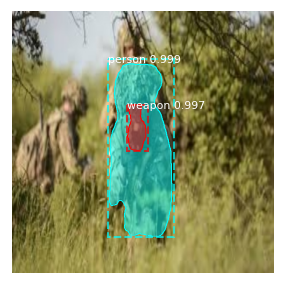

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


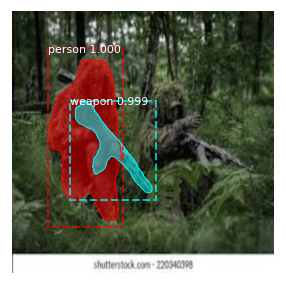

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  115.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


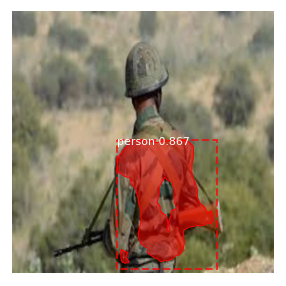

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


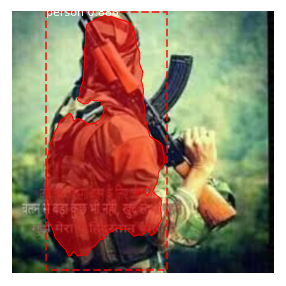

In [51]:
import skimage
real_test_dir = 'datasets/soldiers/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [52]:
model_path

'aktwelve_Mask_RCNN\\logs\\soldiers20210319T2048\\mask_rcnn_soldiers_0004.h5'